### Importation des librairies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import json
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn import metrics
import warnings
import datetime
import time 
import re
from IPython.display import Image

#Traitement des messages d'erreur :
warnings.filterwarnings('ignore')


### Fonctions utilisées dans le notebook

In [160]:
#Affichage d'un graphique en bâton pour représenter la répartition des valeurs manquantes
def graph_values_missing(dt_work):
    """Fonction pour afficher dans un graph en baton les valeurs manquantes"""
    dt_work.isnull().sum().sort_values().plot(kind="bar",
                                              title="Voici la répartition des valeurs manquantes du Datset :",
                                              figsize=(15, 5))
    plt.show()
    
#affichage du heatmap des valeurs manquantes
def heatmap_values_missing(dt_work):
    """Fonction pour afficher un heatmap avec les valeurs manquantes"""
    plt.figure(figsize=(20,10))
    sns.heatmap(dt_work.isnull(),cbar=False)
    plt.show()
    
#Suppression des colonnes avec plus de 20% de valeurs manquantes
def delete_missing_values(dt_work, size_keeping):
    """Fonction pour supprimer les colonnes avec plus de 20% de valeurs manquantes"""
    data_list = pd.DataFrame(dt_work.isnull().sum())
    data_list = pd.DataFrame(dt_work.isnull().sum()).reset_index()
    data_list.columns =['Names_of_values', 'Number_of_values_missing']
    #print(data_list.head())
    columns_to_delete = data_list[(data_list['Number_of_values_missing'] > size_keeping)]
    columns_to_delete = columns_to_delete.drop(['Number_of_values_missing'], axis=1)
    list_to_delete = columns_to_delete['Names_of_values'].to_list()
    print(list_to_delete)
    dt_work.drop(list_to_delete, axis=1, inplace=True)
    
#Affichage en camenbert de la répartition de chaque types de variable
def graph_types_of_values(dt_work):
    """Fonction pour afficher la réparition dans un graph en camembert de chaque types de variable"""
    dt_work.dtypes.value_counts(normalize=True).plot(kind='pie',
                                                     title="Voici la répartition des types de valeur du Datset",
                                                     autopct='%.2f%%', label=" ", colors=['lightskyblue', 'yellowgreen', 'brown'])
    #Assurance que le graphe soit un cercle et non une ellipse
    plt.axis('equal')
    plt.show()
       
#Affichage de la présence de doublon
def duplicate(dt_work):
    """Fonction pour afficher la présence de doublon"""
    if len(dt_work.loc[dt_work.duplicated(keep=False),:]) == 0:
        print("Il n'y a pas de doublon dans le Dataset.\n")
    else:
        print("Nous avons la présence de doublon à corriger.\n")
        
#Afficher les éléments unique d'une liste
def list_unique_of_value(dt_work):
    """Fonction pour afficher les éléments unique d'une liste"""
    list_values = Counter(dt_work).keys()
    display(list_values)
    
#Affichage d'un tableau avec les taux de valeurs manquantes
def tab_missing_values(dt_work):
    """Fonction pour afficher dans un tableau de taux de valeurs manquantes pour chaque variable"""
    total_val_missing = dt_work.isnull().sum().sort_values(ascending = False)
    tx_val_missing = (dt_work.isnull().sum()/dt_work.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total_val_missing, tx_val_missing],
                     axis=1, keys=['Nombre de valeurs manquantes',
                                   'Taux de valeurs manquantes'])

#Affichage de la proportion de valeurs manquantes
def values_missing(dt_work):
    """Fonction pour afficher la proportion de valeurs manquantes"""
    total_values_missing=dt_work.isnull().sum().sum()
    total_values_dt=np.product(dt_work.shape)
    rate_values_missing=round((total_values_missing/total_values_dt)*100)
    print("Nous avons ", total_values_missing, " valeurs manquantes pour un dataset de ",
          total_values_dt, " données soit un taux de données manquantes de ", rate_values_missing, " %.")
        
#Affichage du nombre de valeurs uniques pour chaque colonne
def view_number_of_unique_value(dt_work):
    """Fonction pour afficher le nombre de valeurs uniques pour chaque colonne"""
    for column in dt_work.columns:
        print('Pour la colonne {}, nous avons {} valeurs uniques'.format(column, dt_work[column].nunique()))
        
#Affichage des la quantité de données pour chaque valeur d'un graphique en camembert avec les pourcentages et une légende
def graph_camembert(dt_work, column_stats):
    """Fonction pour afficher dans un graph en camembert la quantité de donnée avec les % et les noms des variables"""
    dt_values_stats = column_stats.value_counts()
    graphic_title = column_stats.name
    print("Voici la répartition dans la colonne analysée : \n", dt_values_stats, "\n")
    plt.figure(figsize=(20,10))
    graph_dt_values = column_stats.value_counts(normalize=True).plot(kind='pie', label='',
                                                                     labeldistance=1.2, fontsize=18)
    x = dt_values_stats
    textprops = {"fontsize":15}
    patches, texts, autotexts = graph_dt_values.pie(x, autopct='%.1f%%', pctdistance=1.1,
                                                wedgeprops={'linewidth': 10.0, 'edgecolor': 'white'},
                                                textprops=textprops)
    plt.setp(autotexts, color='black', fontweight='bold')
    plt.legend(title=graphic_title, bbox_to_anchor=(1, 0, 0.35, 1), loc="best", fontsize="x-large")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#Fonction pour calculer le pourcentage de valeurs manquantes
def missing_data(data):
    """Fonction pour calculer le taux de valeurs manquantes"""
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#Fonction pour afficher dans un graphique la répartition d'une variable et le taux concernant les personnes qui ne remboursent pas leur prêt
#Fonction utilisée pour data_app_train et data_app_test
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    """Fonction pour afficher la répartition d'une variable et le taux avec la variable target à 1
    (traget 1 = client qui ne rembourse pas son prêt)"""
    temp = data_app_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Nombre de contrats': temp.values})

    #Calcule du taux de Target = 1 pour une variable
    cat_perc = data_app_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Nombre de contrats",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Taux de la variable Target avec une valeur à 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show()

    
#Diagramme de densité avec une variable
#Fonction utilisée pour data_app_train et data_app_test
def plot_distribution(feature,color):
    """Fonction pour afficher le diagramme de densité d'une variable"""
    plt.figure(figsize=(10,6))
    plt.title("Distribution de %s" % feature)
    sns.distplot(data_app_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()     
    
#Fonction pour afficher la distribution d'une variable avec Target  à 0 et Target à 1
#Fonction utilisée pour data_app_train et data_app_test
def plot2_distribution(var):
    """Fonction pour afficher la distribution d'une variable en fonction de la variable Target"""    
    i = 0
    t1 = data_app_train.loc[data_app_train['TARGET'] != 0]
    t0 = data_app_train.loc[data_app_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Diagramme de densité', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

#Diagramme de densité avec plusieurs variables et avec sur le même graphique les résultats avec Target à 0 et à 1
#Fonction utilisée pour data_app_train et data_app_test
def plot_distribution_comp(var,nrow=2):
    """Fonction pour afficher plusieurs diagramme de densité en prenant en compte la variable Target"""
    i = 0
    t1 = data_app_train.loc[data_app_train['TARGET'] != 0]
    t0 = data_app_train.loc[data_app_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Diagramme de densité', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

#Fonction pour afficher dans un graphique la répartition d'une variable et le taux concernant les personnes qui ne remboursent pas leur prêt
#Fonction utilisée pour data_app_bureau_train
def plot_b_stats(feature,label_rotation=False,horizontal_layout=True):
    """Fonction pour afficher la répartition d'une variable et le taux avec la variable target à 1
    (traget 1 = client qui ne rembourse pas son prêt)"""
    temp = data_app_bureau_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Nombre de contrats': temp.values})

    #Calcule du taux de Target = 1 pour une variable
    cat_perc = data_app_bureau_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Nombre de contrats",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Taux de la variable Target avec une valeur à 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

#Diagramme de densité avec une variable
#Fonction utilisée pour data_app_bureau_train
def plot_b_distribution(feature,color):
    """Fonction pour afficher le diagramme de densité d'une variable"""
    plt.figure(figsize=(10,6))
    plt.title("Distribution de %s" % feature)
    sns.distplot(data_app_bureau_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show() 

#Fonction pour identifier de manière boolénne si un point est un outlier ou non
def is_outlier(points, thresh=3.5):
    """Fonction pour identifier dans un tableau les points représentants ou non des outliers"""
    """
    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

#Diagramme de densité avec une variable
#Fonction utilisée pour data_app_bureau_train et data_app_test
def plot_b_o_distribution(feature,color):
    """Fonction pour afficher le diagramme de densité d'une variable"""
    plt.figure(figsize=(10,6))
    plt.title("Distribution de %s" % feature)
    x = data_app_bureau_train[feature].dropna()
    filtered = x[~is_outlier(x)]
    sns.distplot(filtered,color=color, kde=True,bins=100)
    plt.show() 
    
#Fonction pour afficher dans un graphique la distribution de plusieurs variables avec target à 0 et à 1
#Fonction utilisée pour data_app_bureau_train
def plot_b_distribution_comp(var,nrow=2):
    """Fonction pour afficher plusieurs diagramme de densité en prenant en compte la variable Target"""
    i = 0
    t1 = data_app_bureau_train.loc[data_app_bureau_train['TARGET'] != 0]
    t0 = data_app_bureau_train.loc[data_app_bureau_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

#Fonction pour afficher dans un graphique la répartition d'une variable et le taux concernant les personnes qui ne remboursent pas leur prêt
#Fonction utilisée pour data_app_previous_train    
def plot_p_stats(feature,label_rotation=False,horizontal_layout=True):
    """Fonction pour afficher la répartition d'une variable et le taux avec la variable target à 1
    (traget 1 = client qui ne rembourse pas son prêt)"""
    temp = data_app_previous_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Nombre de contrats': temp.values})

    #Calcule du taux de Target = 1 pour une variable
    cat_perc = data_app_previous_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Nombre de contrats",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Taux de la variable Target avec une valeur à 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show()
    
#Fonction pour trouver les corrélations entre une variable lorsque Target est à 0 ou à 1 
def target_correlation (df):
    """Fonction pour avoir les corrélations d'une variable en fonction de la variable Target"""
    correlations = df.corr()['TARGET'].sort_values(ascending=False)
    return correlations

#Fonction pour réaliser le graphique d'une matrice de corrélations d'un dataset
def heatmap_correlation(df) :
    """Fonction pour afficher une matrice de corrélation d'un dataset"""
    corr = df.corr()
    plt.figure(figsize=(30,30))
    sns.heatmap(corr , annot=True, linewidths=.2, cmap="YlGnBu")

### Lecture des Datasets

In [5]:
path = 'Projet_7/'

In [6]:
data_app_test = pd.read_csv(path + "application_test.csv")
print("Nous avons un dataset de ", data_app_test.shape[0],
      " lignes et ", data_app_test.shape[1], " colonnes.")

Nous avons un dataset de  48744  lignes et  121  colonnes.


In [7]:
#affichage d'un apperçu des données du dataset
display(data_app_test.head())

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [8]:
values_missing(data_app_test)
print("\n Tableau des valeurs manquantes du dataset :")
tab_missing_values(data_app_test)

Nous avons  1404419  valeurs manquantes pour un dataset de  5898024  données soit un taux de données manquantes de  24  %.

 Tableau des valeurs manquantes du dataset :


Nombre de valeurs manquantes  \
COMMONAREA_AVG                                   33495   
COMMONAREA_MODE                                  33495   
COMMONAREA_MEDI                                  33495   
NONLIVINGAPARTMENTS_AVG                          33347   
NONLIVINGAPARTMENTS_MODE                         33347   
...                                                ...   
NAME_HOUSING_TYPE                                    0   
NAME_FAMILY_STATUS                                   0   
NAME_EDUCATION_TYPE                                  0   
NAME_INCOME_TYPE                                     0   
SK_ID_CURR                                           0   

                          Taux de valeurs manquantes  
COMMONAREA_AVG                             68.716150  
COMMONAREA_MODE                            68.716150  
COMMONAREA_MEDI                            68.716150  
NONLIVINGAPARTMENTS_AVG                    68.412523  
NONLIVINGAPARTMENTS_MODE                   68.412523  
...                                              ...  
NAME_HOUSING_TYPE                           0.000000  
NAME_FAMILY_STATUS                          0.000000  
NAME_EDUCATION_TYPE                         0.000000  
NAME_INCOME_TYPE                            0.000000  
SK_ID_CURR                                  0.000000  

[121 rows x 2 columns]


 Graphique de répartition des valeurs manquantes : 


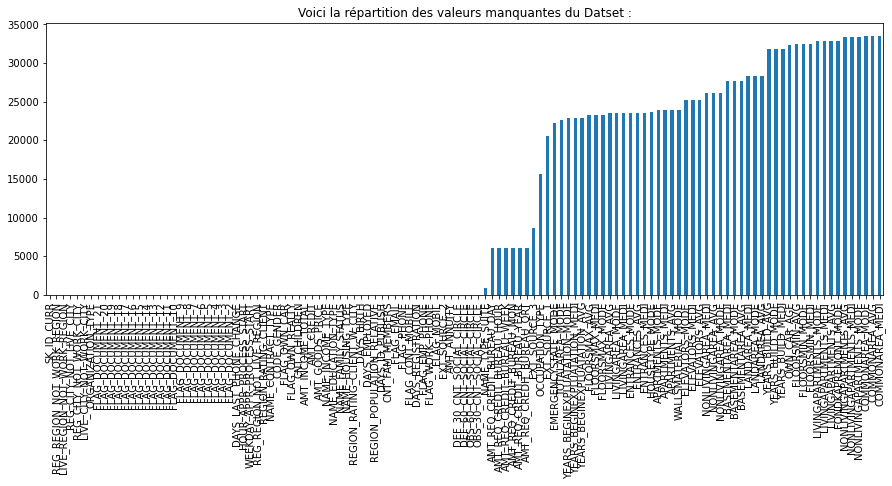

In [9]:
print("\n Graphique de répartition des valeurs manquantes : ")
graph_values_missing(data_app_test)

In [10]:
data_app_train = pd.read_csv(path + "application_train.csv")
print("Nous avons un dataset de ", data_app_train.shape[0],
      " lignes et ", data_app_train.shape[1], " colonnes.")

Nous avons un dataset de  307511  lignes et  122  colonnes.


In [11]:
#affichage d'un apperçu des données du dataset
display(data_app_train.head())

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [12]:
values_missing(data_app_train)
print("\n Tableau des valeurs manquantes du dataset :")
tab_missing_values(data_app_train)

Nous avons  9152465  valeurs manquantes pour un dataset de  37516342  données soit un taux de données manquantes de  24  %.

 Tableau des valeurs manquantes du dataset :


Nombre de valeurs manquantes  \
COMMONAREA_MEDI                                 214865   
COMMONAREA_AVG                                  214865   
COMMONAREA_MODE                                 214865   
NONLIVINGAPARTMENTS_MODE                        213514   
NONLIVINGAPARTMENTS_AVG                         213514   
...                                                ...   
NAME_HOUSING_TYPE                                    0   
NAME_FAMILY_STATUS                                   0   
NAME_EDUCATION_TYPE                                  0   
NAME_INCOME_TYPE                                     0   
SK_ID_CURR                                           0   

                          Taux de valeurs manquantes  
COMMONAREA_MEDI                            69.872297  
COMMONAREA_AVG                             69.872297  
COMMONAREA_MODE                            69.872297  
NONLIVINGAPARTMENTS_MODE                   69.432963  
NONLIVINGAPARTMENTS_AVG                    69.432963  
...                                              ...  
NAME_HOUSING_TYPE                           0.000000  
NAME_FAMILY_STATUS                          0.000000  
NAME_EDUCATION_TYPE                         0.000000  
NAME_INCOME_TYPE                            0.000000  
SK_ID_CURR                                  0.000000  

[122 rows x 2 columns]


 Graphique de répartition des valeurs manquantes : 


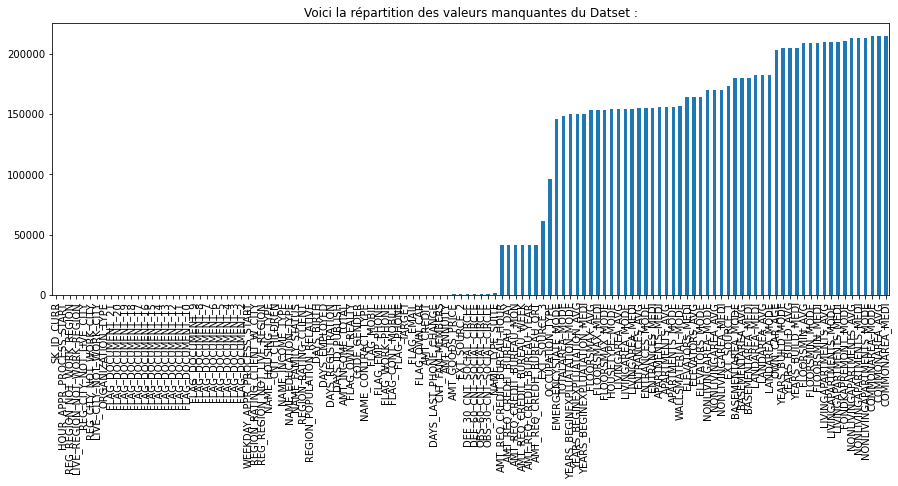

In [13]:
print("\n Graphique de répartition des valeurs manquantes : ")
graph_values_missing(data_app_train)

In [14]:
data_bureau = pd.read_csv(path + "bureau.csv")
print("Nous avons un dataset de ", data_bureau.shape[0],
      " lignes et ", data_bureau.shape[1], " colonnes.")

Nous avons un dataset de  1716428  lignes et  17  colonnes.


In [15]:
#affichage d'un apperçu des données du dataset
display(data_bureau.head())

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [16]:
values_missing(data_bureau)
print("\n Tableau des valeurs manquantes du dataset :")
tab_missing_values(data_bureau)

Nous avons  3939947  valeurs manquantes pour un dataset de  29179276  données soit un taux de données manquantes de  14  %.

 Tableau des valeurs manquantes du dataset :


Nombre de valeurs manquantes  \
AMT_ANNUITY                                  1226791   
AMT_CREDIT_MAX_OVERDUE                       1124488   
DAYS_ENDDATE_FACT                             633653   
AMT_CREDIT_SUM_LIMIT                          591780   
AMT_CREDIT_SUM_DEBT                           257669   
DAYS_CREDIT_ENDDATE                           105553   
AMT_CREDIT_SUM                                    13   
CREDIT_ACTIVE                                      0   
CREDIT_CURRENCY                                    0   
DAYS_CREDIT                                        0   
CREDIT_DAY_OVERDUE                                 0   
SK_ID_BUREAU                                       0   
CNT_CREDIT_PROLONG                                 0   
AMT_CREDIT_SUM_OVERDUE                             0   
CREDIT_TYPE                                        0   
DAYS_CREDIT_UPDATE                                 0   
SK_ID_CURR                                         0   

                        Taux de valeurs manquantes  
AMT_ANNUITY                              71.473490  
AMT_CREDIT_MAX_OVERDUE                   65.513264  
DAYS_ENDDATE_FACT                        36.916958  
AMT_CREDIT_SUM_LIMIT                     34.477415  
AMT_CREDIT_SUM_DEBT                      15.011932  
DAYS_CREDIT_ENDDATE                       6.149573  
AMT_CREDIT_SUM                            0.000757  
CREDIT_ACTIVE                             0.000000  
CREDIT_CURRENCY                           0.000000  
DAYS_CREDIT                               0.000000  
CREDIT_DAY_OVERDUE                        0.000000  
SK_ID_BUREAU                              0.000000  
CNT_CREDIT_PROLONG                        0.000000  
AMT_CREDIT_SUM_OVERDUE                    0.000000  
CREDIT_TYPE                               0.000000  
DAYS_CREDIT_UPDATE                        0.000000  
SK_ID_CURR                                0.000000


 Graphique de répartition des valeurs manquantes : 


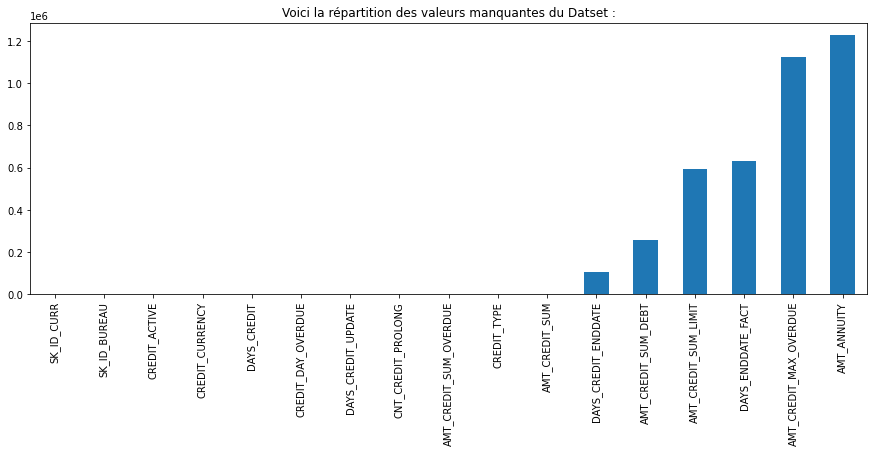

In [17]:
print("\n Graphique de répartition des valeurs manquantes : ")
graph_values_missing(data_bureau)

In [18]:
data_bureau_balance = pd.read_csv(path + "bureau_balance.csv")
print("Nous avons un dataset de ", data_bureau_balance.shape[0],
      " lignes et ", data_bureau_balance.shape[1], " colonnes.")

Nous avons un dataset de  27299925  lignes et  3  colonnes.


In [19]:
#affichage d'un apperçu des données du dataset
display(data_bureau_balance.head())

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [20]:
values_missing(data_bureau_balance)
print("\n Tableau des valeurs manquantes du dataset :")
tab_missing_values(data_bureau_balance)

Nous avons  0  valeurs manquantes pour un dataset de  81899775  données soit un taux de données manquantes de  0  %.

 Tableau des valeurs manquantes du dataset :


Nombre de valeurs manquantes  Taux de valeurs manquantes
SK_ID_BUREAU                               0                         0.0
MONTHS_BALANCE                             0                         0.0
STATUS                                     0                         0.0


 Graphique de répartition des valeurs manquantes : 


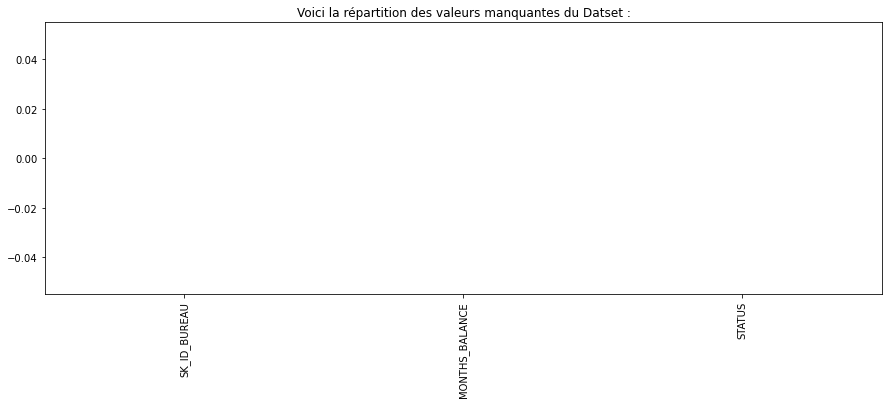

In [21]:
print("\n Graphique de répartition des valeurs manquantes : ")
graph_values_missing(data_bureau_balance)

In [22]:
data_credit_card_balance = pd.read_csv(path + "credit_card_balance.csv")
print("Nous avons un dataset de ", data_credit_card_balance.shape[0],
      " lignes et ", data_credit_card_balance.shape[1], " colonnes.")

Nous avons un dataset de  3840312  lignes et  23  colonnes.


In [23]:
#affichage d'un apperçu des données du dataset
display(data_credit_card_balance.head())

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [24]:
values_missing(data_credit_card_balance)
print("\n Tableau des valeurs manquantes du dataset :")
tab_missing_values(data_credit_card_balance)

Nous avons  5877356  valeurs manquantes pour un dataset de  88327176  données soit un taux de données manquantes de  7  %.

 Tableau des valeurs manquantes du dataset :


Nombre de valeurs manquantes  \
AMT_PAYMENT_CURRENT                               767988   
AMT_DRAWINGS_ATM_CURRENT                          749816   
CNT_DRAWINGS_POS_CURRENT                          749816   
AMT_DRAWINGS_OTHER_CURRENT                        749816   
AMT_DRAWINGS_POS_CURRENT                          749816   
CNT_DRAWINGS_OTHER_CURRENT                        749816   
CNT_DRAWINGS_ATM_CURRENT                          749816   
CNT_INSTALMENT_MATURE_CUM                         305236   
AMT_INST_MIN_REGULARITY                           305236   
SK_ID_PREV                                             0   
AMT_TOTAL_RECEIVABLE                                   0   
SK_DPD                                                 0   
NAME_CONTRACT_STATUS                                   0   
CNT_DRAWINGS_CURRENT                                   0   
AMT_PAYMENT_TOTAL_CURRENT                              0   
AMT_RECIVABLE                                          0   
AMT_RECEIVABLE_PRINCIPAL                               0   
SK_ID_CURR                                             0   
AMT_DRAWINGS_CURRENT                                   0   
AMT_CREDIT_LIMIT_ACTUAL                                0   
AMT_BALANCE                                            0   
MONTHS_BALANCE                                         0   
SK_DPD_DEF                                             0   

                            Taux de valeurs manquantes  
AMT_PAYMENT_CURRENT                          19.998063  
AMT_DRAWINGS_ATM_CURRENT                     19.524872  
CNT_DRAWINGS_POS_CURRENT                     19.524872  
AMT_DRAWINGS_OTHER_CURRENT                   19.524872  
AMT_DRAWINGS_POS_CURRENT                     19.524872  
CNT_DRAWINGS_OTHER_CURRENT                   19.524872  
CNT_DRAWINGS_ATM_CURRENT                     19.524872  
CNT_INSTALMENT_MATURE_CUM                     7.948208  
AMT_INST_MIN_REGULARITY                       7.948208  
SK_ID_PREV                                    0.000000  
AMT_TOTAL_RECEIVABLE                          0.000000  
SK_DPD                                        0.000000  
NAME_CONTRACT_STATUS                          0.000000  
CNT_DRAWINGS_CURRENT                          0.000000  
AMT_PAYMENT_TOTAL_CURRENT                     0.000000  
AMT_RECIVABLE                                 0.000000  
AMT_RECEIVABLE_PRINCIPAL                      0.000000  
SK_ID_CURR                                    0.000000  
AMT_DRAWINGS_CURRENT                          0.000000  
AMT_CREDIT_LIMIT_ACTUAL                       0.000000  
AMT_BALANCE                                   0.000000  
MONTHS_BALANCE                                0.000000  
SK_DPD_DEF                                    0.000000


 Graphique de répartition des valeurs manquantes : 


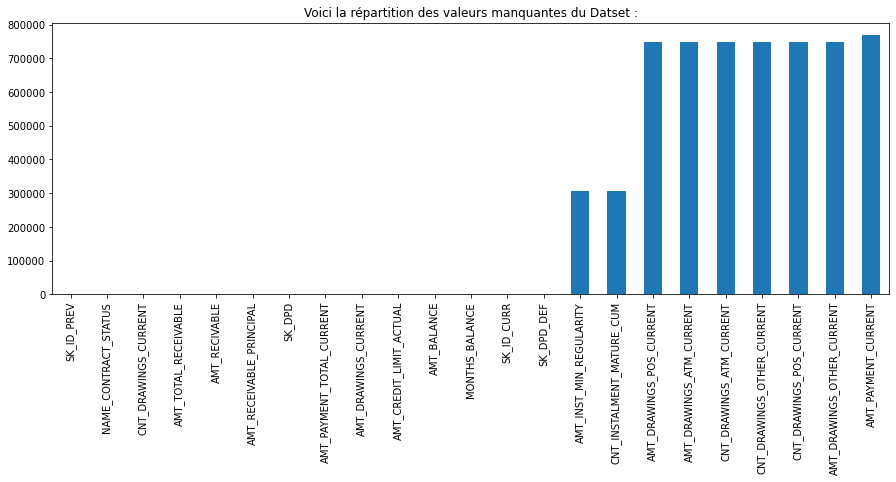

In [25]:
print("\n Graphique de répartition des valeurs manquantes : ")
graph_values_missing(data_credit_card_balance)

In [26]:
R = []

with open(path + "HomeCredit_columns_description.csv", newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    
    for row in spamreader:
        R.append(('#'.join(row)))
#Print pour vérifier que les lignes ont bien été enregistrées dans la variable
#print(R)
data_homeCredit_dict = {}
data_homeCredit_dict = re.split(',',str(R))
dt_work = pd.DataFrame(data_homeCredit_dict, columns=['column_before_split'])
#display(dt_work.head())
#print((dt_work.keys))

#On permet l'affichage de toutes les lignes et colonnes en cas de nécessité de vérification
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth',3000)
#On scinde le dataframe sur le caractère #
dt_work = (dt_work['column_before_split'].str.split('#',expand=True))[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]]
#On renomme les colonnes
dt_work = dt_work.rename(columns={dt_work.columns[0]: 'Ligne', dt_work.columns[1]: 'Table', dt_work.columns[2]: 'Row',
                                  dt_work.columns[3]: '3', dt_work.columns[4]: '4', dt_work.columns[5]: '5',
                                  dt_work.columns[6]: '6', dt_work.columns[7]: '7', dt_work.columns[8]: '8',
                                  dt_work.columns[9]: '9', dt_work.columns[10]: '10', dt_work.columns[11]: '11',
                                  dt_work.columns[12]: '12', dt_work.columns[13]: '13', dt_work.columns[14]: '14'})
#On remplace les valeurs None par une case vide
dt_work.replace(to_replace=[None], value='', inplace=True)
display(dt_work.head())

#On crée une colonne Description avec les valeurs des colonnes 3 à 14 pour obtenir une colonne finale Description
dt_work["Description"] = (dt_work["3"].astype(str) + dt_work["4"].astype(str) + dt_work["5"].astype(str)
                  + dt_work["6"].astype(str) + dt_work["7"].astype(str) + dt_work["8"].astype(str)
                  + dt_work["9"].astype(str) + dt_work["10"].astype(str) + dt_work["11"].astype(str)
                  + dt_work["12"].astype(str) + dt_work["13"].astype(str) + dt_work["14"].astype(str))
dt_work.drop(["3","4","5","6","7","8","9","10","11","12","13","14"], axis=1, inplace=True)
dt_work.drop(0, axis=0, inplace=True)
#On enlève les caractères spéciaux du dataframe
dt_work = dt_work.replace("'",'', regex=True)
dt_work = dt_work.replace("\"",'', regex=True)
data_HomeCredit_columns_description = dt_work.copy()
display(data_HomeCredit_columns_description.head())

Ligne                         Table                 Row  \
0    ['                         Table                 Row   
1    '1  application_{train|test}.csv          SK_ID_CURR   
2    '2  application_{train|test}.csv              TARGET   
3    '5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
4    '6  application_{train|test}.csv         CODE_GENDER   

                                                   3                       4  \
0                                        Description                Special'   
1                           ID of loan in our sample                       '   
2  "Target variable (1 - client with payment diff...   0 - all other cases)"   
3        Identification if loan is cash or revolving                       '   
4                               Gender of the client                       '   

   5 6 7 8 9 10 11 12 13 14  
0                            
1                            
2  '                         
3                            
4

Ligne                         Table                 Row  \
1     1  application_{train|test}.csv          SK_ID_CURR   
2     2  application_{train|test}.csv              TARGET   
3     5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
4     6  application_{train|test}.csv         CODE_GENDER   
5     7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description  
1                           ID of loan in our sample  
2  Target variable (1 - client with payment diffi...  
3        Identification if loan is cash or revolving  
4                               Gender of the client  
5                      Flag if the client owns a car

In [109]:
pd.set_option('display.max_colwidth',3000)
display(data_HomeCredit_columns_description)
print("Nous avons un dataset de ", data_HomeCredit_columns_description.shape[0],
      " lignes et ", data_HomeCredit_columns_description.shape[1], " colonnes.")

Ligne                         Table                           Row  \
1       1  application_{train|test}.csv                    SK_ID_CURR   
2       2  application_{train|test}.csv                        TARGET   
3       5  application_{train|test}.csv            NAME_CONTRACT_TYPE   
4       6  application_{train|test}.csv                   CODE_GENDER   
5       7  application_{train|test}.csv                  FLAG_OWN_CAR   
6       8  application_{train|test}.csv               FLAG_OWN_REALTY   
7       9  application_{train|test}.csv                  CNT_CHILDREN   
8      10  application_{train|test}.csv              AMT_INCOME_TOTAL   
9      11  application_{train|test}.csv                    AMT_CREDIT   
10     12  application_{train|test}.csv                   AMT_ANNUITY   
11     13  application_{train|test}.csv               AMT_GOODS_PRICE   
12     14  application_{train|test}.csv               NAME_TYPE_SUITE   
13     15  application_{train|test}.csv              NAME_INCOME_TYPE   
14     16  application_{train|test}.csv           NAME_EDUCATION_TYPE   
15     17  application_{train|test}.csv            NAME_FAMILY_STATUS   
16     18  application_{train|test}.csv             NAME_HOUSING_TYPE   
17     19  application_{train|test}.csv    REGION_POPULATION_RELATIVE   
18     20  application_{train|test}.csv                    DAYS_BIRTH   
19     21  application_{train|test}.csv                 DAYS_EMPLOYED   
20     22  application_{train|test}.csv             DAYS_REGISTRATION   
21     23  application_{train|test}.csv               DAYS_ID_PUBLISH   
22     24  application_{train|test}.csv                   OWN_CAR_AGE   
23     25  application_{train|test}.csv                    FLAG_MOBIL   
24     26  application_{train|test}.csv                FLAG_EMP_PHONE   
25     27  application_{train|test}.csv               FLAG_WORK_PHONE   
26     28  application_{train|test}.csv              FLAG_CONT_MOBILE   
27     29  application_{train|test}.csv                    FLAG_PHONE   
28     30  application_{train|test}.csv                    FLAG_EMAIL   
29     31  application_{train|test}.csv               OCCUPATION_TYPE   
30     32  application_{train|test}.csv               CNT_FAM_MEMBERS   
31     33  application_{train|test}.csv          REGION_RATING_CLIENT   
32     34  application_{train|test}.csv   REGION_RATING_CLIENT_W_CITY   
33     35  application_{train|test}.csv    WEEKDAY_APPR_PROCESS_START   
34     36  application_{train|test}.csv       HOUR_APPR_PROCESS_START   
35     37  application_{train|test}.csv    REG_REGION_NOT_LIVE_REGION   
36     38  application_{train|test}.csv    REG_REGION_NOT_WORK_REGION   
37     39  application_{train|test}.csv   LIVE_REGION_NOT_WORK_REGION   
38     40  application_{train|test}.csv        REG_CITY_NOT_LIVE_CITY   
39     41  application_{train|test}.csv        REG_CITY_NOT_WORK_CITY   
40     42  application_{train|test}.csv       LIVE_CITY_NOT_WORK_CITY   
41     43  application_{train|test}.csv             ORGANIZATION_TYPE   
42     44  application_{train|test}.csv                  EXT_SOURCE_1   
43     45  application_{train|test}.csv                  EXT_SOURCE_2   
44     46  application_{train|test}.csv                  EXT_SOURCE_3   
45     47  application_{train|test}.csv                APARTMENTS_AVG   
46     48  application_{train|test}.csv              BASEMENTAREA_AVG   
47     49  application_{train|test}.csv   YEARS_BEGINEXPLUATATION_AVG   
48     50  application_{train|test}.csv               YEARS_BUILD_AVG   
49     51  application_{train|test}.csv                COMMONAREA_AVG   
50     52  application_{train|test}.csv                 ELEVATORS_AVG   
51     53  application_{train|test}.csv                 ENTRANCES_AVG   
52     54  application_{train|test}.csv                 FLOORSMAX_AVG   
53     55  application_{train|test}.csv                 FLOORSMIN_AVG   
54     56  application_{train|test}.csv                  LANDA

Nous avons un dataset de  219  lignes et  4  colonnes.


In [28]:
values_missing(data_HomeCredit_columns_description)
print("\n Tableau des valeurs manquantes du dataset :")
tab_missing_values(data_HomeCredit_columns_description)

Nous avons  0  valeurs manquantes pour un dataset de  876  données soit un taux de données manquantes de  0  %.

 Tableau des valeurs manquantes du dataset :


Nombre de valeurs manquantes  Taux de valeurs manquantes
Ligne                                   0                         0.0
Table                                   0                         0.0
Row                                     0                         0.0
Description                             0                         0.0


 Graphique de répartition des valeurs manquantes : 


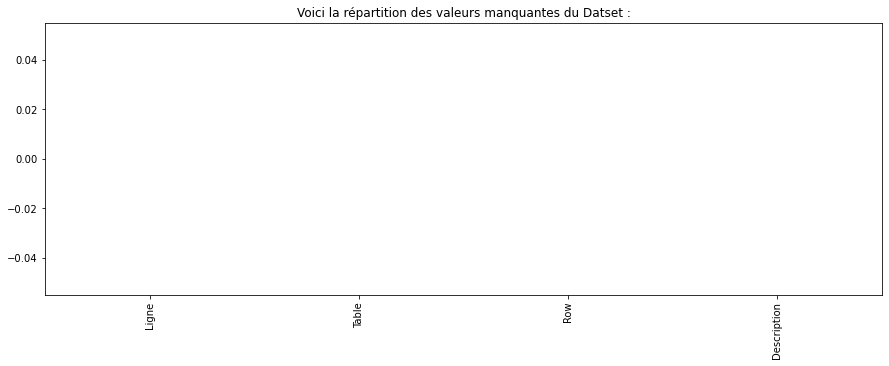

In [29]:
print("\n Graphique de répartition des valeurs manquantes : ")
graph_values_missing(data_HomeCredit_columns_description)

In [30]:
data_installments_payments = pd.read_csv(path + "installments_payments.csv")
print("Nous avons un dataset de ", data_installments_payments.shape[0],
      " lignes et ", data_installments_payments.shape[1], " colonnes.")

Nous avons un dataset de  13605401  lignes et  8  colonnes.


In [31]:
#affichage d'un apperçu des données du dataset
display(data_installments_payments.head())

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [32]:
values_missing(data_installments_payments)
print("\n Tableau des valeurs manquantes du dataset :")
tab_missing_values(data_installments_payments)

Nous avons  5810  valeurs manquantes pour un dataset de  108843208  données soit un taux de données manquantes de  0  %.

 Tableau des valeurs manquantes du dataset :


Nombre de valeurs manquantes  \
DAYS_ENTRY_PAYMENT                              2905   
AMT_PAYMENT                                     2905   
SK_ID_PREV                                         0   
SK_ID_CURR                                         0   
NUM_INSTALMENT_VERSION                             0   
NUM_INSTALMENT_NUMBER                              0   
DAYS_INSTALMENT                                    0   
AMT_INSTALMENT                                     0   

                        Taux de valeurs manquantes  
DAYS_ENTRY_PAYMENT                        0.021352  
AMT_PAYMENT                               0.021352  
SK_ID_PREV                                0.000000  
SK_ID_CURR                                0.000000  
NUM_INSTALMENT_VERSION                    0.000000  
NUM_INSTALMENT_NUMBER                     0.000000  
DAYS_INSTALMENT                           0.000000  
AMT_INSTALMENT                            0.000000


 Graphique de répartition des valeurs manquantes : 


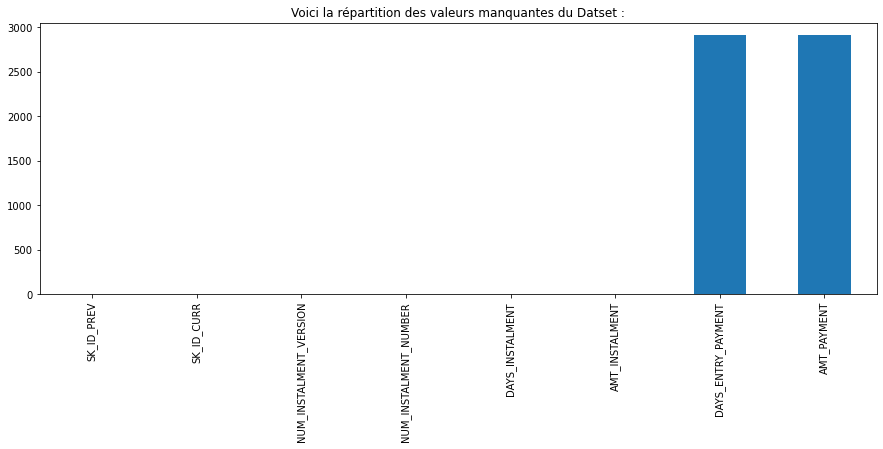

In [33]:
print("\n Graphique de répartition des valeurs manquantes : ")
graph_values_missing(data_installments_payments)

In [34]:
data_POS_CASH_balance = pd.read_csv(path + "POS_CASH_balance.csv")
print("Nous avons un dataset de ", data_POS_CASH_balance.shape[0],
      " lignes et ", data_POS_CASH_balance.shape[1], " colonnes.")

Nous avons un dataset de  10001358  lignes et  8  colonnes.


In [35]:
#affichage d'un apperçu des données du dataset
display(data_POS_CASH_balance.head())

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [36]:
values_missing(data_POS_CASH_balance)
print("\n Tableau des valeurs manquantes du dataset :")
tab_missing_values(data_POS_CASH_balance)

Nous avons  52158  valeurs manquantes pour un dataset de  80010864  données soit un taux de données manquantes de  0  %.

 Tableau des valeurs manquantes du dataset :


Nombre de valeurs manquantes  \
CNT_INSTALMENT_FUTURE                         26087   
CNT_INSTALMENT                                26071   
SK_ID_PREV                                        0   
SK_ID_CURR                                        0   
MONTHS_BALANCE                                    0   
NAME_CONTRACT_STATUS                              0   
SK_DPD                                            0   
SK_DPD_DEF                                        0   

                       Taux de valeurs manquantes  
CNT_INSTALMENT_FUTURE                    0.260835  
CNT_INSTALMENT                           0.260675  
SK_ID_PREV                               0.000000  
SK_ID_CURR                               0.000000  
MONTHS_BALANCE                           0.000000  
NAME_CONTRACT_STATUS                     0.000000  
SK_DPD                                   0.000000  
SK_DPD_DEF                               0.000000


 Graphique de répartition des valeurs manquantes : 


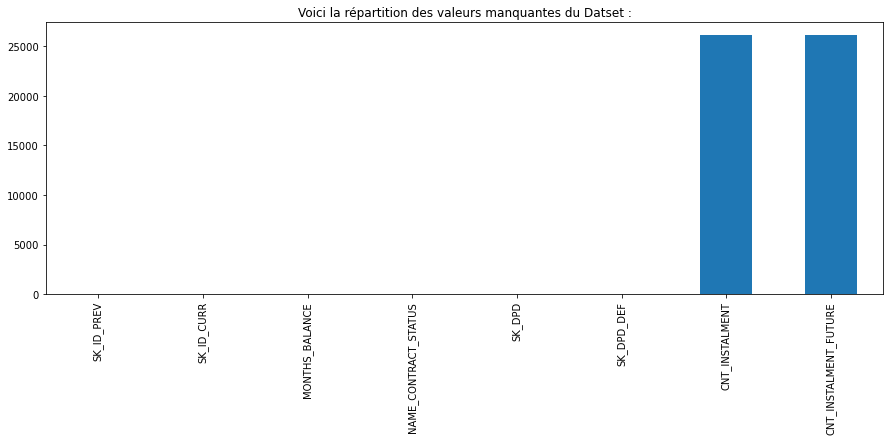

In [37]:
print("\n Graphique de répartition des valeurs manquantes : ")
graph_values_missing(data_POS_CASH_balance)

In [38]:
data_previous_application = pd.read_csv(path + "previous_application.csv")
print("Nous avons un dataset de ", data_previous_application.shape[0],
      " lignes et ", data_previous_application.shape[1], " colonnes.")

Nous avons un dataset de  1670214  lignes et  37  colonnes.


In [39]:
#affichage d'un apperçu des données du dataset
display(data_previous_application.head())

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [40]:
values_missing(data_previous_application)
print("\n Tableau des valeurs manquantes du dataset :")
tab_missing_values(data_previous_application)

Nous avons  11109336  valeurs manquantes pour un dataset de  61797918  données soit un taux de données manquantes de  18  %.

 Tableau des valeurs manquantes du dataset :


Nombre de valeurs manquantes  \
RATE_INTEREST_PRIVILEGED                          1664263   
RATE_INTEREST_PRIMARY                             1664263   
AMT_DOWN_PAYMENT                                   895844   
RATE_DOWN_PAYMENT                                  895844   
NAME_TYPE_SUITE                                    820405   
NFLAG_INSURED_ON_APPROVAL                          673065   
DAYS_TERMINATION                                   673065   
DAYS_LAST_DUE                                      673065   
DAYS_LAST_DUE_1ST_VERSION                          673065   
DAYS_FIRST_DUE                                     673065   
DAYS_FIRST_DRAWING                                 673065   
AMT_GOODS_PRICE                                    385515   
AMT_ANNUITY                                        372235   
CNT_PAYMENT                                        372230   
PRODUCT_COMBINATION                                   346   
AMT_CREDIT                                              1   
NAME_YIELD_GROUP                                        0   
NAME_PORTFOLIO                                          0   
NAME_SELLER_INDUSTRY                                    0   
SELLERPLACE_AREA                                        0   
CHANNEL_TYPE                                            0   
NAME_PRODUCT_TYPE                                       0   
SK_ID_PREV                                              0   
NAME_GOODS_CATEGORY                                     0   
NAME_CLIENT_TYPE                                        0   
CODE_REJECT_REASON                                      0   
SK_ID_CURR                                              0   
DAYS_DECISION                                           0   
NAME_CONTRACT_STATUS                                    0   
NAME_CASH_LOAN_PURPOSE                                  0   
NFLAG_LAST_APPL_IN_DAY                                  0   
FLAG_LAST_APPL_PER_CONTRACT                             0   
HOUR_APPR_PROCESS_START                                 0   
WEEKDAY_APPR_PROCESS_START                              0   
AMT_APPLICATION                                         0   
NAME_CONTRACT_TYPE                                      0   
NAME_PAYMENT_TYPE                                       0   

                             Taux de valeurs manquantes  
RATE_INTEREST_PRIVILEGED                      99.643698  
RATE_INTEREST_PRIMARY                         99.643698  
AMT_DOWN_PAYMENT                              53.636480  
RATE_DOWN_PAYMENT                             53.636480  
NAME_TYPE_SUITE                               49.119754  
NFLAG_INSURED_ON_APPROVAL                     40.298129  
DAYS_TERMINATION                              40.298129  
DAYS_LAST_DUE                                 40.298129  
DAYS_LAST_DUE_1ST_VERSION                     40.298129  
DAYS_FIRST_DUE                                40.298129  
DAYS_FIRST_DRAWING                            40.298129  
AMT_GOODS_PRICE                               23.081773  
AMT_ANNUITY                                   22.286665  
CNT_PAYMENT                                   22.286366  
PRODUCT_COMBINATION                            0.020716  
AMT_CREDIT                                     0.000060  
NAME_YIELD_GROUP                               0.000000  
NAME_PORTFOLIO                                 0.000000  
NAME_SELLER_INDUSTRY                           0.000000  
SELLERPLACE_AREA                               0.000000  
CHANNEL_TYPE                                   0.000000  
NAME_PRODUCT_TYPE                              0.000000  
SK_ID_PREV                                     0.000000  
NAME_GOODS_CATEGORY                            0.000000  
NAME_CLIENT_TYPE                               0.000000  
CODE_REJECT_REASON                             0.000000  
SK_ID_CURR                                     0.000000  
DAYS_DECISION                                  0.000000  
NAME_CONTRACT_STATUS        


 Graphique de répartition des valeurs manquantes : 


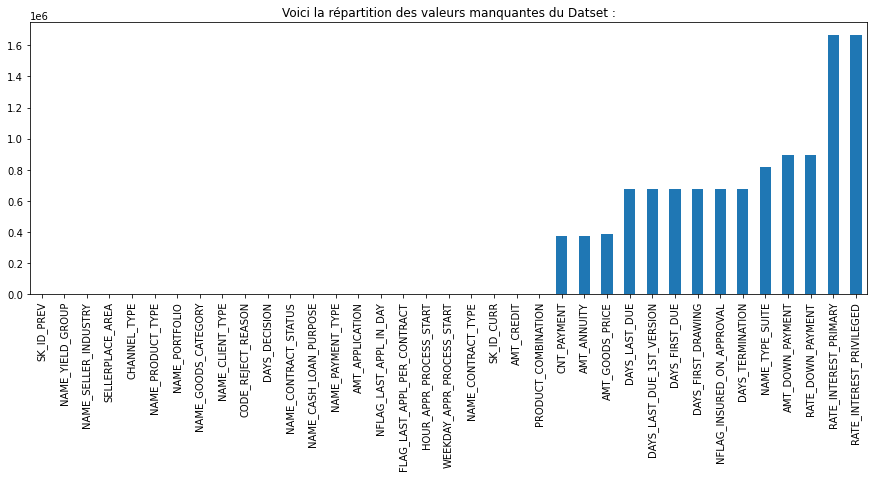

In [41]:
print("\n Graphique de répartition des valeurs manquantes : ")
graph_values_missing(data_previous_application)

In [42]:
data_sample_submission = pd.read_csv(path + "sample_submission.csv")
print("Nous avons un dataset de ", data_sample_submission.shape[0],
      " lignes et ", data_sample_submission.shape[1], " colonnes.")

Nous avons un dataset de  48744  lignes et  2  colonnes.


In [43]:
#affichage d'un apperçu des données du dataset
display(data_sample_submission.head())

SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

In [44]:
values_missing(data_sample_submission)
print("\n Tableau des valeurs manquantes du dataset :")
tab_missing_values(data_sample_submission)

Nous avons  0  valeurs manquantes pour un dataset de  97488  données soit un taux de données manquantes de  0  %.

 Tableau des valeurs manquantes du dataset :


Nombre de valeurs manquantes  Taux de valeurs manquantes
SK_ID_CURR                             0                         0.0
TARGET                                 0                         0.0


 Graphique de répartition des valeurs manquantes : 


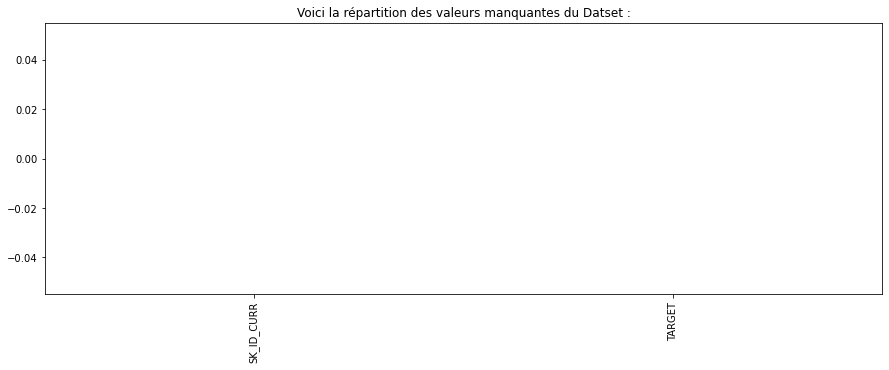

In [45]:
print("\n Graphique de répartition des valeurs manquantes : ")
graph_values_missing(data_sample_submission)

On retrouve principalement des données manquantes concernant des informations liées aux types ou lieux d'habitation des clients, les annuités d'emprunts, les découverts autorisés et enfin aux taux d'intérêts.
Après avoir eu une vue d'ensemble de chaque dataset et constaté que nous n'avions aucune valeur totalement manquante,
nous allons étudier plus en détail la composition de chaque dataset

Liens entre les datasets afin de pouvoir les regrouper dans un dataset unique :

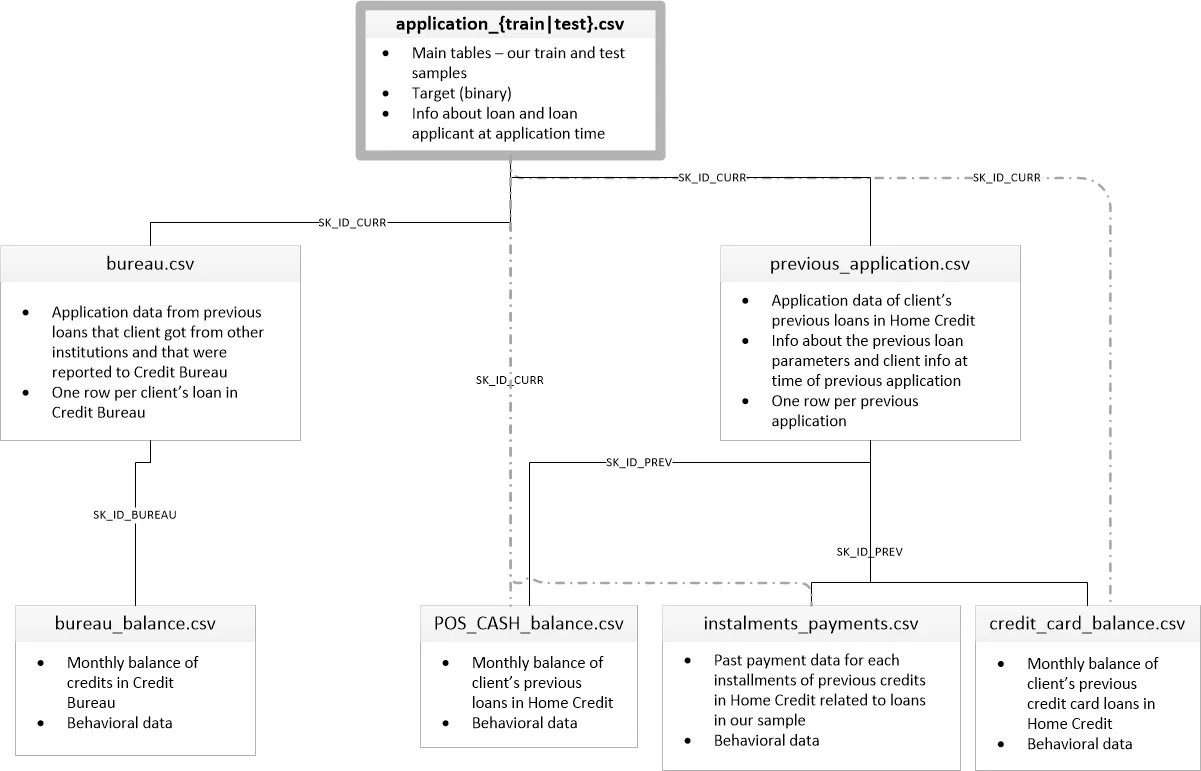

In [46]:
Image(filename = path + "image_liens_datasets.png", width=900, height=900)

### data_app_test / data_app_train

In [47]:
display(data_app_test.head())

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

In [48]:
display(data_app_train.head())

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

On voit que la colonne differente entre les 2 datasets est TARGET, on va donc afficher sa répartition sachant qu'il s'agit d'une indication pour savoir si un prêt est remboursé ou non (0 = prêt remboursé, 1 = prêt non remboursé) : 

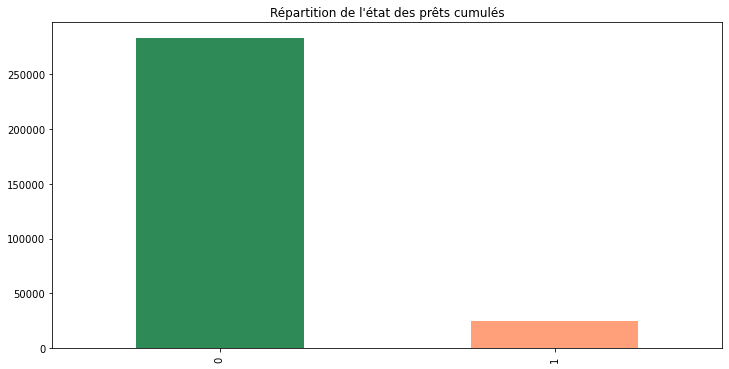

In [49]:
#Affichage de la répartition dans un graphique
proportion_target = data_app_train['TARGET'].value_counts() 
labels_target = proportion_target.index
plt.rcParams["figure.figsize"] = (12, 6)
proportion_target.plot(kind='bar',x='Etat du prêt', y='Nombre de prêts',
                       color=['seagreen', 'lightsalmon'])
plt.title("Répartition de l'état des prêts cumulés")
plt.show()

La variable SK_ID_CURR représente la l'identifiant du client. Nous allons donc regarder la variable NAME_CONTRACT_TYPE pour savoir quels type de prêts sont contractés (on fera l'étude pour les prêts remboursés puis pour les prêts non remboursés).
On va réaliser cette opération pour le dataset de train puis celui de test.

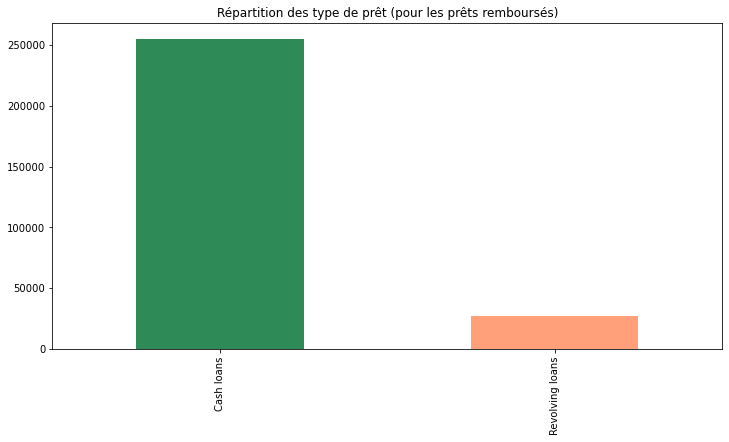

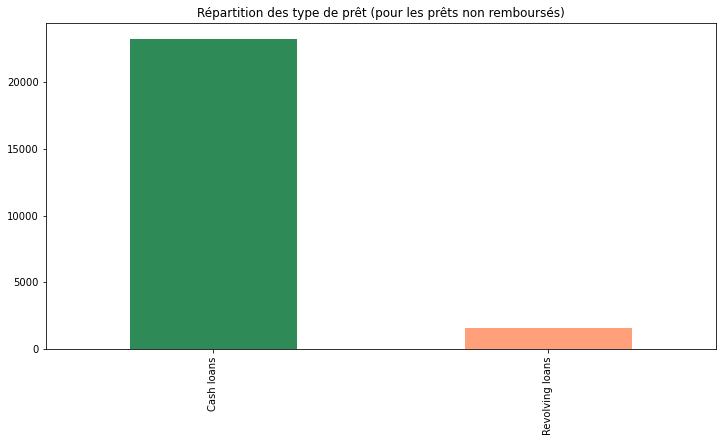

Nous avons 8.35  % de prêts de trésorerie non remboursés.
Nous avons 5.48  % de prêts revolving non remboursés.


In [50]:
#Affichage de la répartition dans un graphique pour data_app_train
target_0 = data_app_train.loc[data_app_train['TARGET'] == 0]
target_1 = data_app_train.loc[data_app_train['TARGET'] != 0]
proportion_name_contract_type_target_0 = target_0['NAME_CONTRACT_TYPE'].value_counts() 
proportion_name_contract_type_target_1 = target_1['NAME_CONTRACT_TYPE'].value_counts()
labels_name_contract_type_target_0 = proportion_name_contract_type_target_0.index
labels_name_contract_type_target_1 = proportion_name_contract_type_target_1.index
plt.rcParams["figure.figsize"] = (12, 6)
proportion_name_contract_type_target_0.plot(kind='bar',x='Types de prêt', y='Nombre de prêts',
                                            color=['seagreen', 'lightsalmon'])
plt.title("Répartition des type de prêt (pour les prêts remboursés)")
plt.show()
plt.rcParams["figure.figsize"] = (12, 6)
proportion_name_contract_type_target_1.plot(kind='bar',x='Types de prêt', y='Nombre de prêts',
                                            color=['seagreen', 'lightsalmon'])
plt.title("Répartition des type de prêt (pour les prêts non remboursés)")
plt.show()
#Affichage des taux de prêts non remboursés sur chaque type
quantity_cash = len(data_app_train.loc[data_app_train['NAME_CONTRACT_TYPE'] == 'Cash loans'])
quantity_cash_target_1 = len(target_1.loc[target_1['NAME_CONTRACT_TYPE'] == 'Cash loans'])
quantity_revolving = len(data_app_train.loc[data_app_train['NAME_CONTRACT_TYPE'] != 'Cash loans'])
quantity_revolving_target_1 = len(target_1.loc[target_1['NAME_CONTRACT_TYPE'] != 'Cash loans'])
calc_tx_cash_loans_target_1 = (100 * quantity_cash_target_1) / quantity_cash
print("Nous avons {0:.2f}".format(calc_tx_cash_loans_target_1), " % de prêts de trésorerie non remboursés.")
calc_tx_revolving_loans_target_1 = (100 * quantity_revolving_target_1) / quantity_revolving
print("Nous avons {0:.2f}".format(calc_tx_revolving_loans_target_1), " % de prêts revolving non remboursés.")

On peut voir que les prêts revolving représentent une partie minime des prêts contractés.  

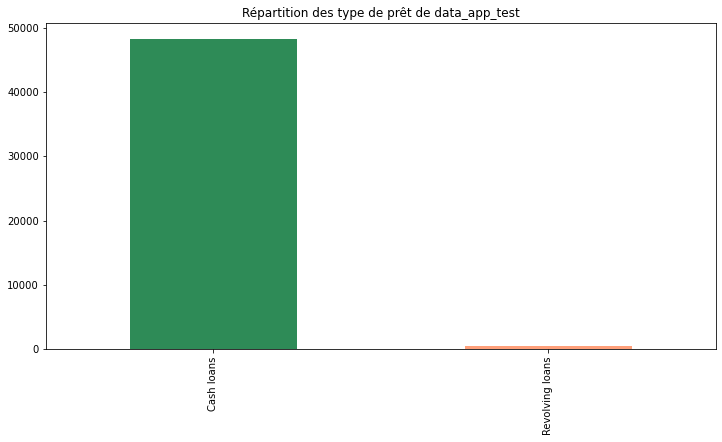

In [51]:
#Affichage de la répartition dans un graphique pour data_app_test
proportion_name_contract_type = data_app_test['NAME_CONTRACT_TYPE'].value_counts()
labels_name_contract_type = proportion_name_contract_type.index
plt.rcParams["figure.figsize"] = (12, 6)
proportion_name_contract_type.plot(kind='bar',x='Types de prêt', y='Nombre de prêts',
                                            color=['seagreen', 'lightsalmon'])
plt.title("Répartition des type de prêt de data_app_test")
plt.show()

Nous allons maintenant voir la répartition homme/femme dans la variable CODE_GENDER

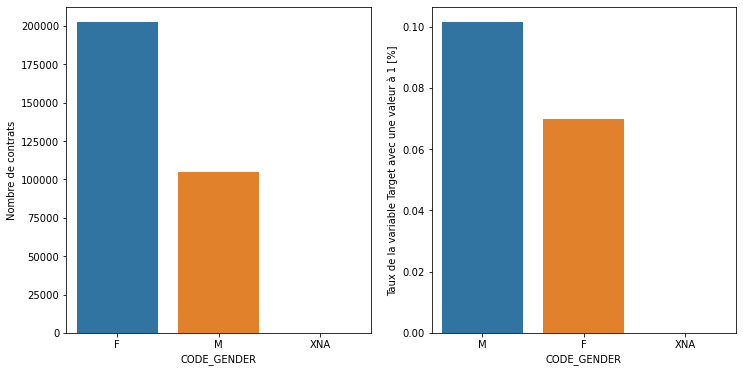

In [52]:
#Affichage de la répartition dans un graphique
plot_stats('CODE_GENDER')

Lorsque l'on regarde le graphique des genre, on peut voir que le sexe féminin emprunte plus que le sexe masculin et possède un meilleur taux de remboursement.

Nous allons maintenant voir la répartition des clients qui possèdent leur propre voiture

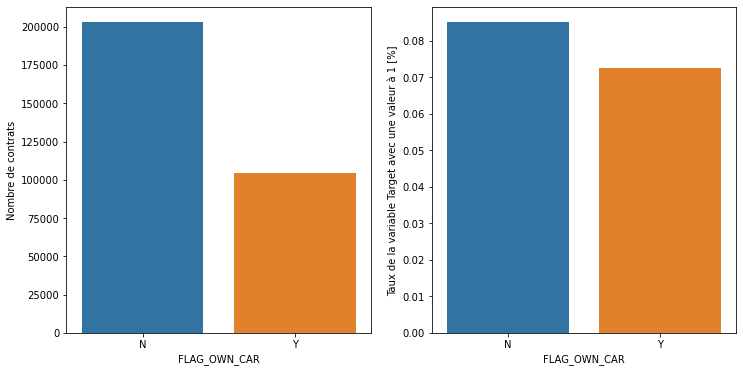

In [53]:
#Affichage de la répartition dans un graphique
plot_stats('FLAG_OWN_CAR')

Les clients qui empruntent ont principalement un véhicule et sont un peu moins en défaut de paiement.

Nous allons maintenant voir la répartition des clients qui possèdent leur propre bien immobilier

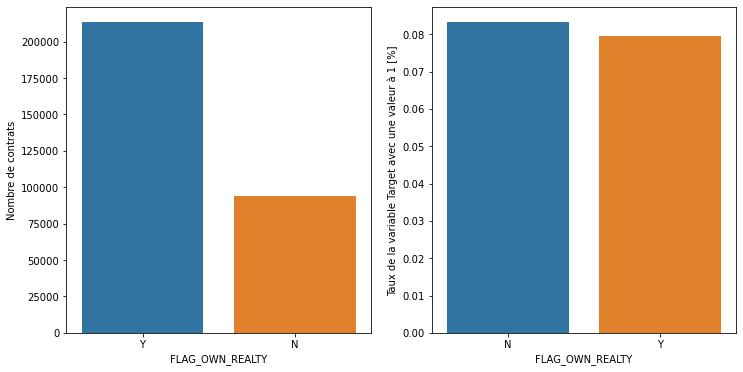

In [54]:
#Affichage de la répartition dans un graphique
plot_stats('FLAG_OWN_REALTY')

Les clients qui empruntent ont principalement un bien immobilier mais cela n'a pas un impact significatif sur le fait d'être en défaut de paiement.

Traitement de la variable concernant le régime matrimonial.

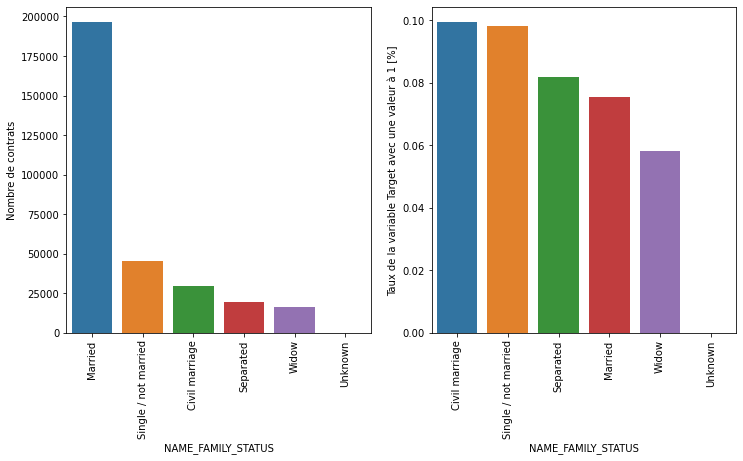

In [55]:
#Affichage de la répartition dans un graphique
plot_stats('NAME_FAMILY_STATUS',True, True)

On retrouve principalement des couples mariés, en union libres ou encore des célibataires. Il s'agit des mêmes catégories que l'on constate concernant celles où l'on retrouve le plus de défaut de paiement.

Traitement de la variable concernant le nombre d'enfants que possèdent les clients.

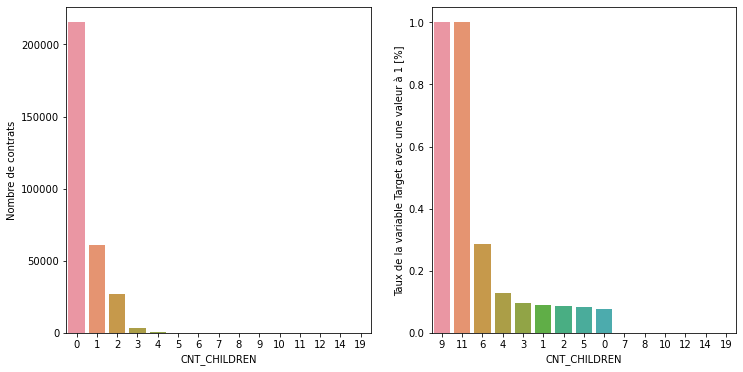

In [56]:
#Affichage de la répartition dans un graphique
plot_stats('CNT_CHILDREN')

Les clients qui empruntent sont principalement des personnes qui ont pas ou très peu d'enfants. A contrario, nous retrouvons les clients ayant 9 ou 11 enfants dans les emprunts en défaut de paiement. 

Traitement de la variable concernant le nombre de membres de la famille des clients.

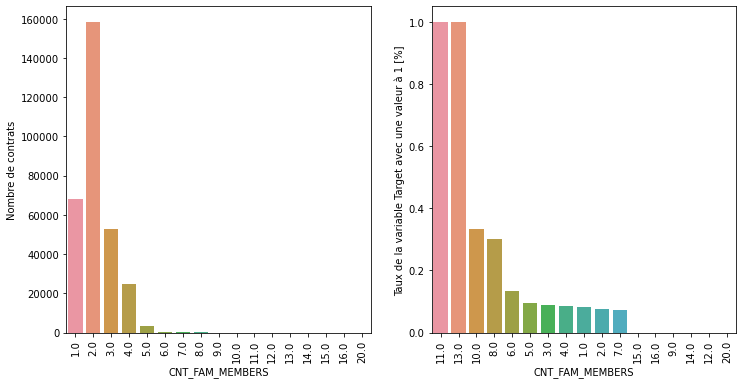

In [57]:
plot_stats('CNT_FAM_MEMBERS',True)

On constate que les familles de 1 à 2 personnes sont les clients qui empruntent le plus et on peut voir que celles avec beaucoup de membres ont plus de difficultés à rembourser leurs emprunts.

Traitement de la variable concernant le type de revenus que possèdent les clients.

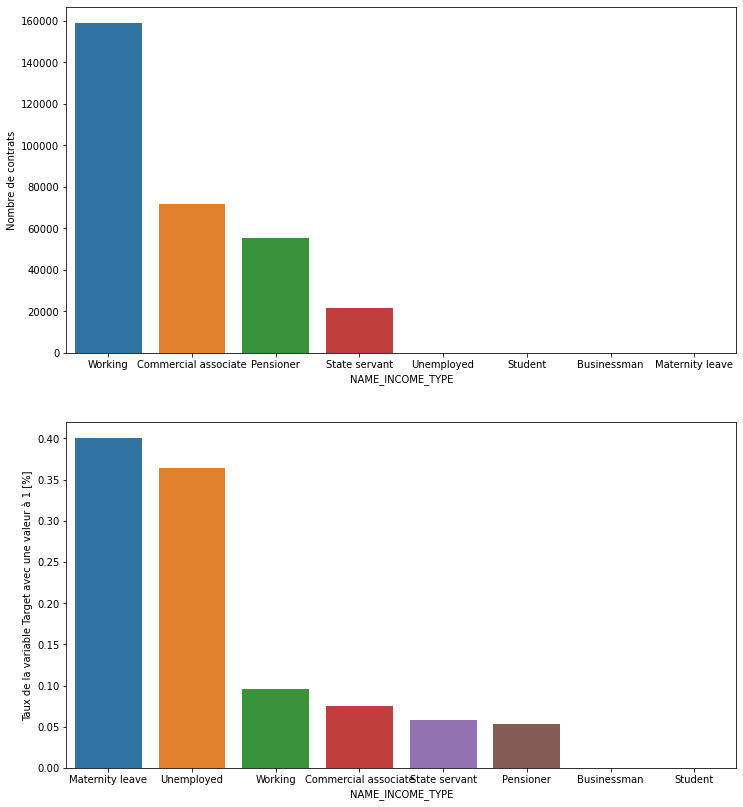

In [58]:
plot_stats('NAME_INCOME_TYPE',False,False)

Les emprunteurs sont principalement des employés alors qu'on retrouve les personnes sans emplois ou en congés maternité pour les emprunteurs en difficulté.

Traitement de la variable concernant le type d'acitivité des clients.

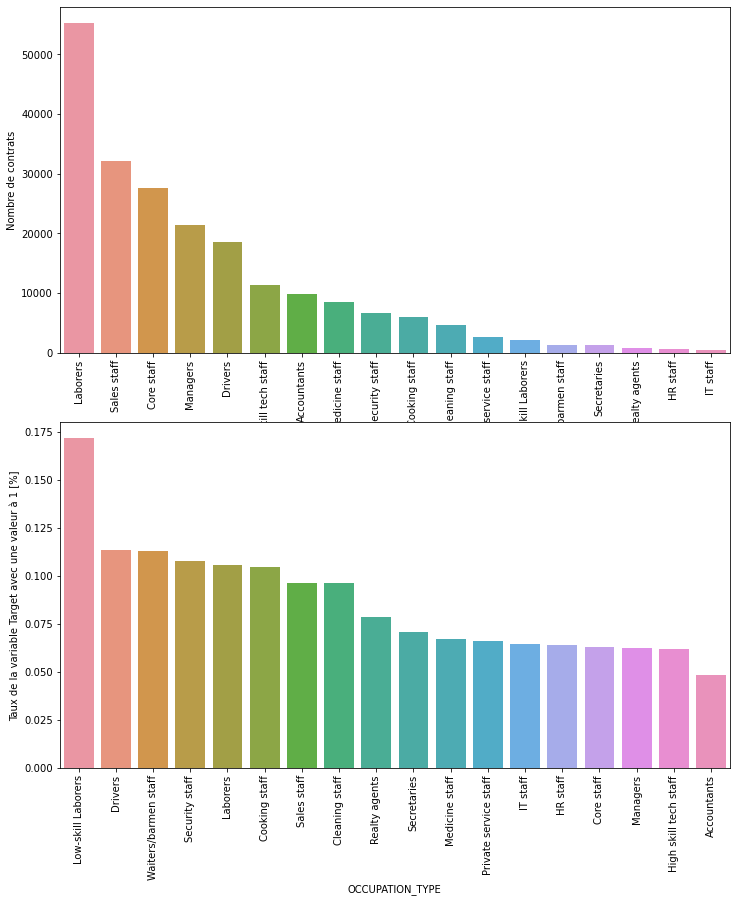

In [59]:
plot_stats('OCCUPATION_TYPE',True, False)

On retrouve principalement la classe ouvrière, les commerciaux et managers du côté des emprunteurs et les ouvriers non qualifiés pour les clients avec le plus de défaut de paiement.

Traitement de la variable concernant le type d'organisation.

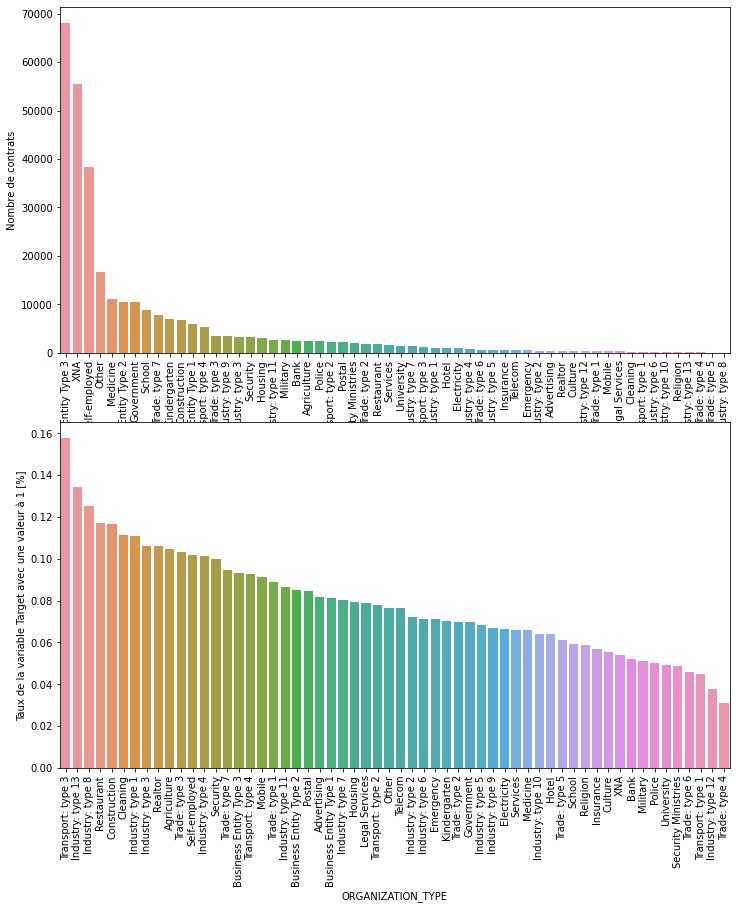

In [60]:
plot_stats('ORGANIZATION_TYPE',True, False)

Ici on a les organisations de Type 3 qui empruntent le plus et point de vue défaut de paiement on a les transport type 3, les inudstries type 3 ou encore les industries type 8.

Traitement de la variable concernant le niveau d'étude des clients.

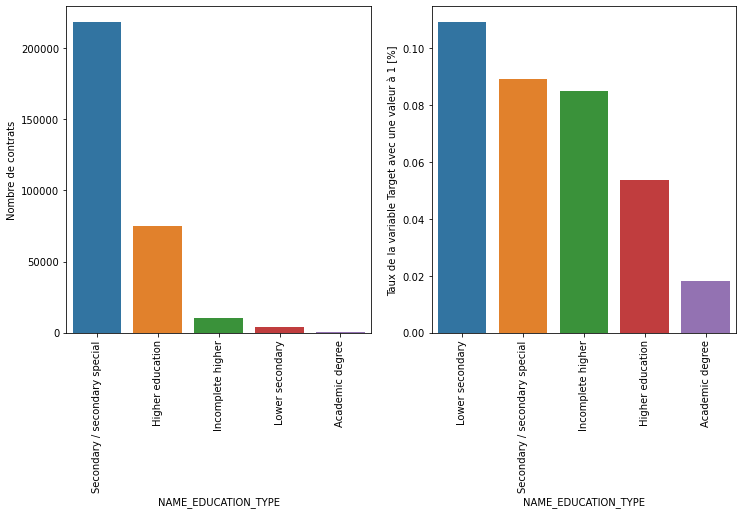

In [61]:
plot_stats('NAME_EDUCATION_TYPE',True)

Les clients qui empruntent ont principalement un niveau BAC et très peu de niveau BAC+5. On a des clients avec un faible niveau d'étude qui ont des difficultés de remboursement.

Traitement de la variable concernant le type d'habitiation des clients.

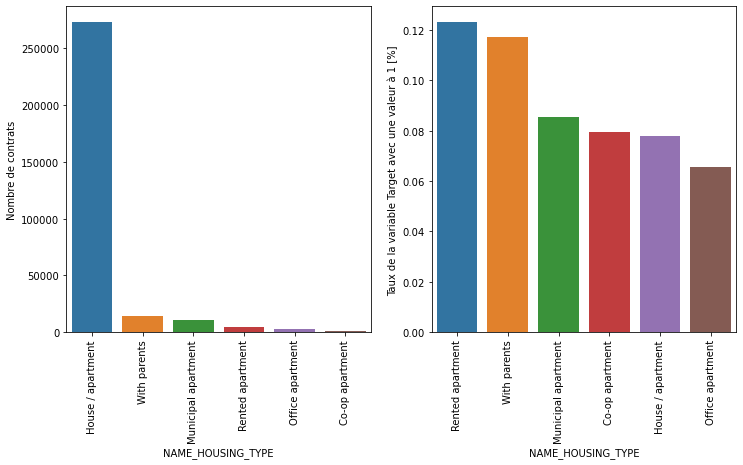

In [62]:
plot_stats('NAME_HOUSING_TYPE',True)

Les clients possèdent princpalement leur bien immobilier (Maison ou appartement) et les personnes qui au contraire louent leur appartement ou encore habitent chez leurs parents ont plus de difficultés à rembourser leur prêt.

Traitement de la variable sur la distribution des revenus à l'aide d'un diagramme de densité.

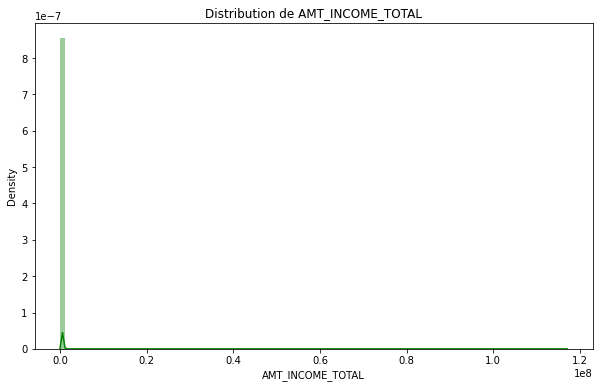

In [63]:
plot_distribution('AMT_INCOME_TOTAL','green')

Traitement de la variable sur la distribution des emprunts à l'aide d'un diagramme de densité.

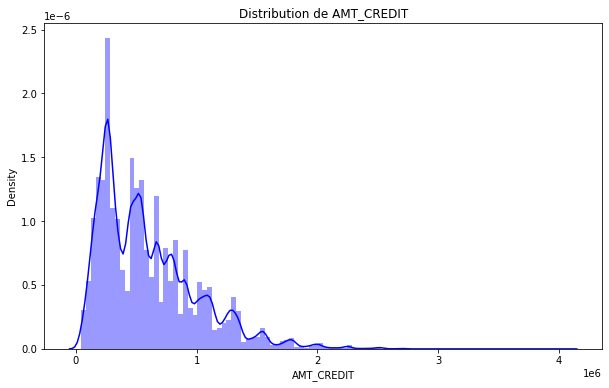

In [64]:
plot_distribution('AMT_CREDIT','blue')

Traitement de la variable sur la distribution des annuités à l'aide d'un diagramme de densité.

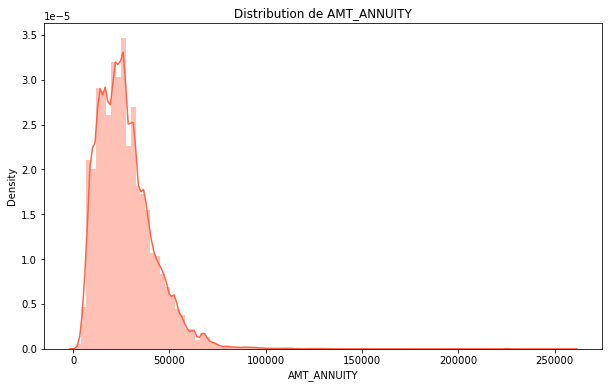

In [65]:
plot_distribution('AMT_ANNUITY','tomato')

Traitement de la variable sur la distribution des montantes des produits à l'aide d'un diagramme de densité.

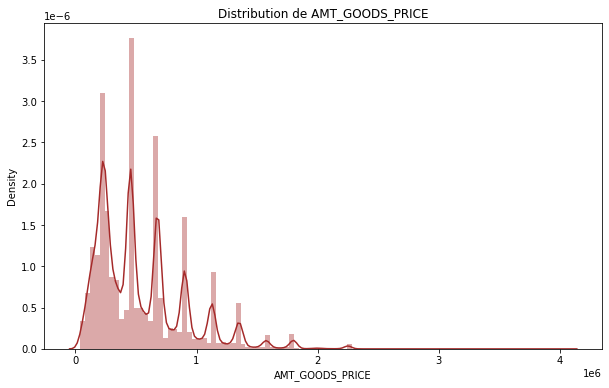

In [66]:
plot_distribution('AMT_GOODS_PRICE','brown')

Traitement de la variable sur la distribution des jours d'anniversaire à l'aide d'un diagramme de densité.

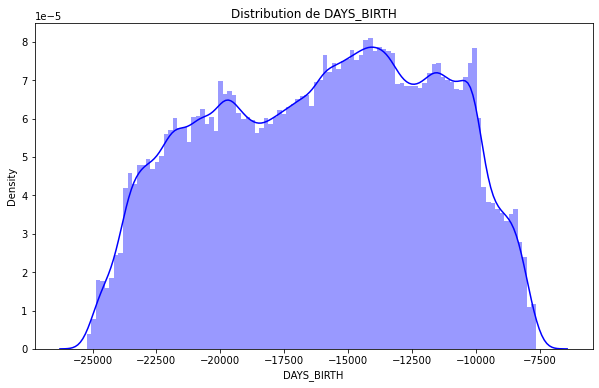

In [67]:
plot_distribution('DAYS_BIRTH','blue')

Nous sommes ici en nombre de jours avec -25000 jours comme une des dates les plus anciennes.

Traitement de la variable sur la distribution des jours travaillés des clients à l'aide d'un diagramme de densité.

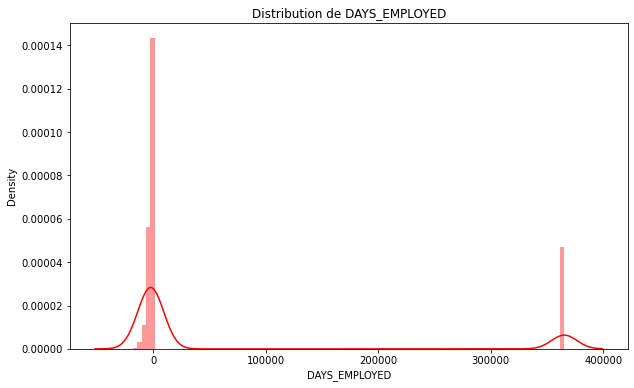

In [68]:
plot_distribution('DAYS_EMPLOYED','red')

Ici on peut penser que la valeur sur le graphique est un outlier vue la distribution et les valeurs négatives représentent les périodes pour lesquelles les clients sont sans emplois.

Traitement de la variable sur la distribution des jours d'inscription à l'aide d'un diagramme de densité.

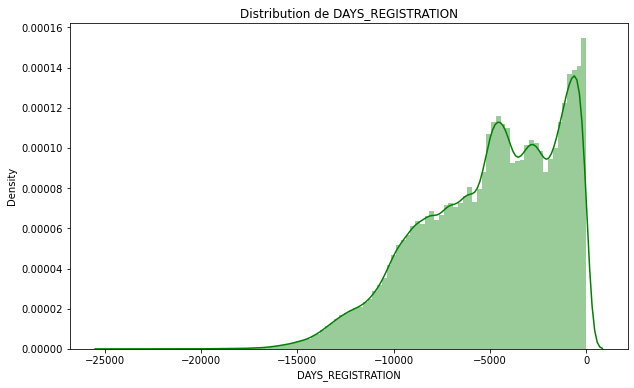

In [69]:
plot_distribution('DAYS_REGISTRATION','green')

Traitement de la variable sur la distribution des jousr de publication des ID à l'aide d'un diagramme de densité.

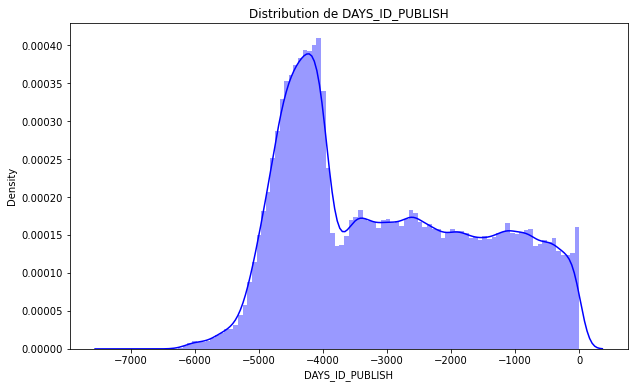

In [70]:
plot_distribution('DAYS_ID_PUBLISH','blue')

Nous allons maintenant comparer plusieurs variables à l'aide de diagramme de densité et voir l'impact des résultats si la variable Target est à 0 ou à 1

<Figure size 864x432 with 0 Axes>

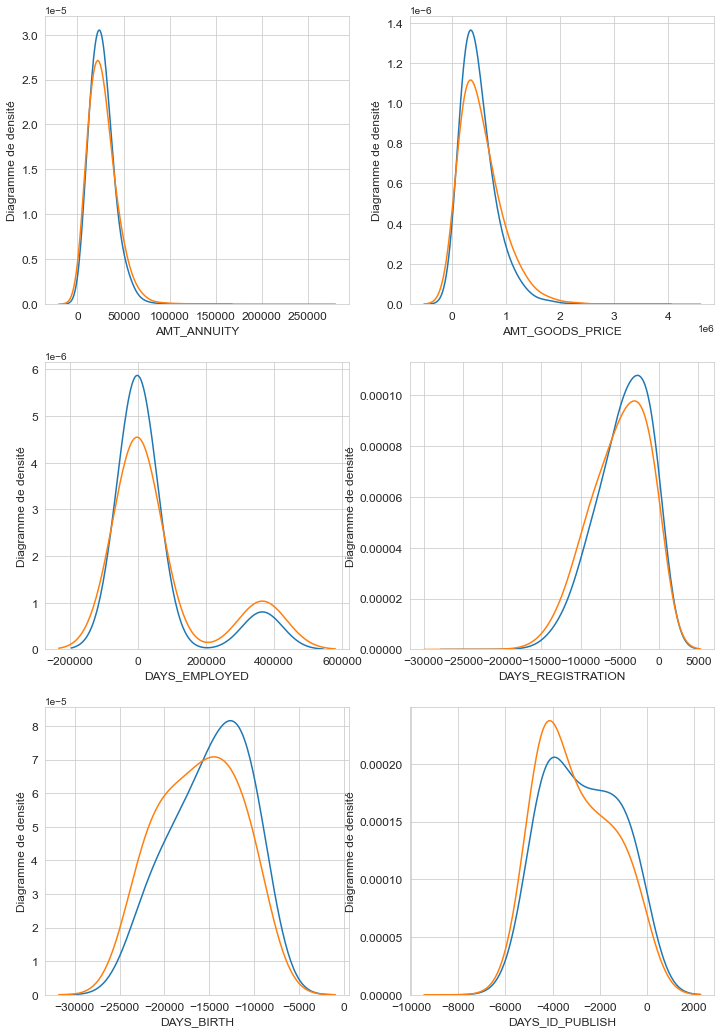

In [71]:
var = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED', 'DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH']
plot_distribution_comp(var,nrow=3)

Traitement de la variable concernant les clients qui n'habitent pas dans la région.

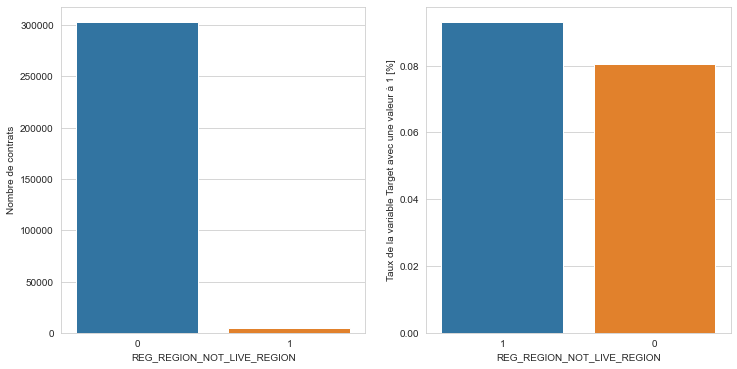

In [72]:
plot_stats('REG_REGION_NOT_LIVE_REGION')

Traitement de la variable concernant les clients qui ne travaillent pas dans la région.

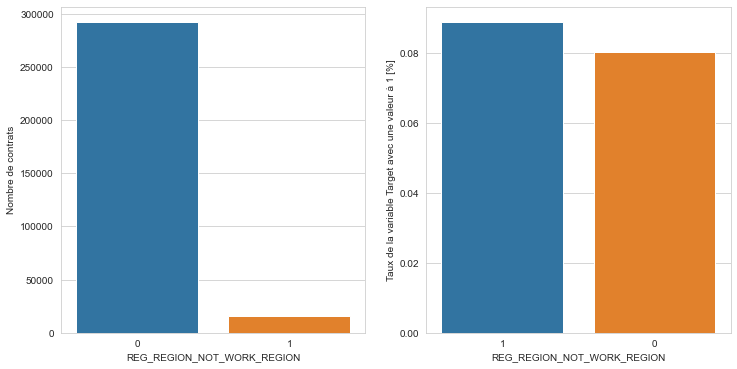

In [73]:
plot_stats('REG_REGION_NOT_WORK_REGION')

Traitement de la variable concernant les clients qui ne travaillent pas dans la ville.

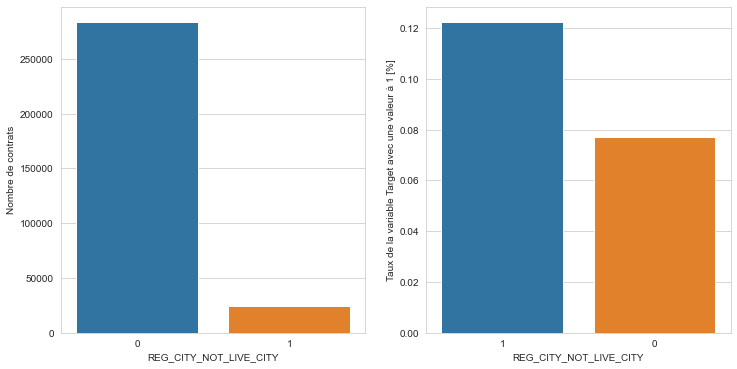

In [74]:
plot_stats('REG_CITY_NOT_LIVE_CITY')

Traitement de la variable concernant les clients qui ne travaillent pas dans la ville.

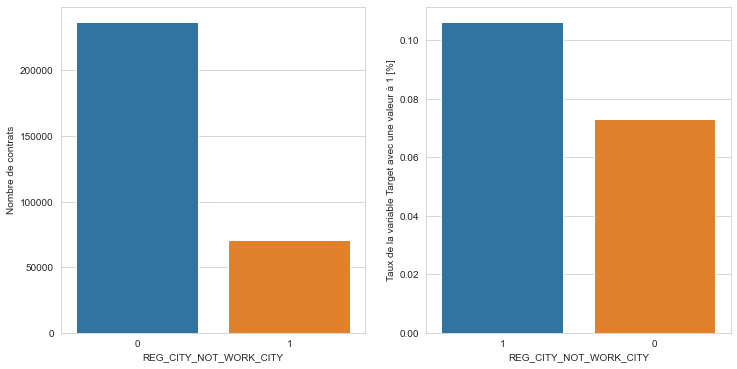

In [75]:
plot_stats('REG_CITY_NOT_WORK_CITY')

On peut voir que les clients habitent principalement dans la région et la ville où ils empruntent mais le lieu de résidence n'a pas spécialement d'impact sur la capacité de remboursement des prêts.

### data_bureau

In [76]:
display(data_bureau.head())

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

On voit que nous avons un lien avec le dataset précédent grâce à la variable SK_ID_CURR.
Nous allons donc les regrouper ensemble.

In [77]:
data_app_bureau_train = data_app_train.merge(data_bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [78]:
print("La fusion des deux datasets nous donne un nouveau dataset de ",data_app_bureau_train.shape[0],
      " lignes et ", data_app_bureau_train.shape[1]," colonnes.")

La fusion des deux datasets nous donne un nouveau dataset de  1465325  lignes et  138  colonnes.


Traitement de la variable de statut des crédits.

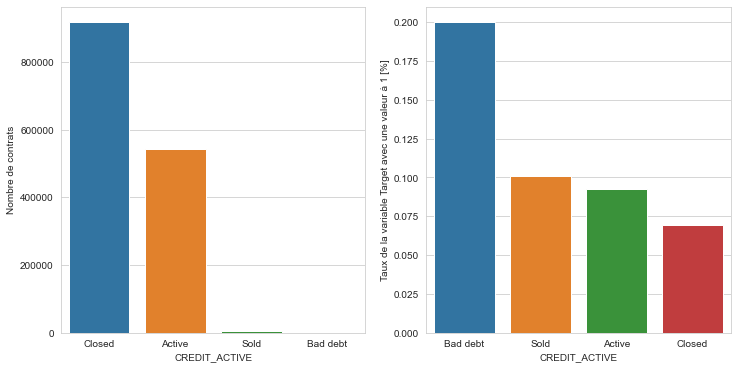

In [79]:
plot_b_stats('CREDIT_ACTIVE')

On peut voir que la plupart des crédits à la conccurrence sont remboursés. On a ensuite des clients avec 600K de crédits actifs, les non remboursés et les mauvais clients (récidivistes). Les récidivistes sont bien les plus mauvais payeurs. On a donc un graphique logique au niveau des profils des clients du plus mauvais payeur au client qui a remboursé son prêt. 

Traitement de la variable de crédits en cours.

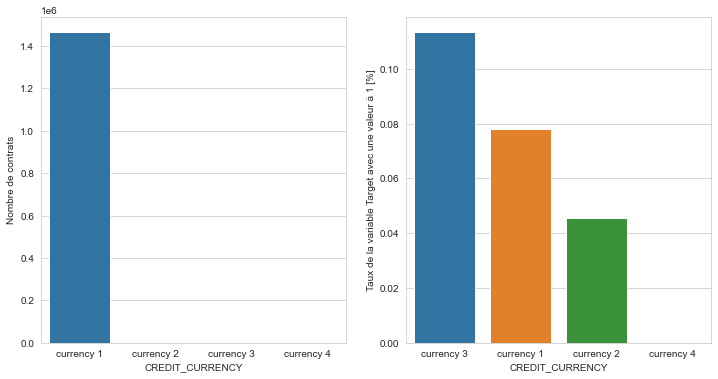

In [80]:
plot_b_stats('CREDIT_CURRENCY')

Les clients ont principalement un crédit en cours et à partir de 3 crédits en cours que l'on retrouve le plus d'anomalie.

Traitement de la variable de type de crédits.

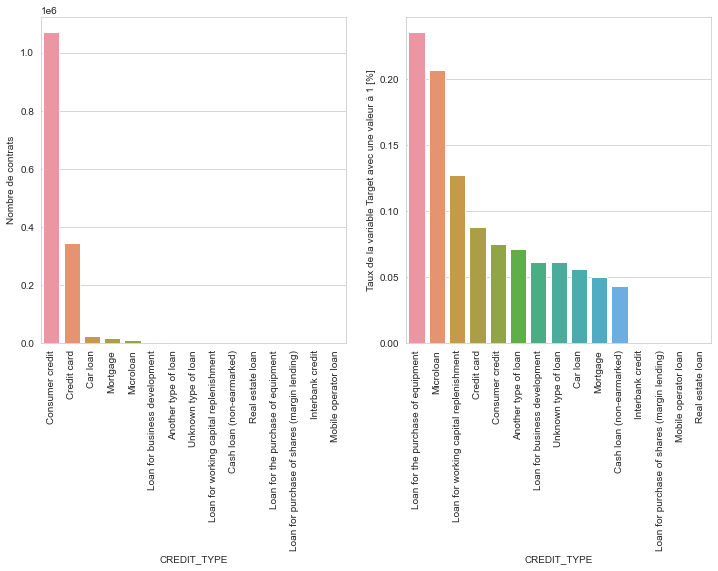

In [81]:
plot_b_stats('CREDIT_TYPE', True, True)

Dans cette variable on trouve principalement des crédits à la consommation et des crédit liés à des cartes bancaires.

Traitement de la variable sur la distribution de la durée des crédits à l'aide d'un diagramme de densité.

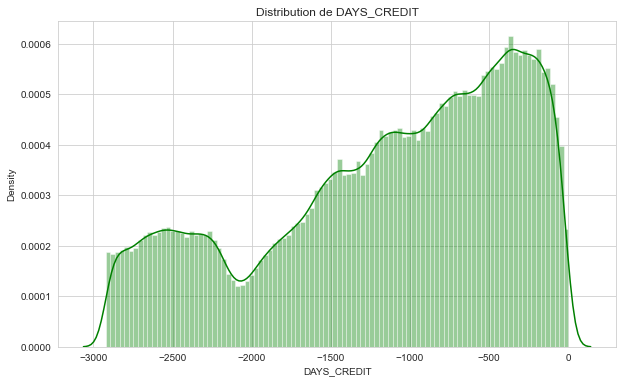

In [82]:
plot_b_distribution('DAYS_CREDIT','green')

On peut voir que la durée des crédits peut aller jusqu'à 3000 jours, sachant que la durée où on a le plus de crédits est aux alentours de 300 jours.

Traitement de la variable sur la distribution des crédits en découvert à l'aide d'un diagramme de densité.

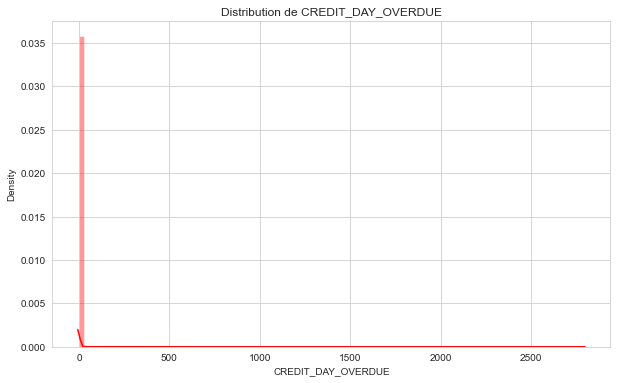

In [83]:
plot_b_distribution('CREDIT_DAY_OVERDUE','red')

Traitement de la variable sur la distribution de la somme des montants de crédits à l'aide d'un diagramme de densité.

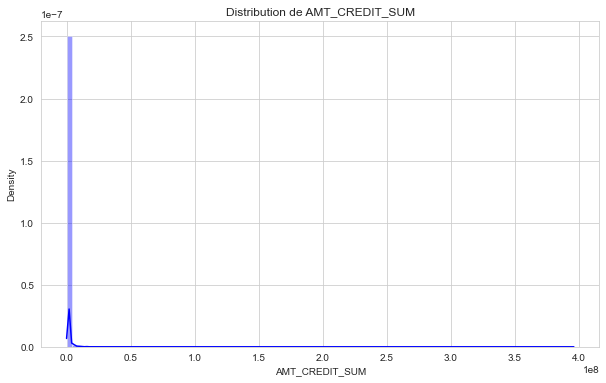

In [84]:
plot_b_distribution('AMT_CREDIT_SUM','blue')

Voyons maintenant ce que donne la distribution lorsque l'on traite les outliers.

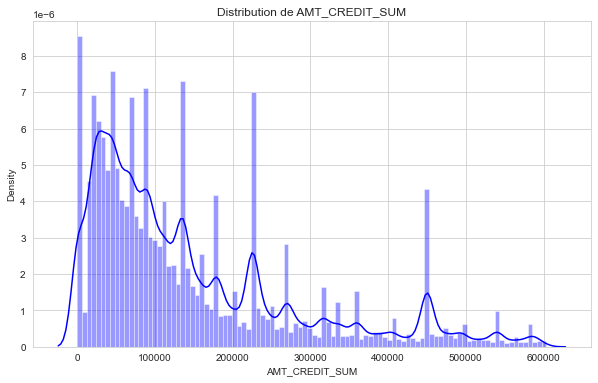

In [87]:
plot_b_o_distribution('AMT_CREDIT_SUM','blue')

Traitement de la variable sur la distribution de la somme des montants de crédits à l'aide d'un diagramme de densité.

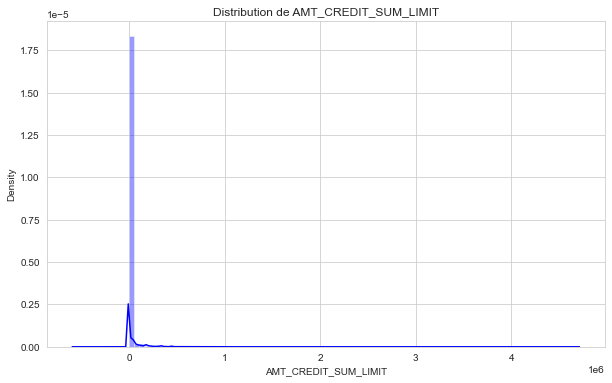

In [88]:
plot_b_distribution('AMT_CREDIT_SUM_LIMIT','blue')

Nous allons maintenant comparer plusieurs variables à l'aide de diagramme de densité et voir l'impact des résultats si la variable Target est à 0 ou à 1

<Figure size 864x432 with 0 Axes>

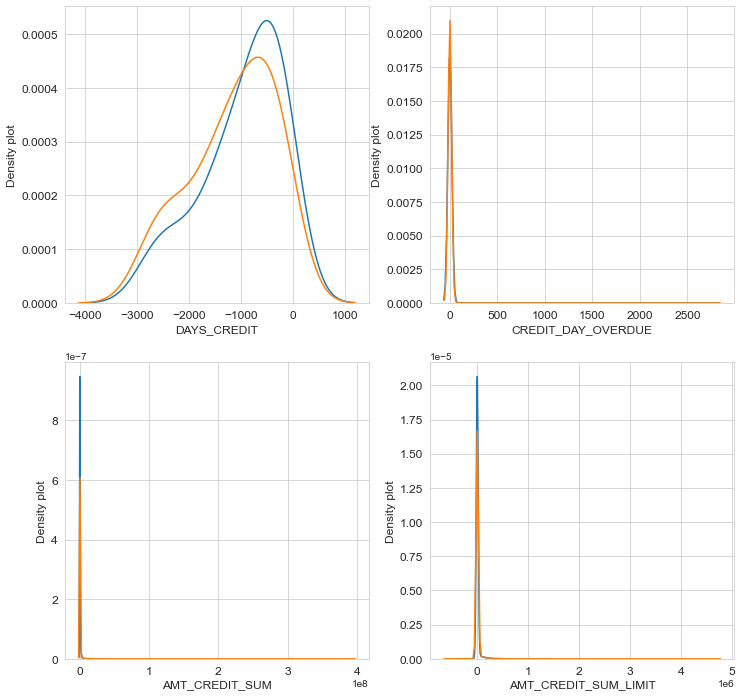

In [89]:
var = ['DAYS_CREDIT','CREDIT_DAY_OVERDUE','AMT_CREDIT_SUM','AMT_CREDIT_SUM_LIMIT']
plot_b_distribution_comp(var, nrow=2)

### data_previous_application

In [90]:
display(data_previous_application.head())

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

On voit que nous avons un lien avec le dataset data_app_train et data_app_test grâce à la variable SK_ID_CURR.
Nous allons donc regrouper ensemble data_app_train et data_previous application.

In [92]:
data_app_previous_train = data_app_train.merge(data_previous_application, left_on='SK_ID_CURR',
                                         right_on='SK_ID_CURR', how='inner')

In [93]:
print("La fusion des deux datasets nous donne un nouveau dataset de ",data_app_previous_train.shape[0],
      " lignes et ", data_app_previous_train.shape[1]," columns.")

La fusion des deux datasets nous donne un nouveau dataset de  1413701  lignes et  158  columns.


Traitement de la variable concernant le type de prêt contracté.

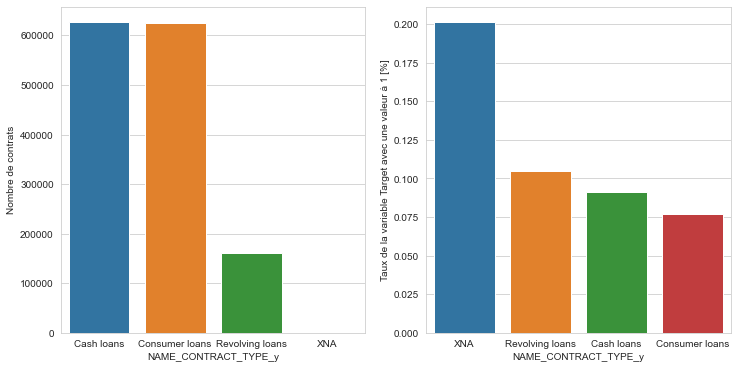

In [98]:
plot_p_stats('NAME_CONTRACT_TYPE_y')

Traitement de la variable concernant l'objet de financement du crédit

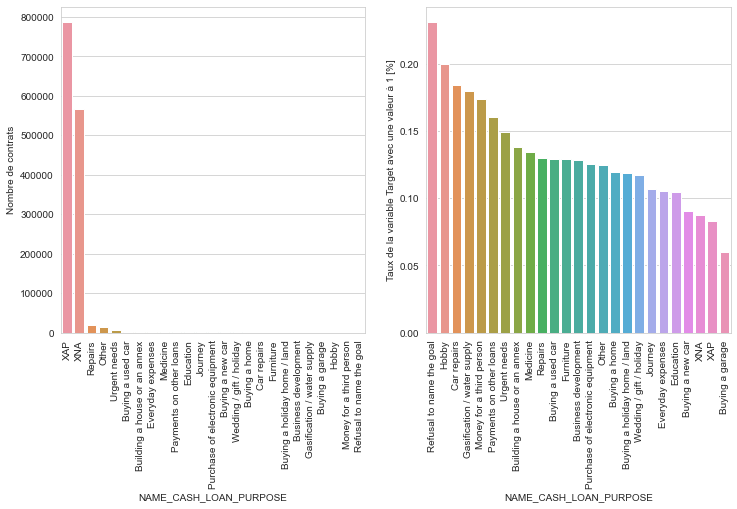

In [99]:
plot_p_stats('NAME_CASH_LOAN_PURPOSE', True, True)

Traitement de la variable concernant le statut du crédit.

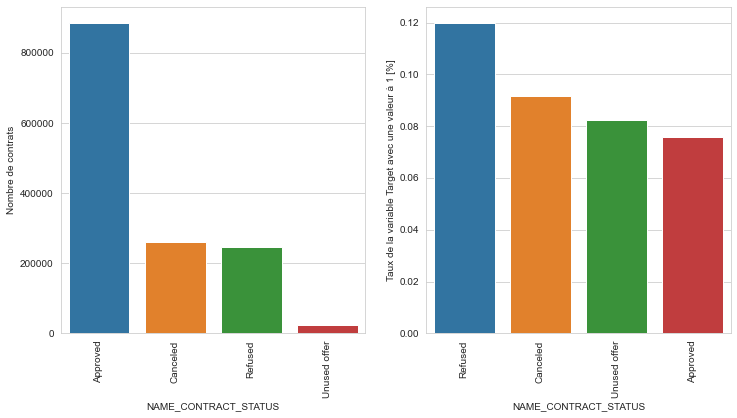

In [100]:
plot_p_stats('NAME_CONTRACT_STATUS', True, True)

Traitement de la variable concernant le type de client.

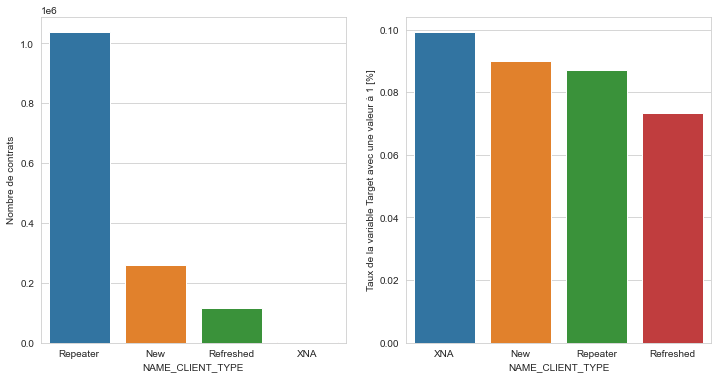

In [101]:
plot_p_stats('NAME_CLIENT_TYPE')

### data_sample_submission

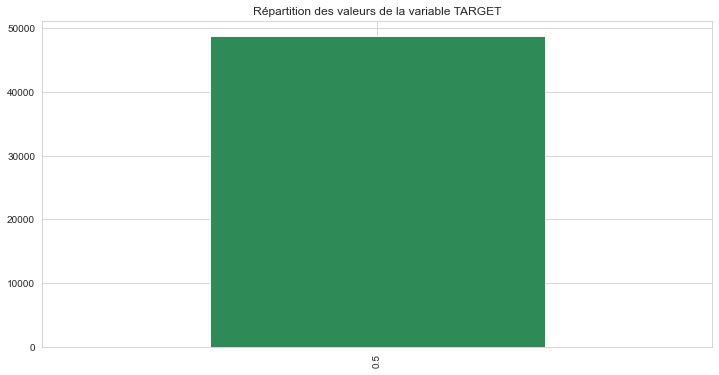

In [163]:
#Affichage de la répartition dans un graphique
proportion_target_sample_submission = data_sample_submission['TARGET'].value_counts() 
labels_target_sample_submission = proportion_target_sample_submission.index
plt.rcParams["figure.figsize"] = (12, 6)
proportion_target_sample_submission.plot(kind='bar',x='Valeur de Target', y='Quantité',
                                         color=['seagreen', 'lightsalmon'])
plt.title("Répartition des valeurs de la variable TARGET")
plt.show()

On peut remarquer que nous avons une valeur unique pour le dataset data_sample_submission.
Il n'est donc pas nécessaire d'aller plus loin dans son étude.

Il n'est pas nécessaire de faire les études des autres datasets (que l'on peut considérer comme des "sous-datasets" des datasets précédents)m car nous sommes principalement en présence de données numériques et donc nous allons plutôt les traiter à travers des matrices de corrélations.

### Matrices de corrélations

On commence par réaliser la matrice de corrélations du dataset data_app_train en prenant en compte les variables numériques dans une liste.

In [110]:
#Liste des valeurs numériques du dataset concernant des informations normalisées sur le bâtiment où habite le client
building_normal_info_list = ['APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
'COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG',
'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE',
'YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE',
'ENTRANCES_MODE','FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI',
'BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI',
'ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI',
'LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE',
'HOUSETYPE_MODE','TOTALAREA_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE' ]

In [111]:
#Création d'un dataset en sélectionnant seulement les variables de data_app_train que l'on trouve dans la liste définit
df = data_app_train[building_normal_info_list]
df['TARGET']= data_app_train['TARGET']

In [112]:
#Afficher du tableau de corrélations
target_correlation(df).head(10)

TARGET                          1.000000
NONLIVINGAPARTMENTS_MODE       -0.001557
NONLIVINGAPARTMENTS_MEDI       -0.002757
NONLIVINGAPARTMENTS_AVG        -0.003176
YEARS_BEGINEXPLUATATION_MODE   -0.009036
YEARS_BEGINEXPLUATATION_AVG    -0.009728
YEARS_BEGINEXPLUATATION_MEDI   -0.009993
LANDAREA_MODE                  -0.010174
LANDAREA_AVG                   -0.010885
LANDAREA_MEDI                  -0.011256
Name: TARGET, dtype: float64

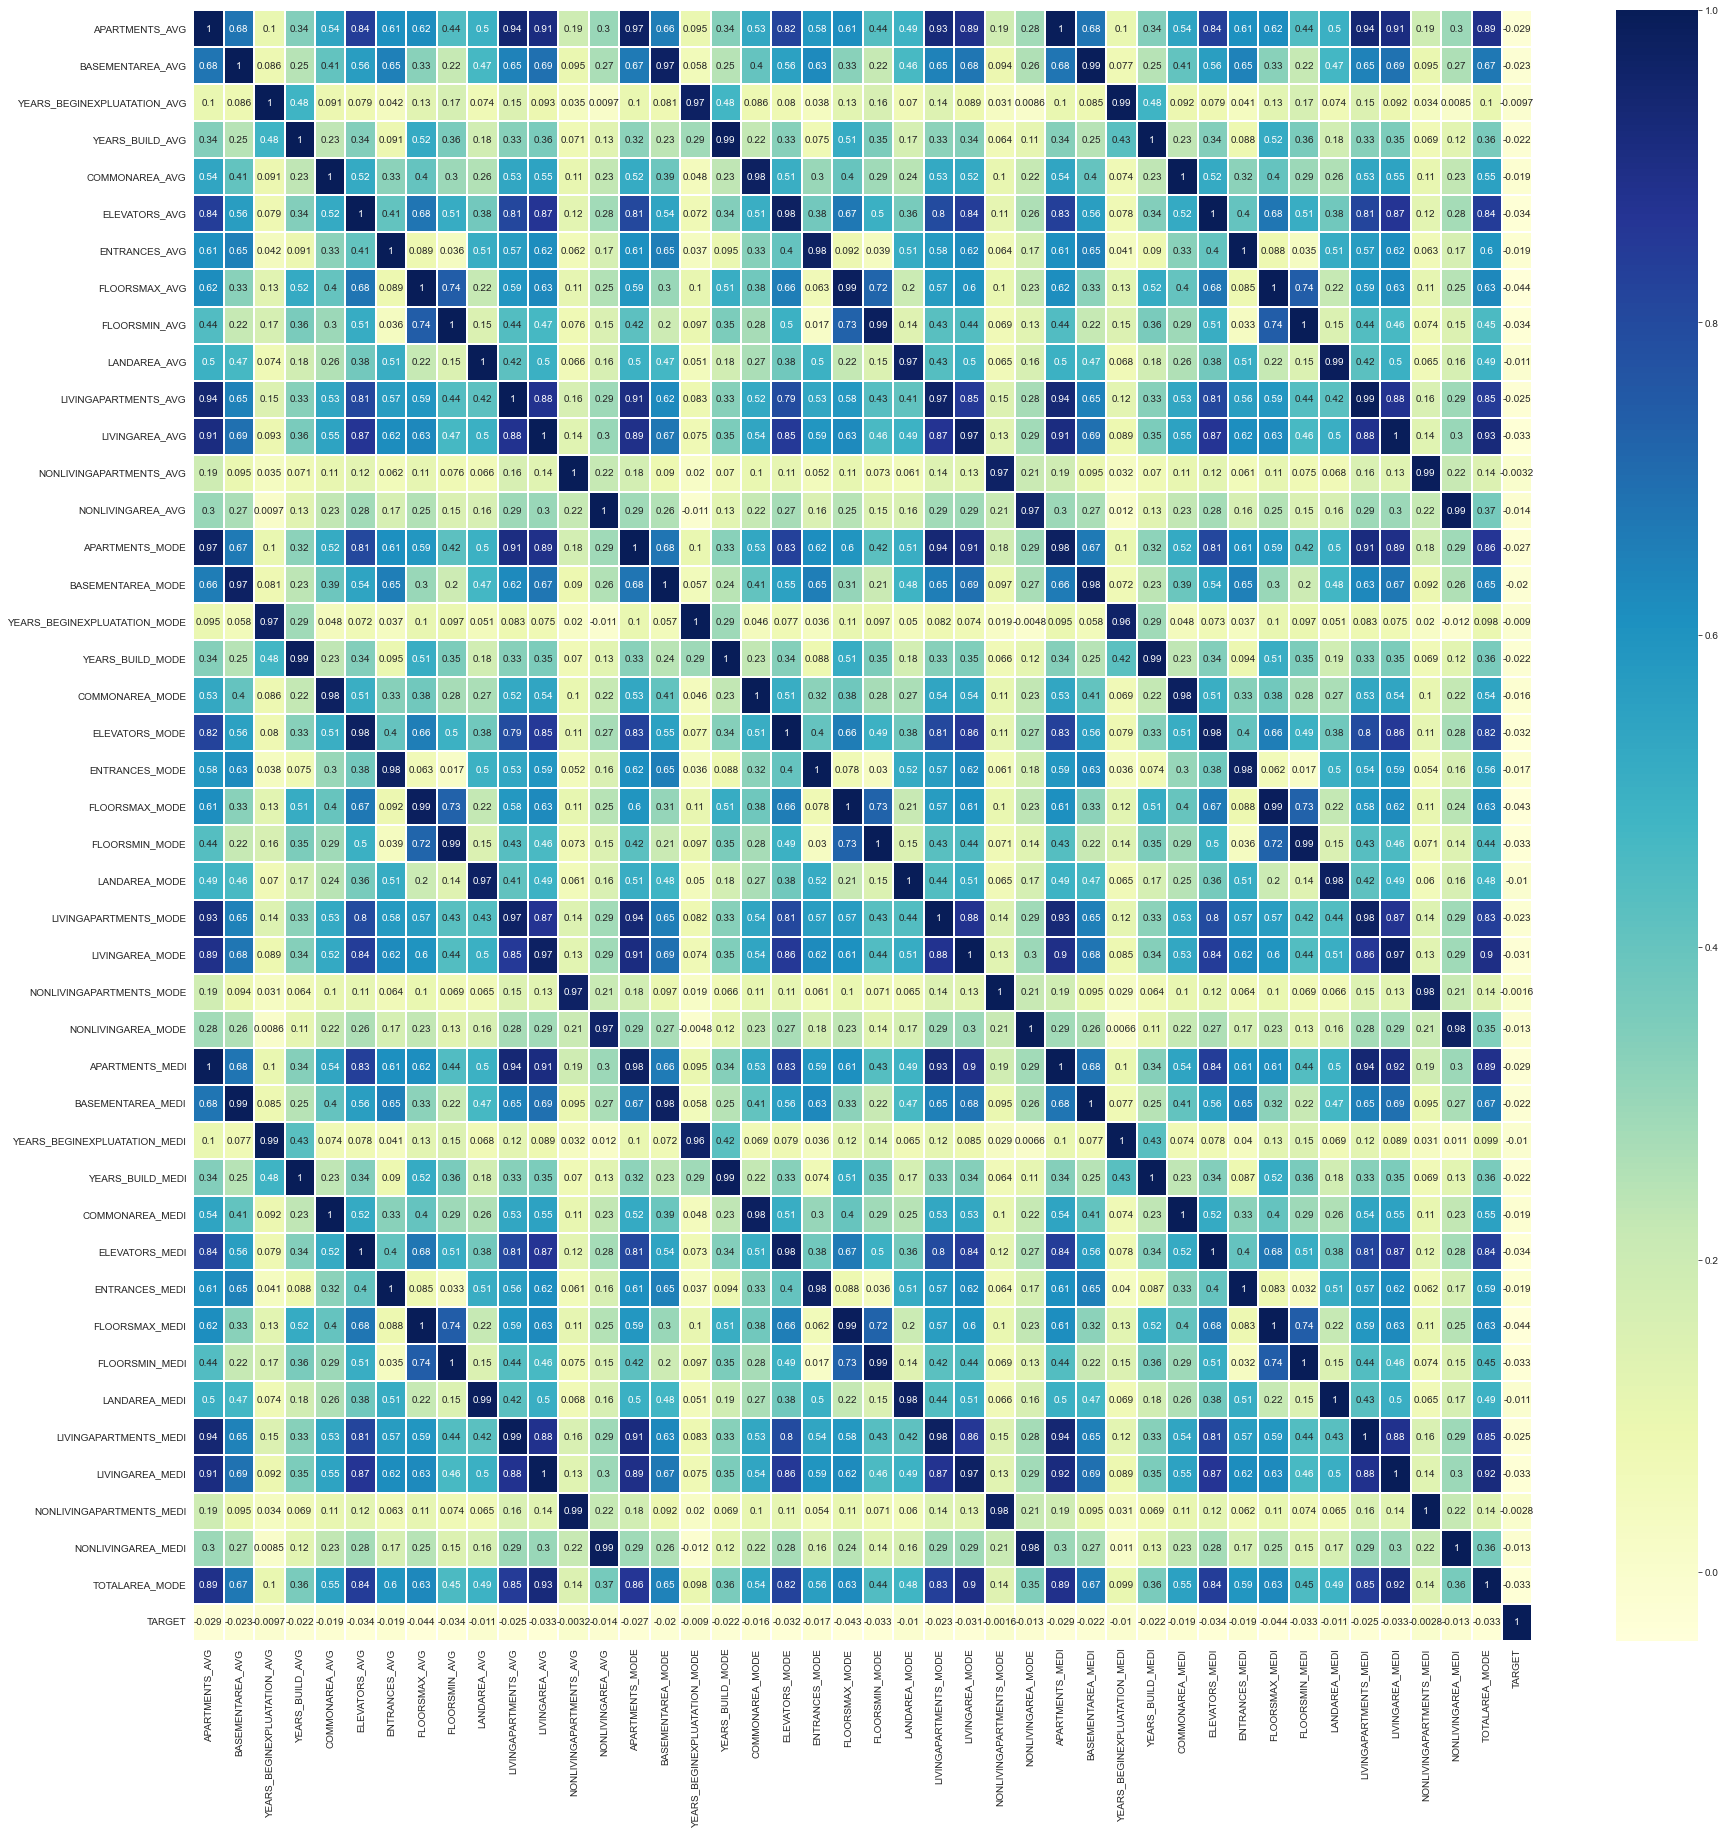

In [113]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

In [114]:
#Liste des valeurs numériques du dataset concernant la fourniture de documents spécifiques numérotés de 2 à 21
die_client_doc = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6',
'FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12',
'FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18',
'FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']

In [115]:
#Création d'un dataset en sélectionnant seulement les variables de data_app_train que l'on trouve dans la liste définit
df = data_app_train[die_client_doc]
df['TARGET']= data_app_train['TARGET']

In [116]:
#Afficher du tableau de corrélations
target_correlation (df).head(10)

TARGET              1.000000
FLAG_DOCUMENT_3     0.044346
FLAG_DOCUMENT_2     0.005417
FLAG_DOCUMENT_21    0.003709
FLAG_DOCUMENT_20    0.000215
FLAG_DOCUMENT_5    -0.000316
FLAG_DOCUMENT_12   -0.000756
FLAG_DOCUMENT_19   -0.001358
FLAG_DOCUMENT_10   -0.001414
FLAG_DOCUMENT_7    -0.001520
Name: TARGET, dtype: float64

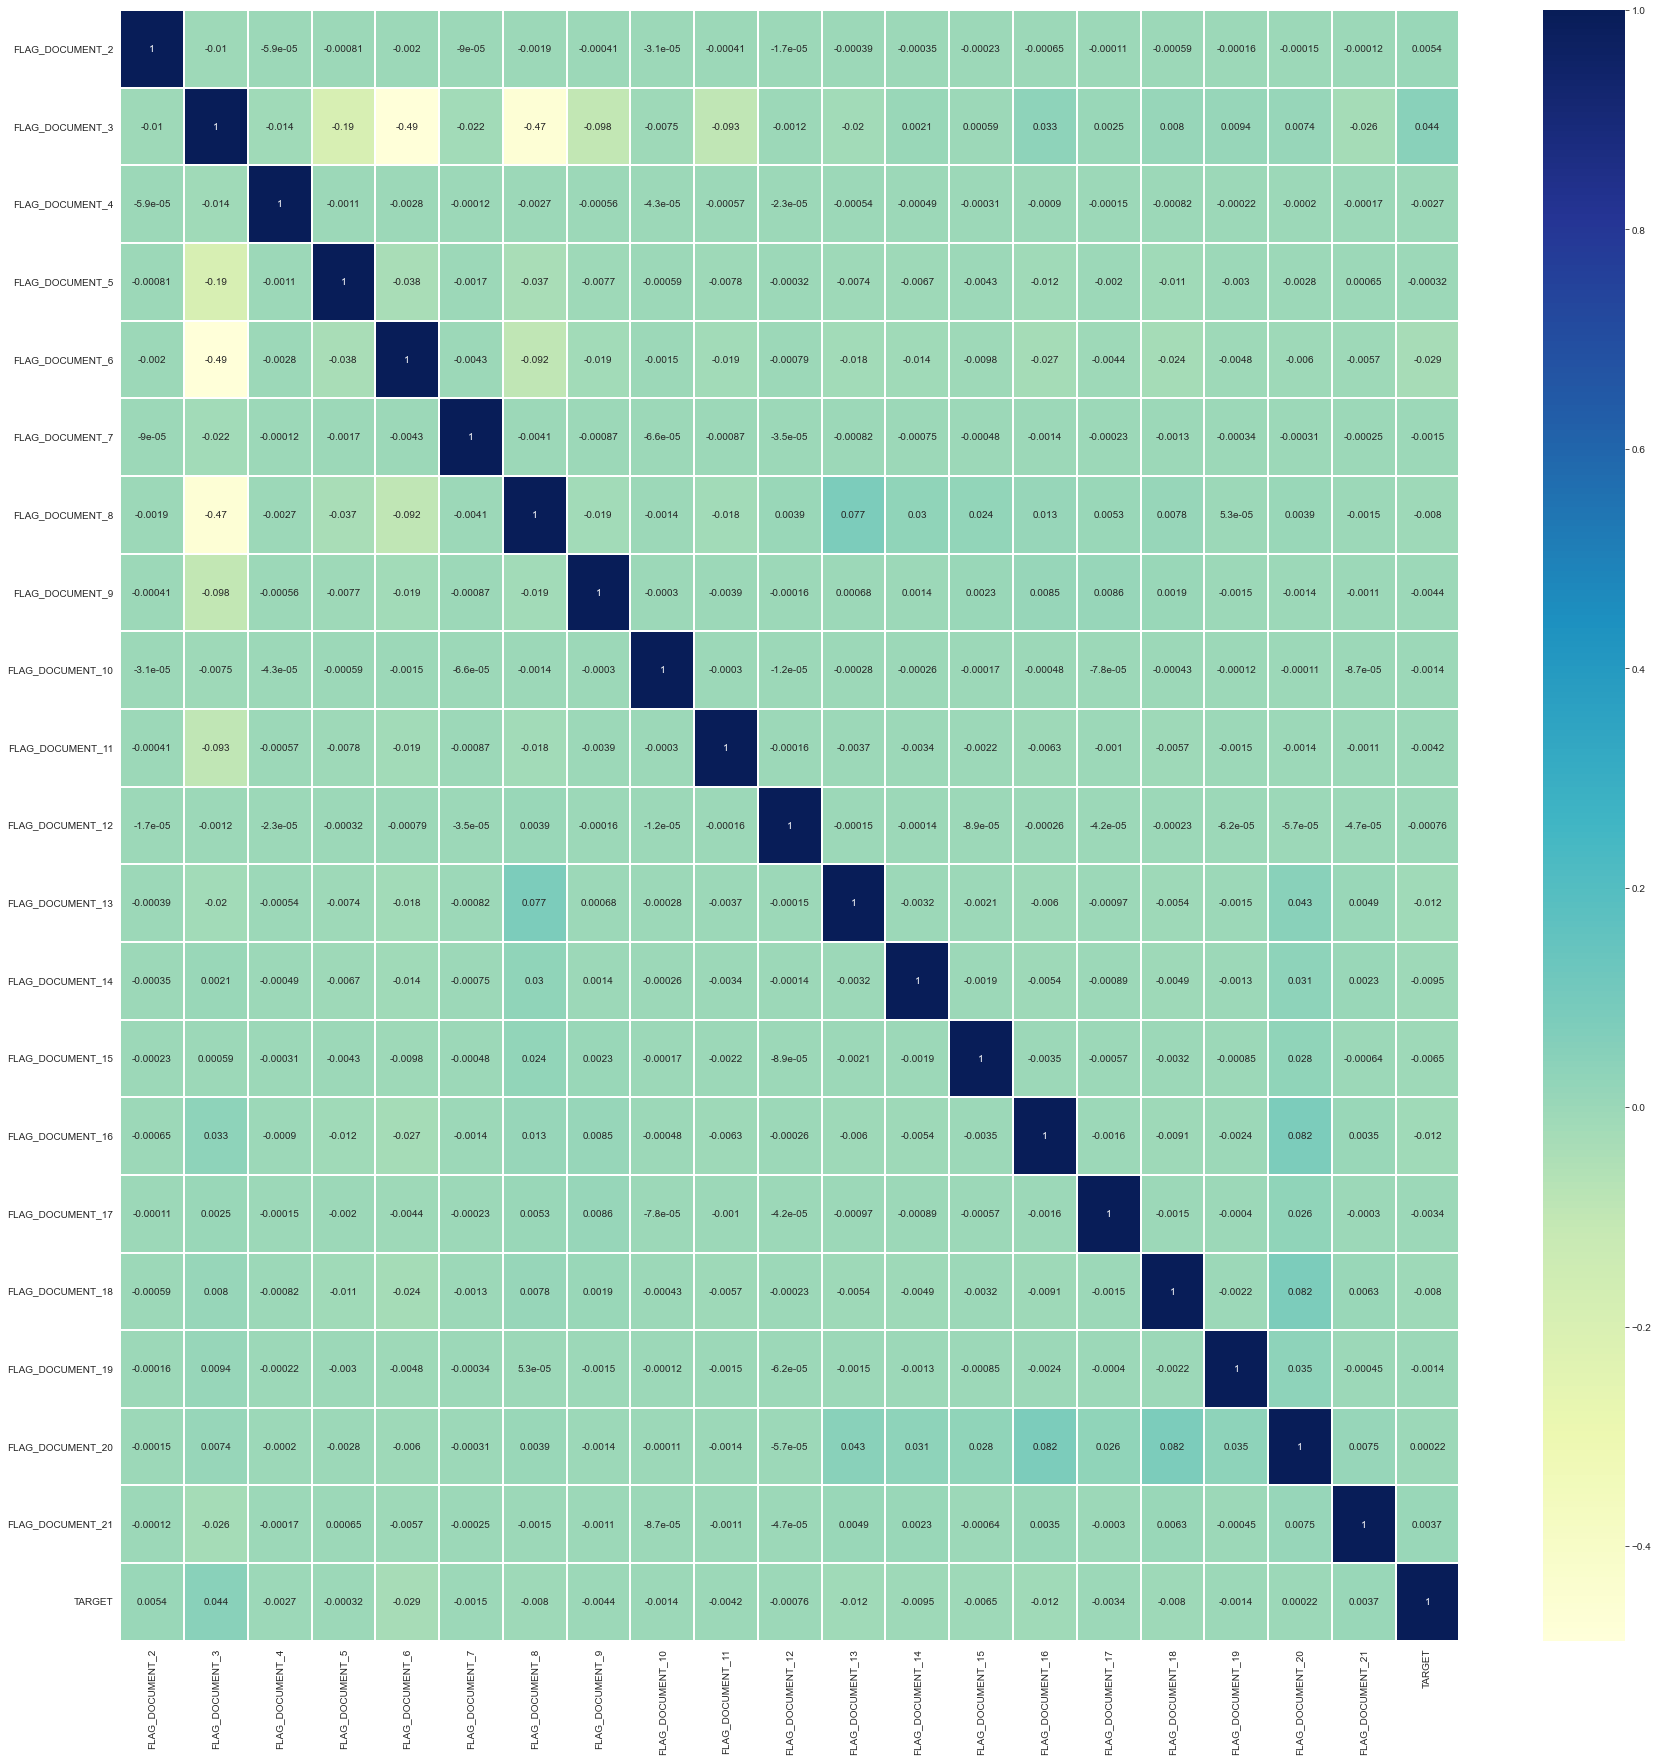

In [117]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

In [118]:
#Liste des valeurs numériques du dataset concernant des demandes de renseignements auprès du bureau de crédit au sujet du client
AMT_REQ_CREDIT_BUREAU_list = ['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']

In [119]:
#Création d'un dataset en sélectionnant seulement les variables de data_app_train que l'on trouve dans la liste définit
df = data_app_train[AMT_REQ_CREDIT_BUREAU_list]
df['TARGET']= data_app_train['TARGET']

In [120]:
#Afficher du tableau de corrélations
target_correlation (df).head(10)

TARGET                        1.000000
AMT_REQ_CREDIT_BUREAU_YEAR    0.019930
AMT_REQ_CREDIT_BUREAU_DAY     0.002704
AMT_REQ_CREDIT_BUREAU_HOUR    0.000930
AMT_REQ_CREDIT_BUREAU_WEEK    0.000788
AMT_REQ_CREDIT_BUREAU_QRT    -0.002022
AMT_REQ_CREDIT_BUREAU_MON    -0.012462
Name: TARGET, dtype: float64

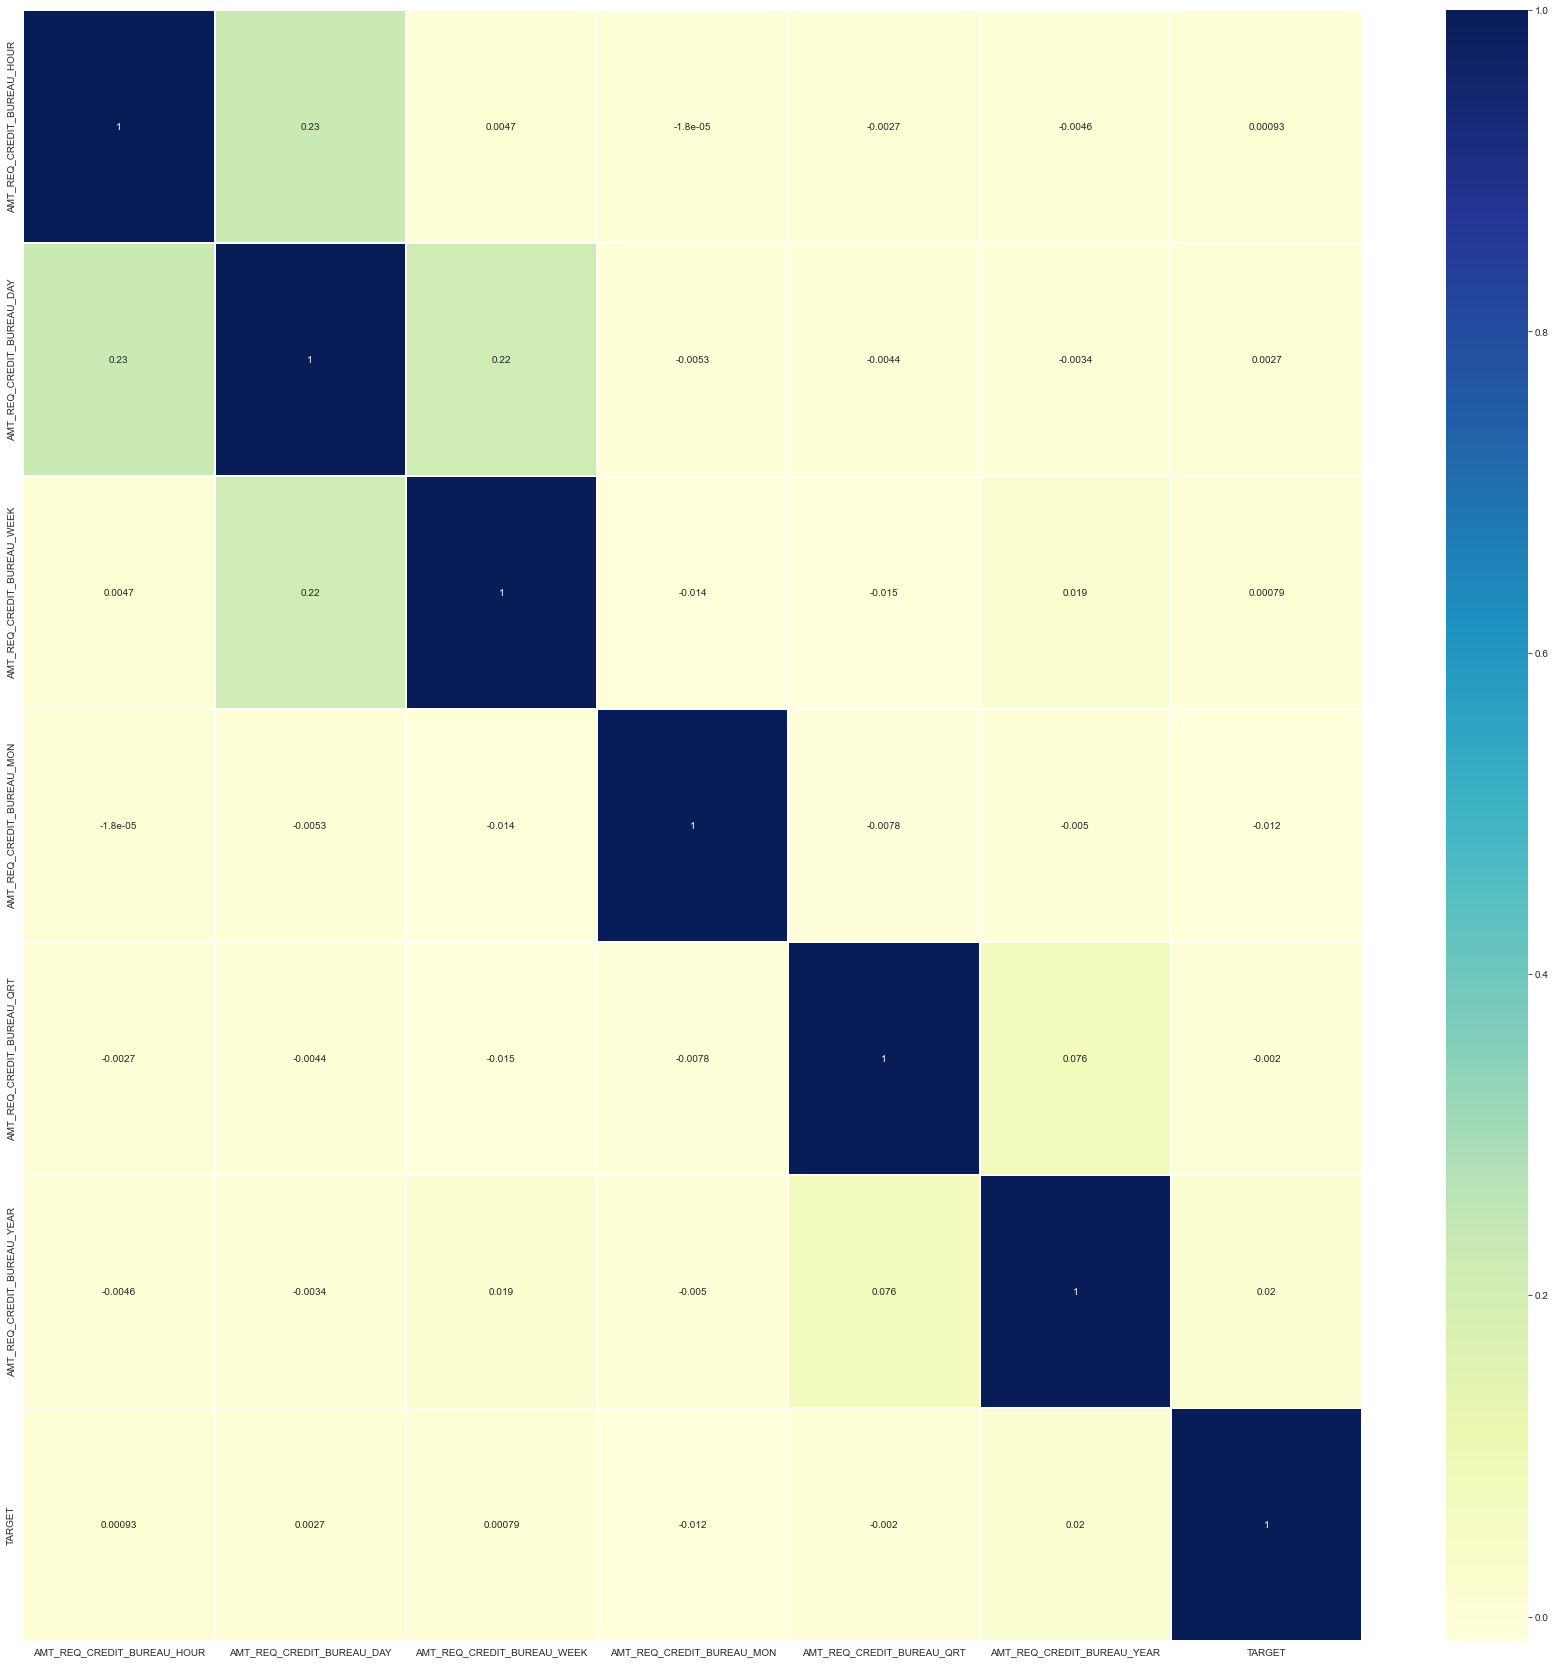

In [121]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

In [122]:
#Liste des valeurs numériques du dataset concernant le nombre d'observations de l'environnement social des clients
social_surroundings_list = ['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE',
                            'DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE']

In [123]:
#Création d'un dataset en sélectionnant seulement les variables de data_app_train que l'on trouve dans la liste définit
df = data_app_train[social_surroundings_list]
df['TARGET']= data_app_train['TARGET']

In [124]:
#Afficher du tableau de corrélations
target_correlation (df).head(10)

TARGET                      1.000000
DAYS_LAST_PHONE_CHANGE      0.055218
DEF_30_CNT_SOCIAL_CIRCLE    0.032248
DEF_60_CNT_SOCIAL_CIRCLE    0.031276
OBS_30_CNT_SOCIAL_CIRCLE    0.009131
OBS_60_CNT_SOCIAL_CIRCLE    0.009022
Name: TARGET, dtype: float64

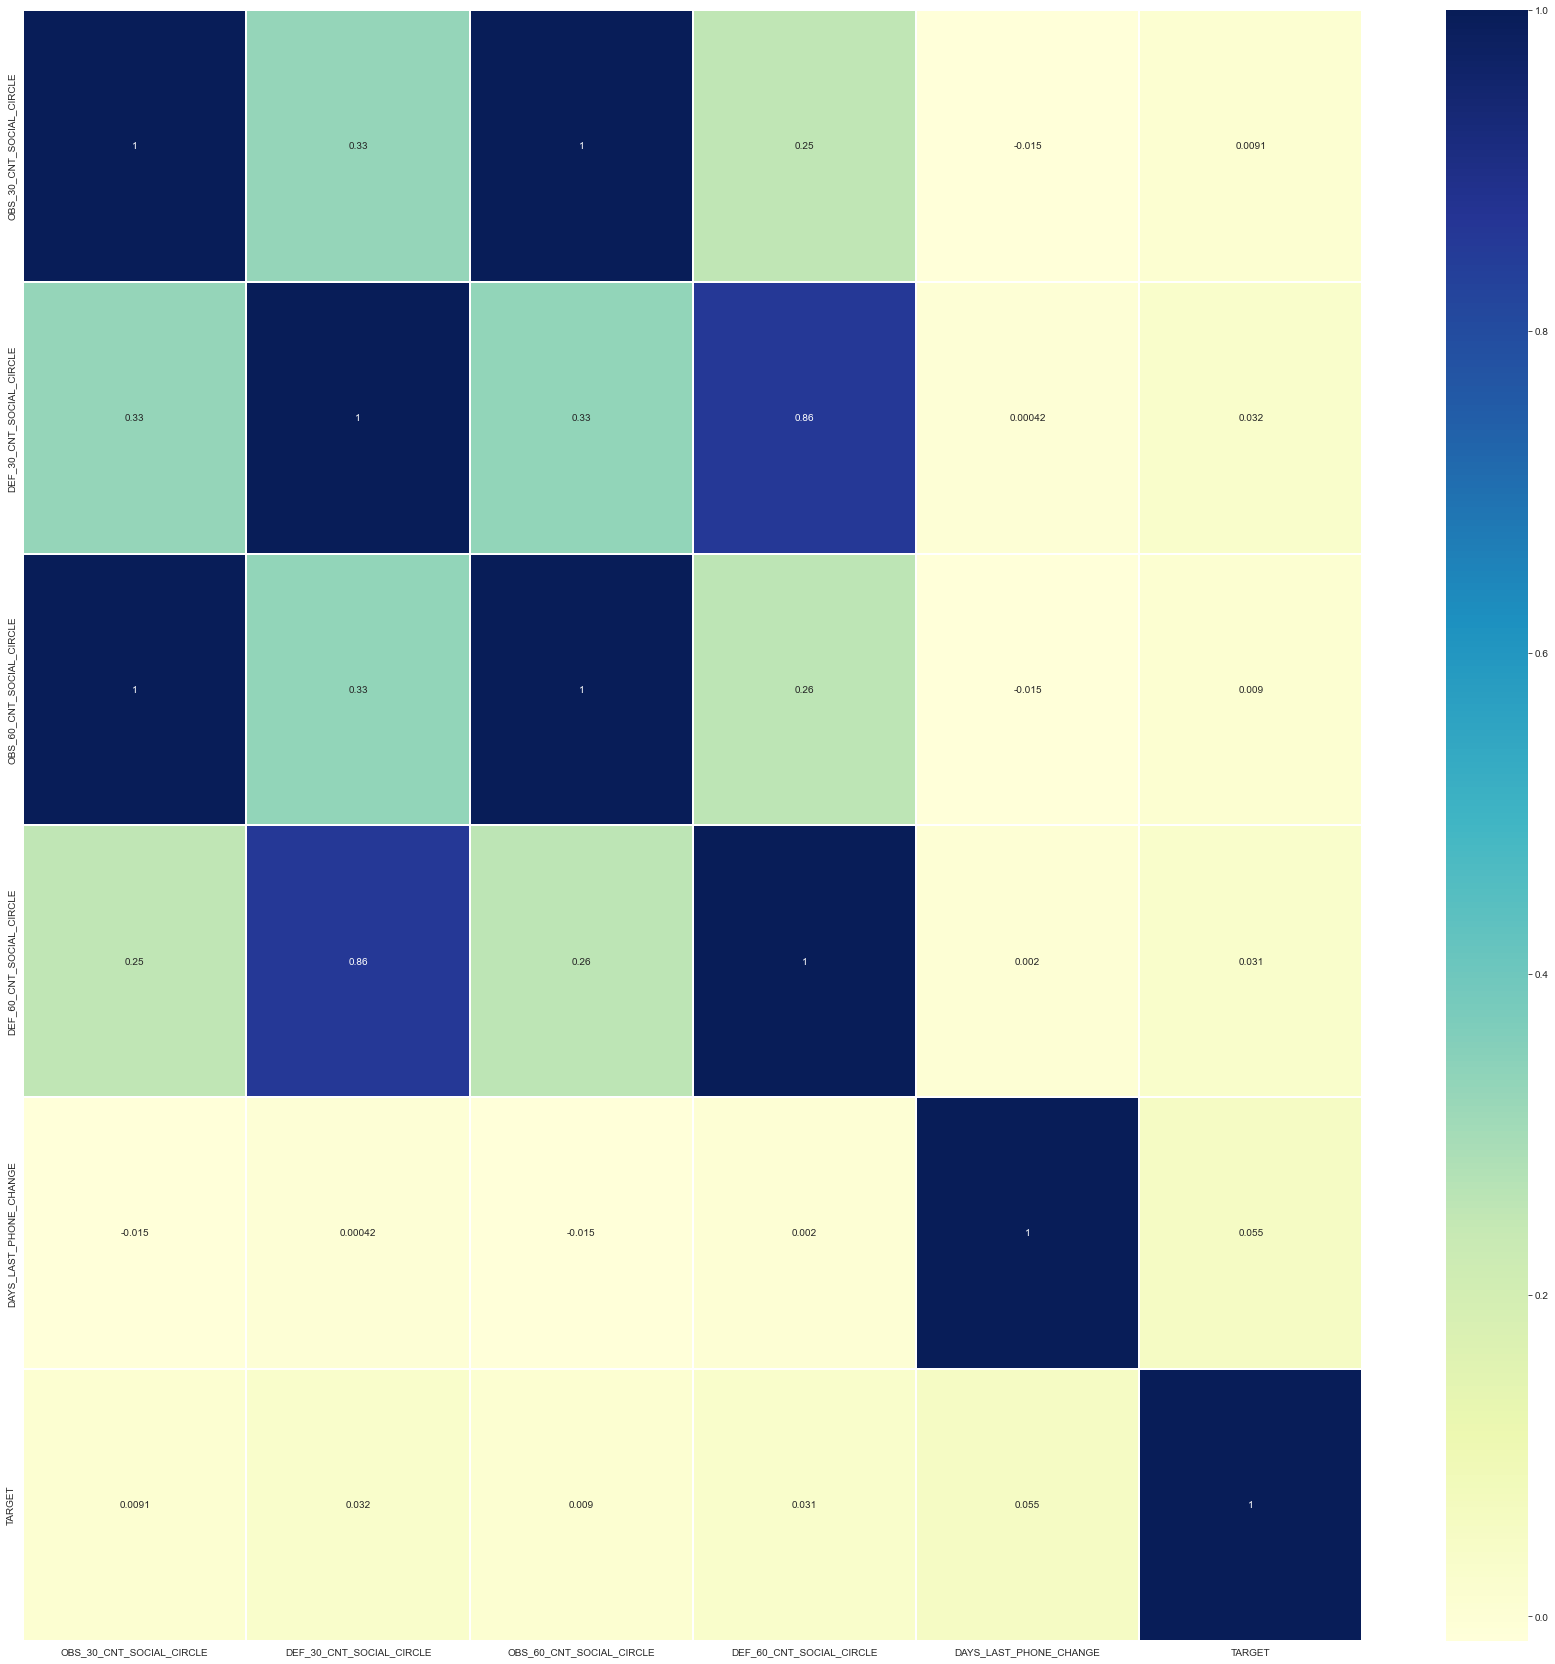

In [125]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

In [126]:
#Liste des valeurs numériques du dataset concernant des scores normalisés à partir d'une source de données normalisée
external_score_list = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

In [127]:
#Création d'un dataset en sélectionnant seulement les variables de data_app_train que l'on trouve dans la liste définit
df = data_app_train[external_score_list]
df['TARGET']= data_app_train['TARGET']

In [128]:
#Afficher du tableau de corrélations
target_correlation (df).head(10)

TARGET          1.000000
EXT_SOURCE_1   -0.155317
EXT_SOURCE_2   -0.160472
EXT_SOURCE_3   -0.178919
Name: TARGET, dtype: float64

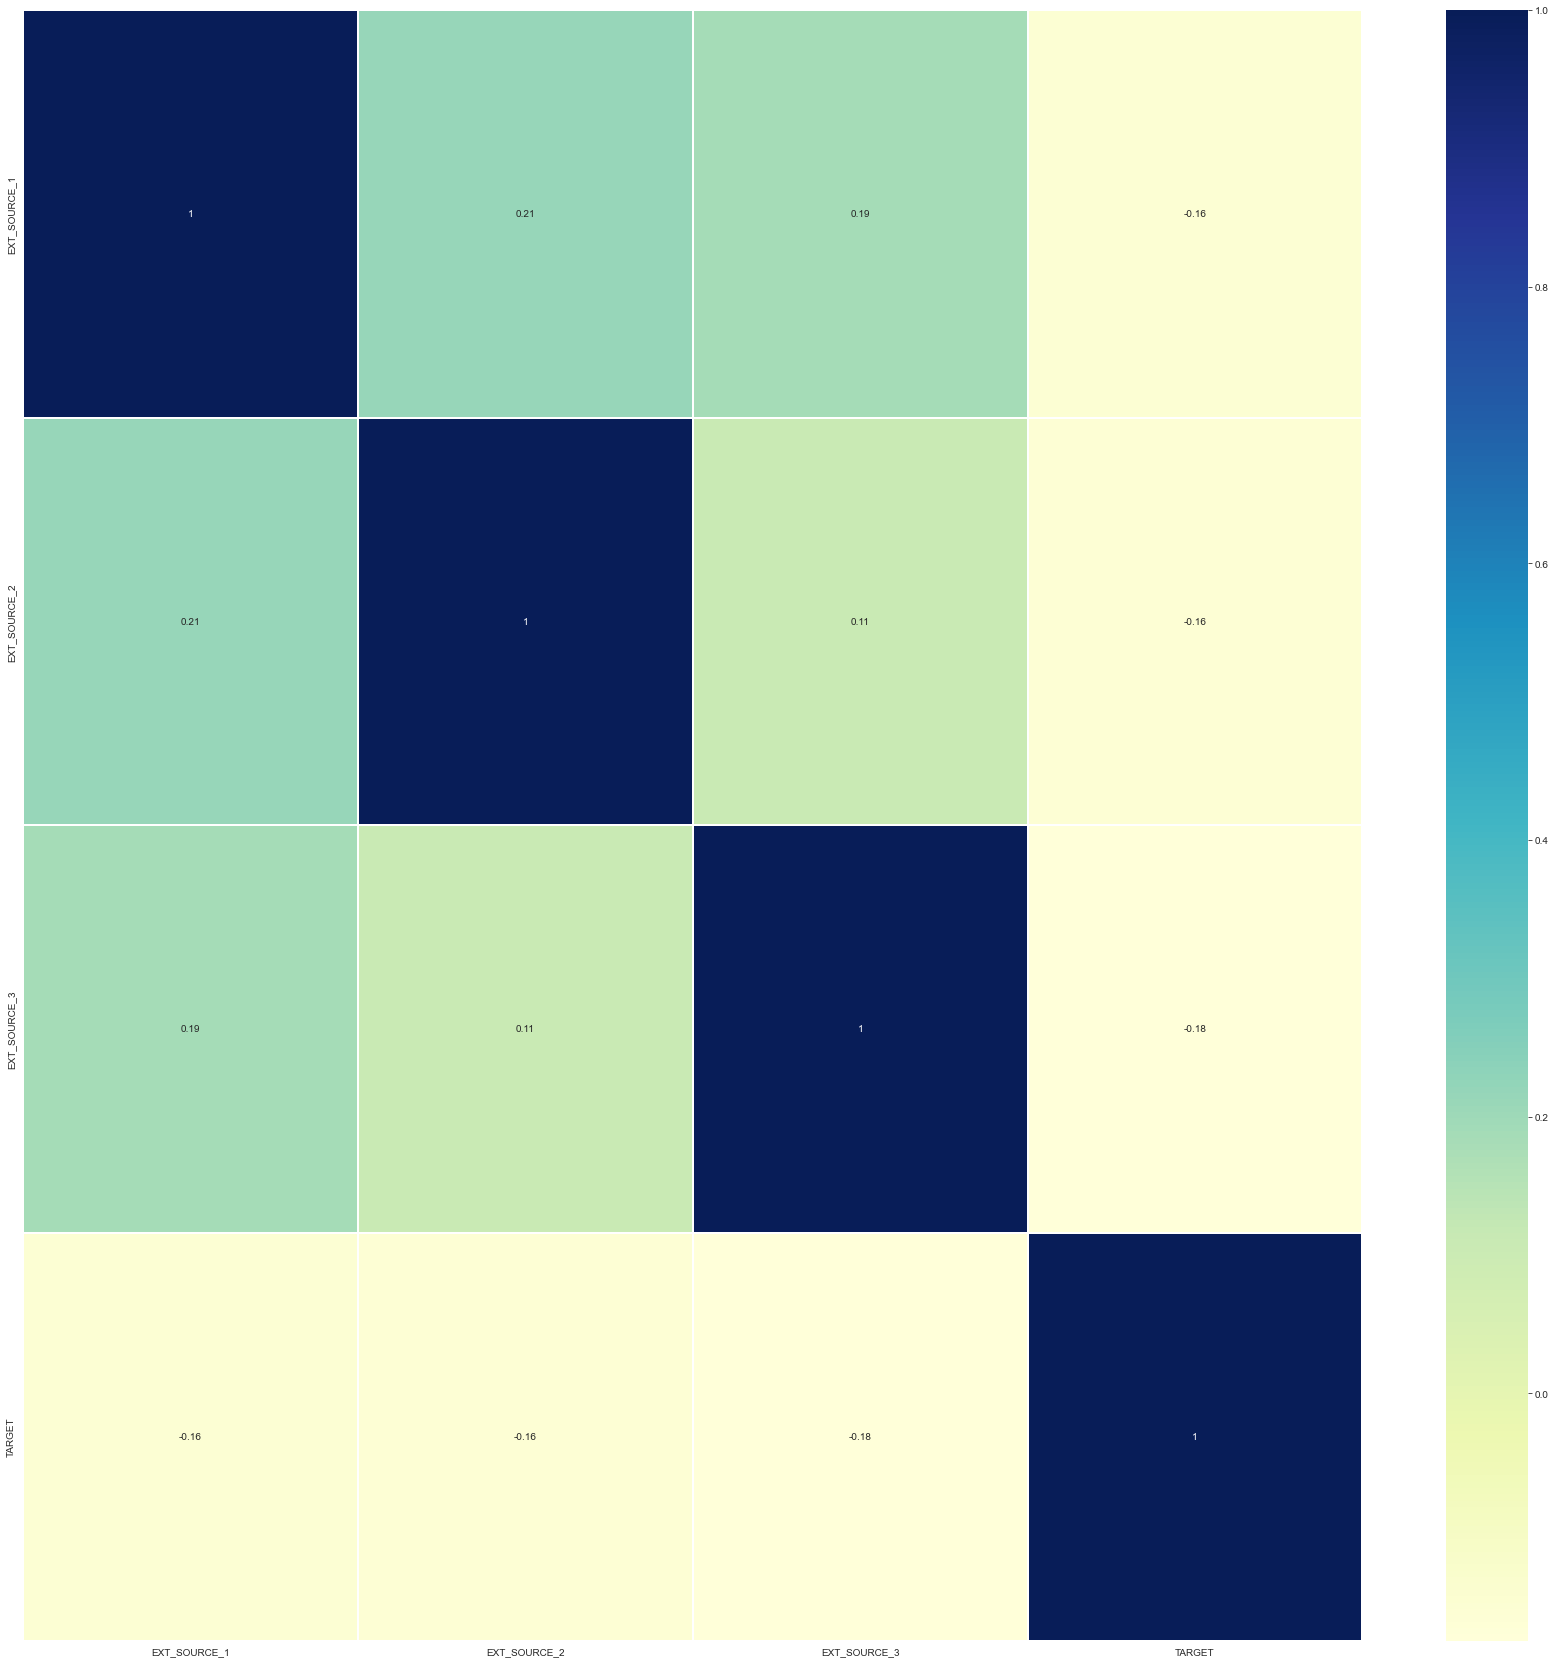

In [129]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

In [130]:
#Liste des valeurs numériques du dataset concernant les lieux d'habitation et de travail des clients 
Flag_list = ['REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']

In [131]:
#Création d'un dataset en sélectionnant seulement les variables de data_app_train que l'on trouve dans la liste définit
df = data_app_train[Flag_list]
df['TARGET']= data_app_train['TARGET']

In [132]:
#Afficher du tableau de corrélations
target_correlation (df).head(10)

TARGET                         1.000000
REG_CITY_NOT_WORK_CITY         0.050994
REG_CITY_NOT_LIVE_CITY         0.044395
LIVE_CITY_NOT_WORK_CITY        0.032518
REG_REGION_NOT_WORK_REGION     0.006942
REG_REGION_NOT_LIVE_REGION     0.005576
LIVE_REGION_NOT_WORK_REGION    0.002819
Name: TARGET, dtype: float64

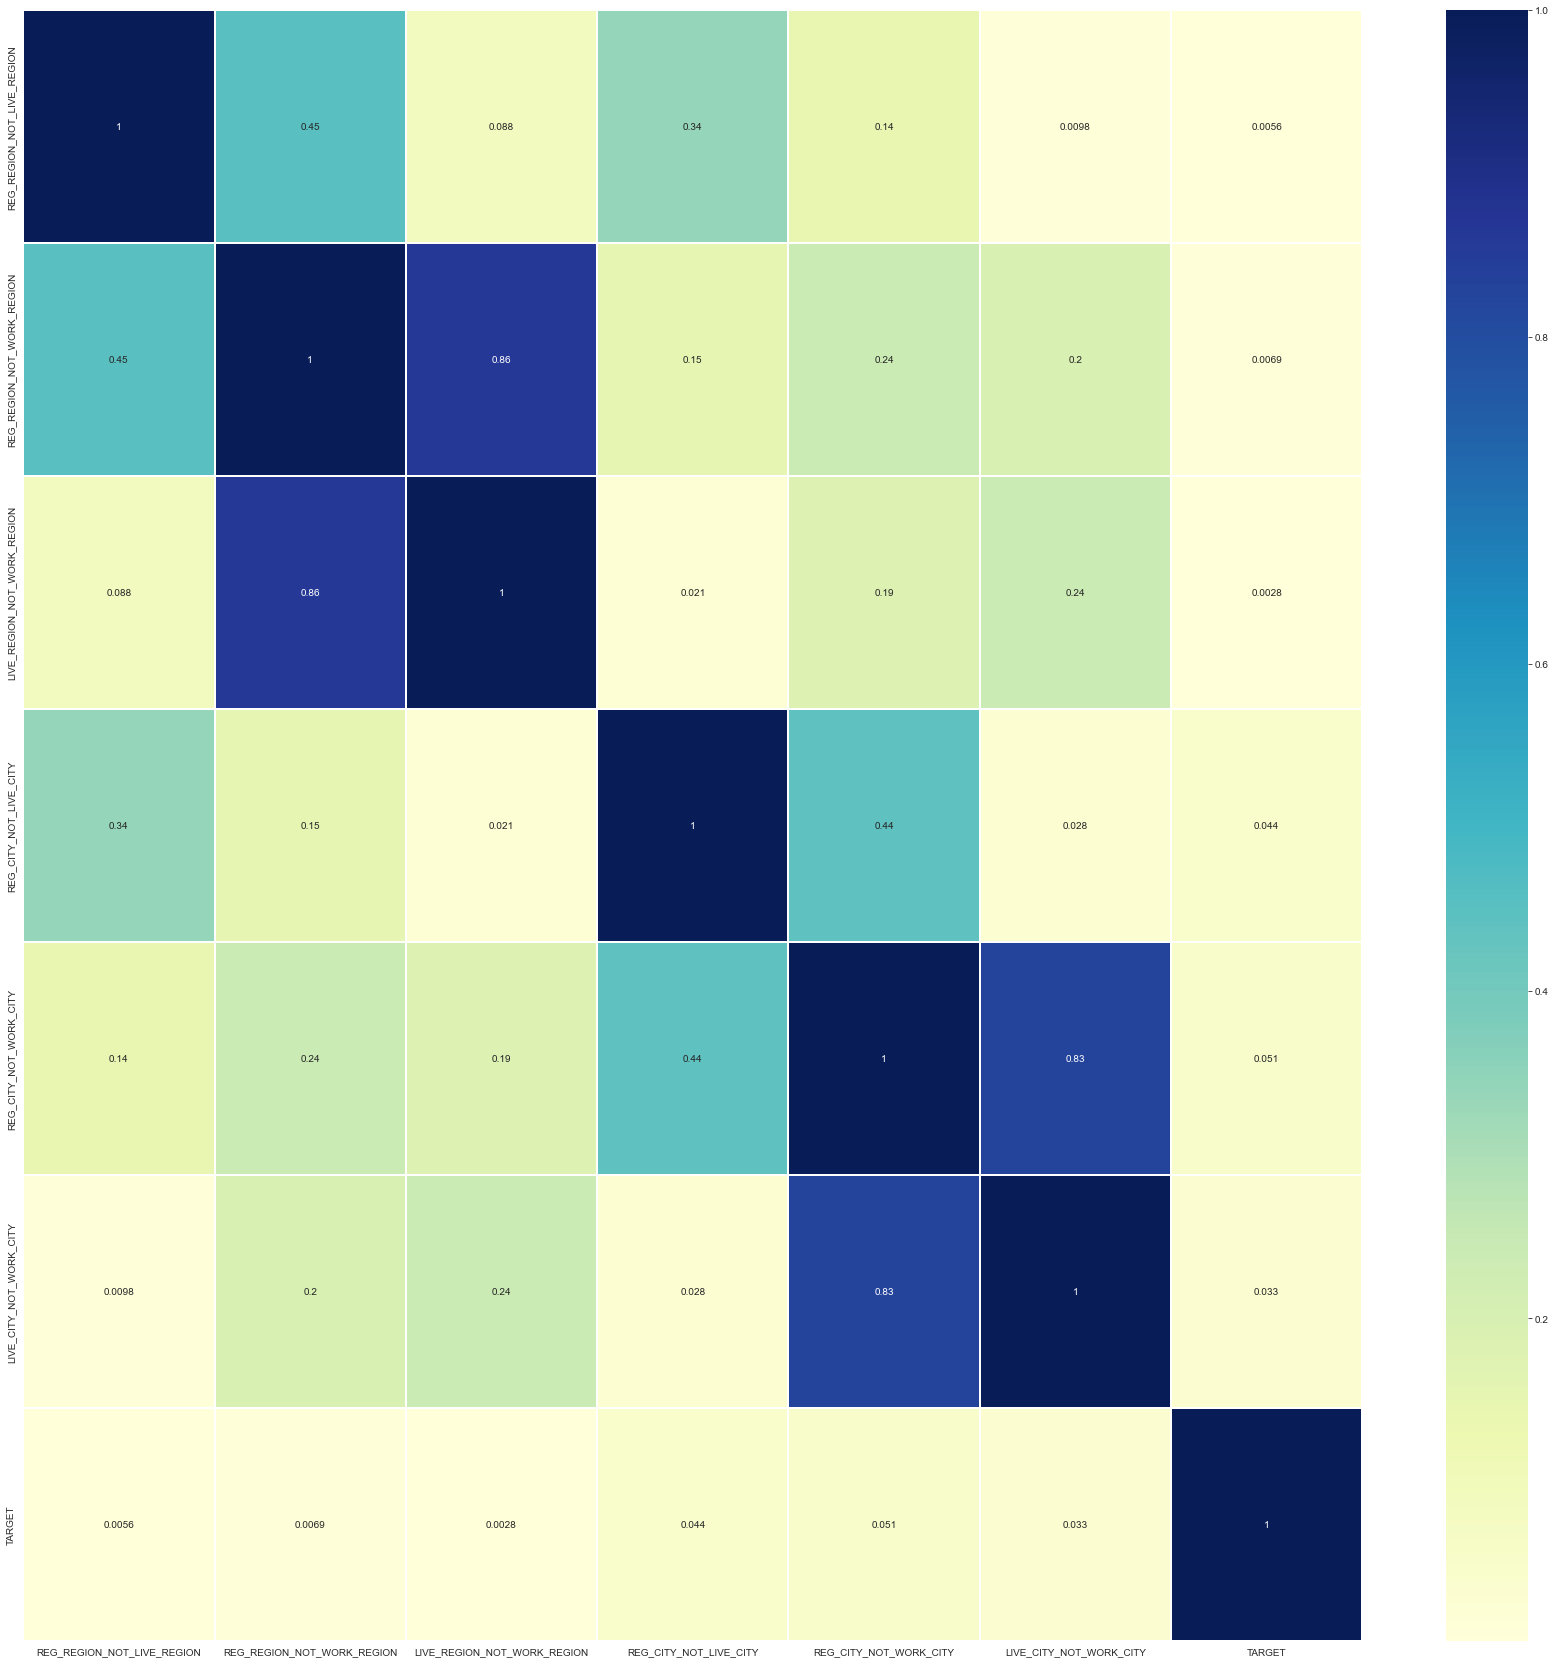

In [133]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

In [134]:
#Liste des valeurs numériques du dataset concernant des montants de revenus, crédits, annuité et prix des biens financés 
AMT_list = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']

In [135]:
#Création d'un dataset en sélectionnant seulement les variables de data_app_train que l'on trouve dans la liste définit
df = data_app_train[AMT_list]
df['TARGET']= data_app_train['TARGET']

In [136]:
#Afficher du tableau de corrélations
target_correlation (df).head(10)

TARGET              1.000000
AMT_INCOME_TOTAL   -0.003982
AMT_ANNUITY        -0.012817
AMT_CREDIT         -0.030369
AMT_GOODS_PRICE    -0.039645
Name: TARGET, dtype: float64

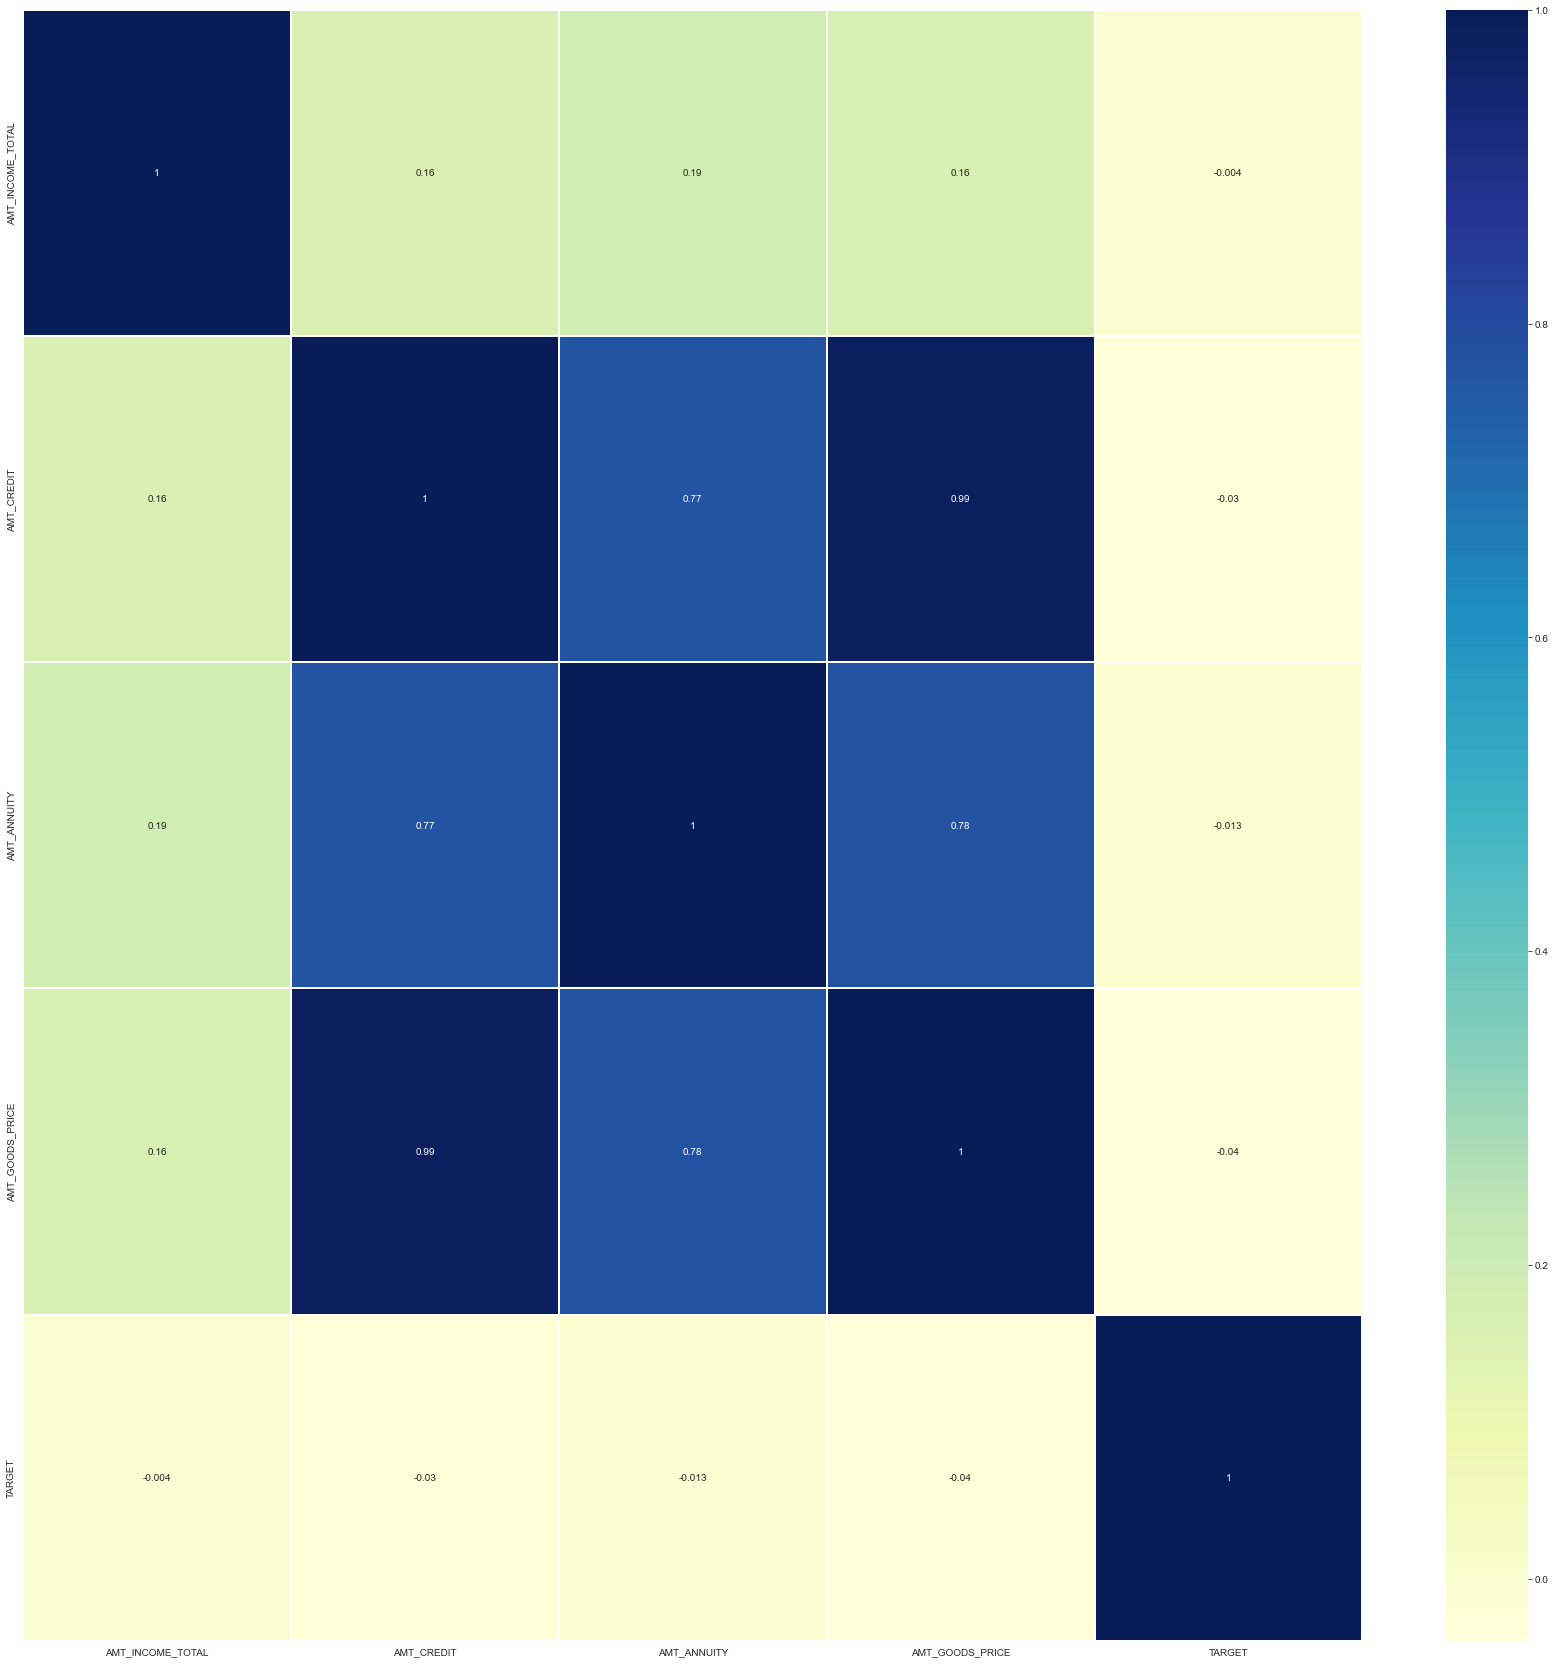

In [137]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

In [138]:
#Liste des valeurs numériques du dataset concernant des données en lien avec des dates (anniversaire du crédit, publication...) 
days_list = ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH' ]

In [139]:
#Création d'un dataset en sélectionnant seulement les variables de data_app_train que l'on trouve dans la liste définit
df = data_app_train[days_list]
df['TARGET']= data_app_train['TARGET']

In [140]:
#Afficher du tableau de corrélations
target_correlation (df).head(10)

TARGET               1.000000
DAYS_BIRTH           0.078239
DAYS_ID_PUBLISH      0.051457
DAYS_REGISTRATION    0.041975
DAYS_EMPLOYED       -0.044932
Name: TARGET, dtype: float64

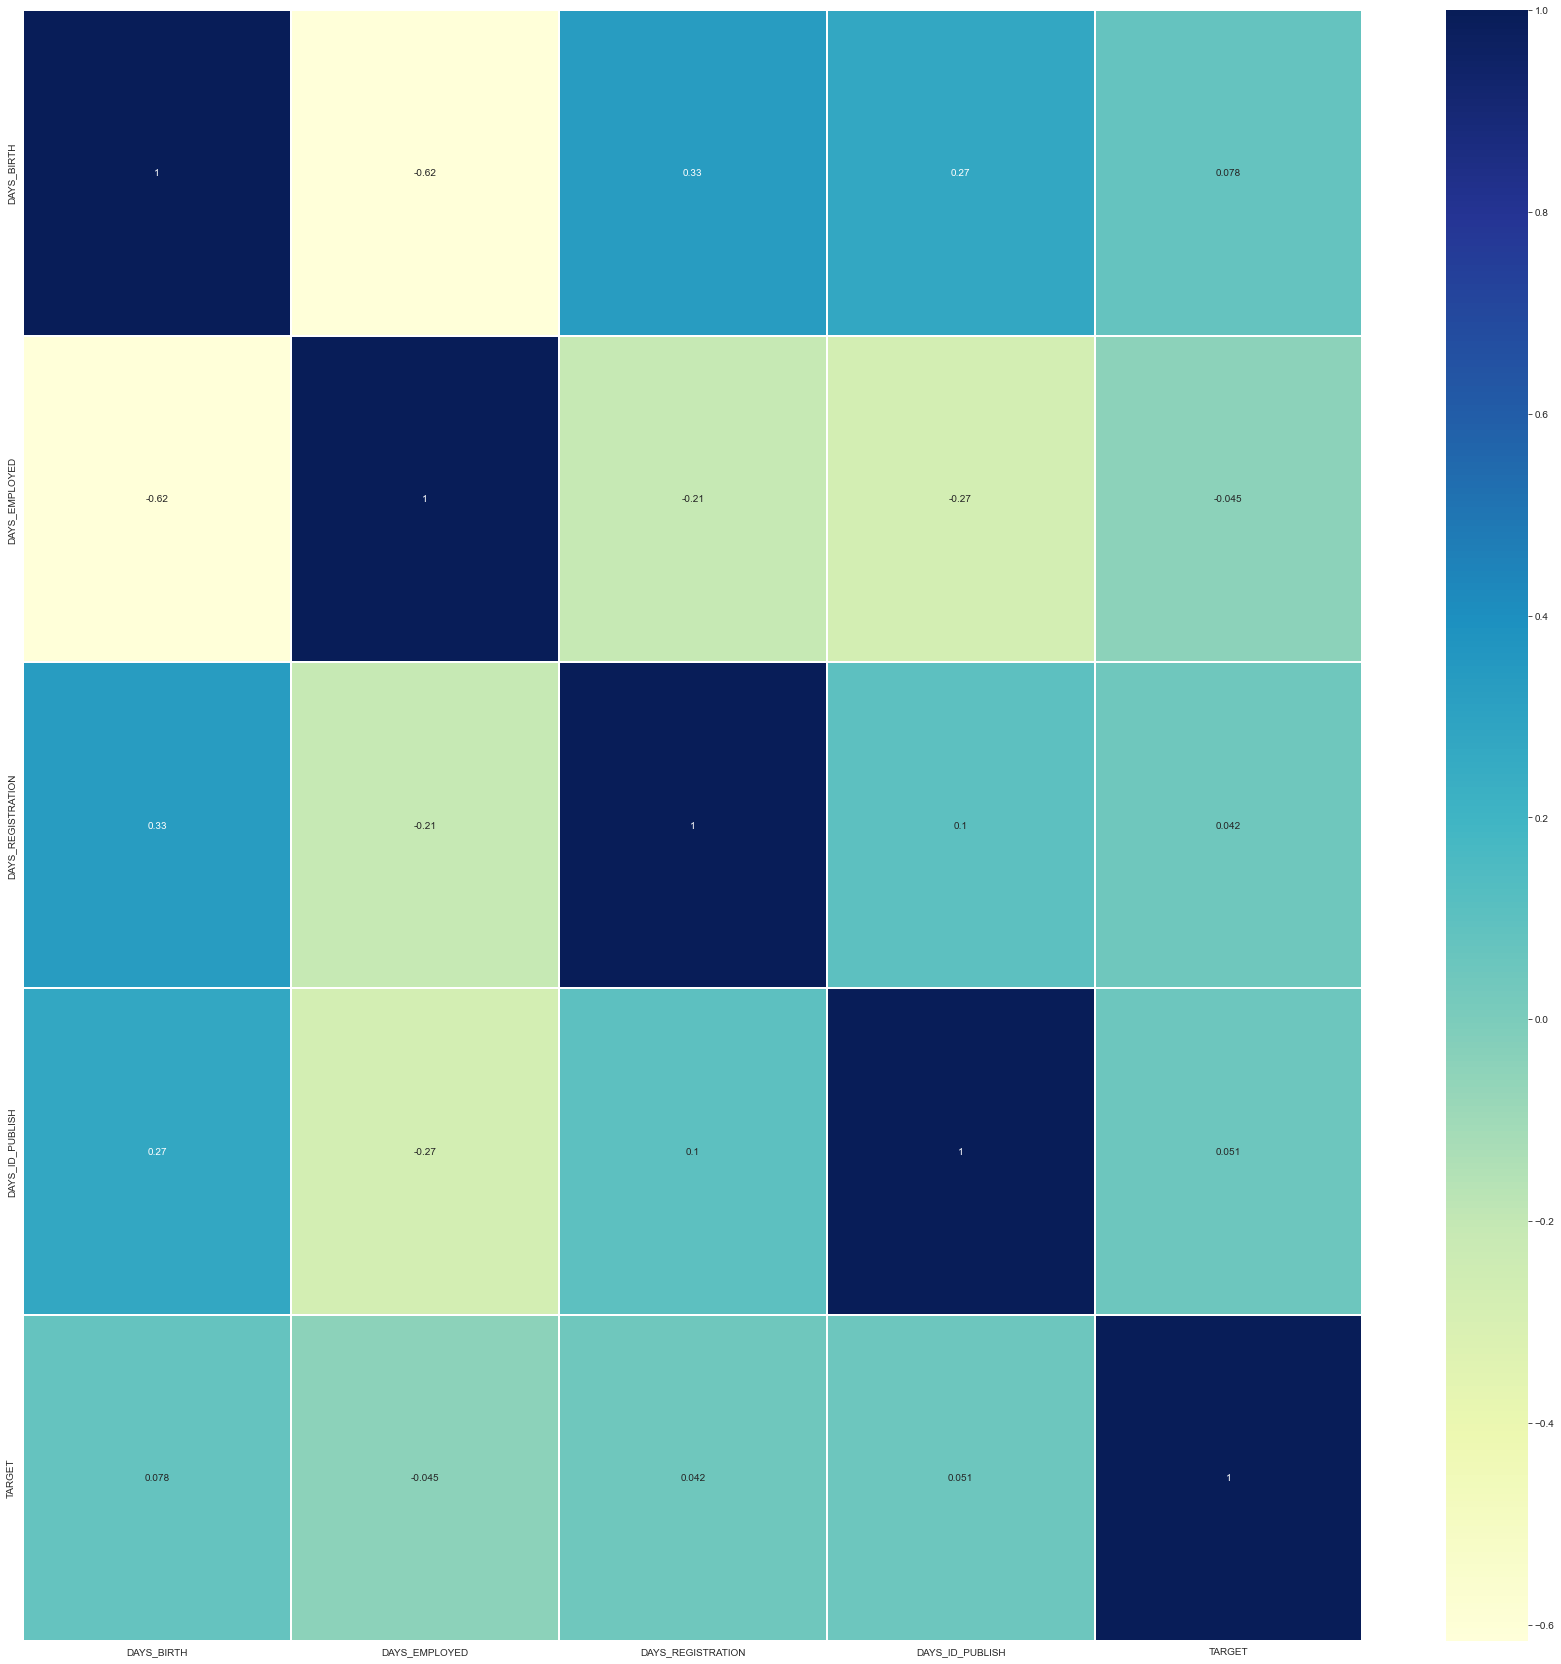

In [141]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

On va maintenant regarder la corrélation entre les données numériques du dataset data_bureau. Pour intégrer les défauts de paiment, on fait une fusion avec la variable Target de data_app_train en prenant la variable commune SK_ID_CURR

In [142]:
#Liste des valeurs numériques du dataset 
bureau_list = ['CREDIT_ACTIVE','CREDIT_CURRENCY','DAYS_CREDIT','CREDIT_DAY_OVERDUE',
'DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','AMT_CREDIT_MAX_OVERDUE','CNT_CREDIT_PROLONG','AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT',
'AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE','CREDIT_TYPE','DAYS_CREDIT_UPDATE','AMT_ANNUITY','SK_ID_CURR']

In [143]:
#Création d'un dataset en sélectionnant seulement les variables de data_bureau que l'on trouve dans la liste définit ainsi
#que la variable Target de data_app_train
df = data_bureau[bureau_list]
df = df.merge(data_app_train[['TARGET','SK_ID_CURR']], on = 'SK_ID_CURR', how = 'left')

In [144]:
#Afficher du tableau de corrélations
target_correlation (df).head(10)

TARGET                    1.000000
DAYS_CREDIT               0.061556
DAYS_CREDIT_UPDATE        0.041076
DAYS_ENDDATE_FACT         0.039057
DAYS_CREDIT_ENDDATE       0.026497
AMT_CREDIT_SUM_OVERDUE    0.006253
CREDIT_DAY_OVERDUE        0.002652
AMT_CREDIT_SUM_DEBT       0.002539
AMT_CREDIT_MAX_OVERDUE    0.001587
CNT_CREDIT_PROLONG        0.001523
Name: TARGET, dtype: float64

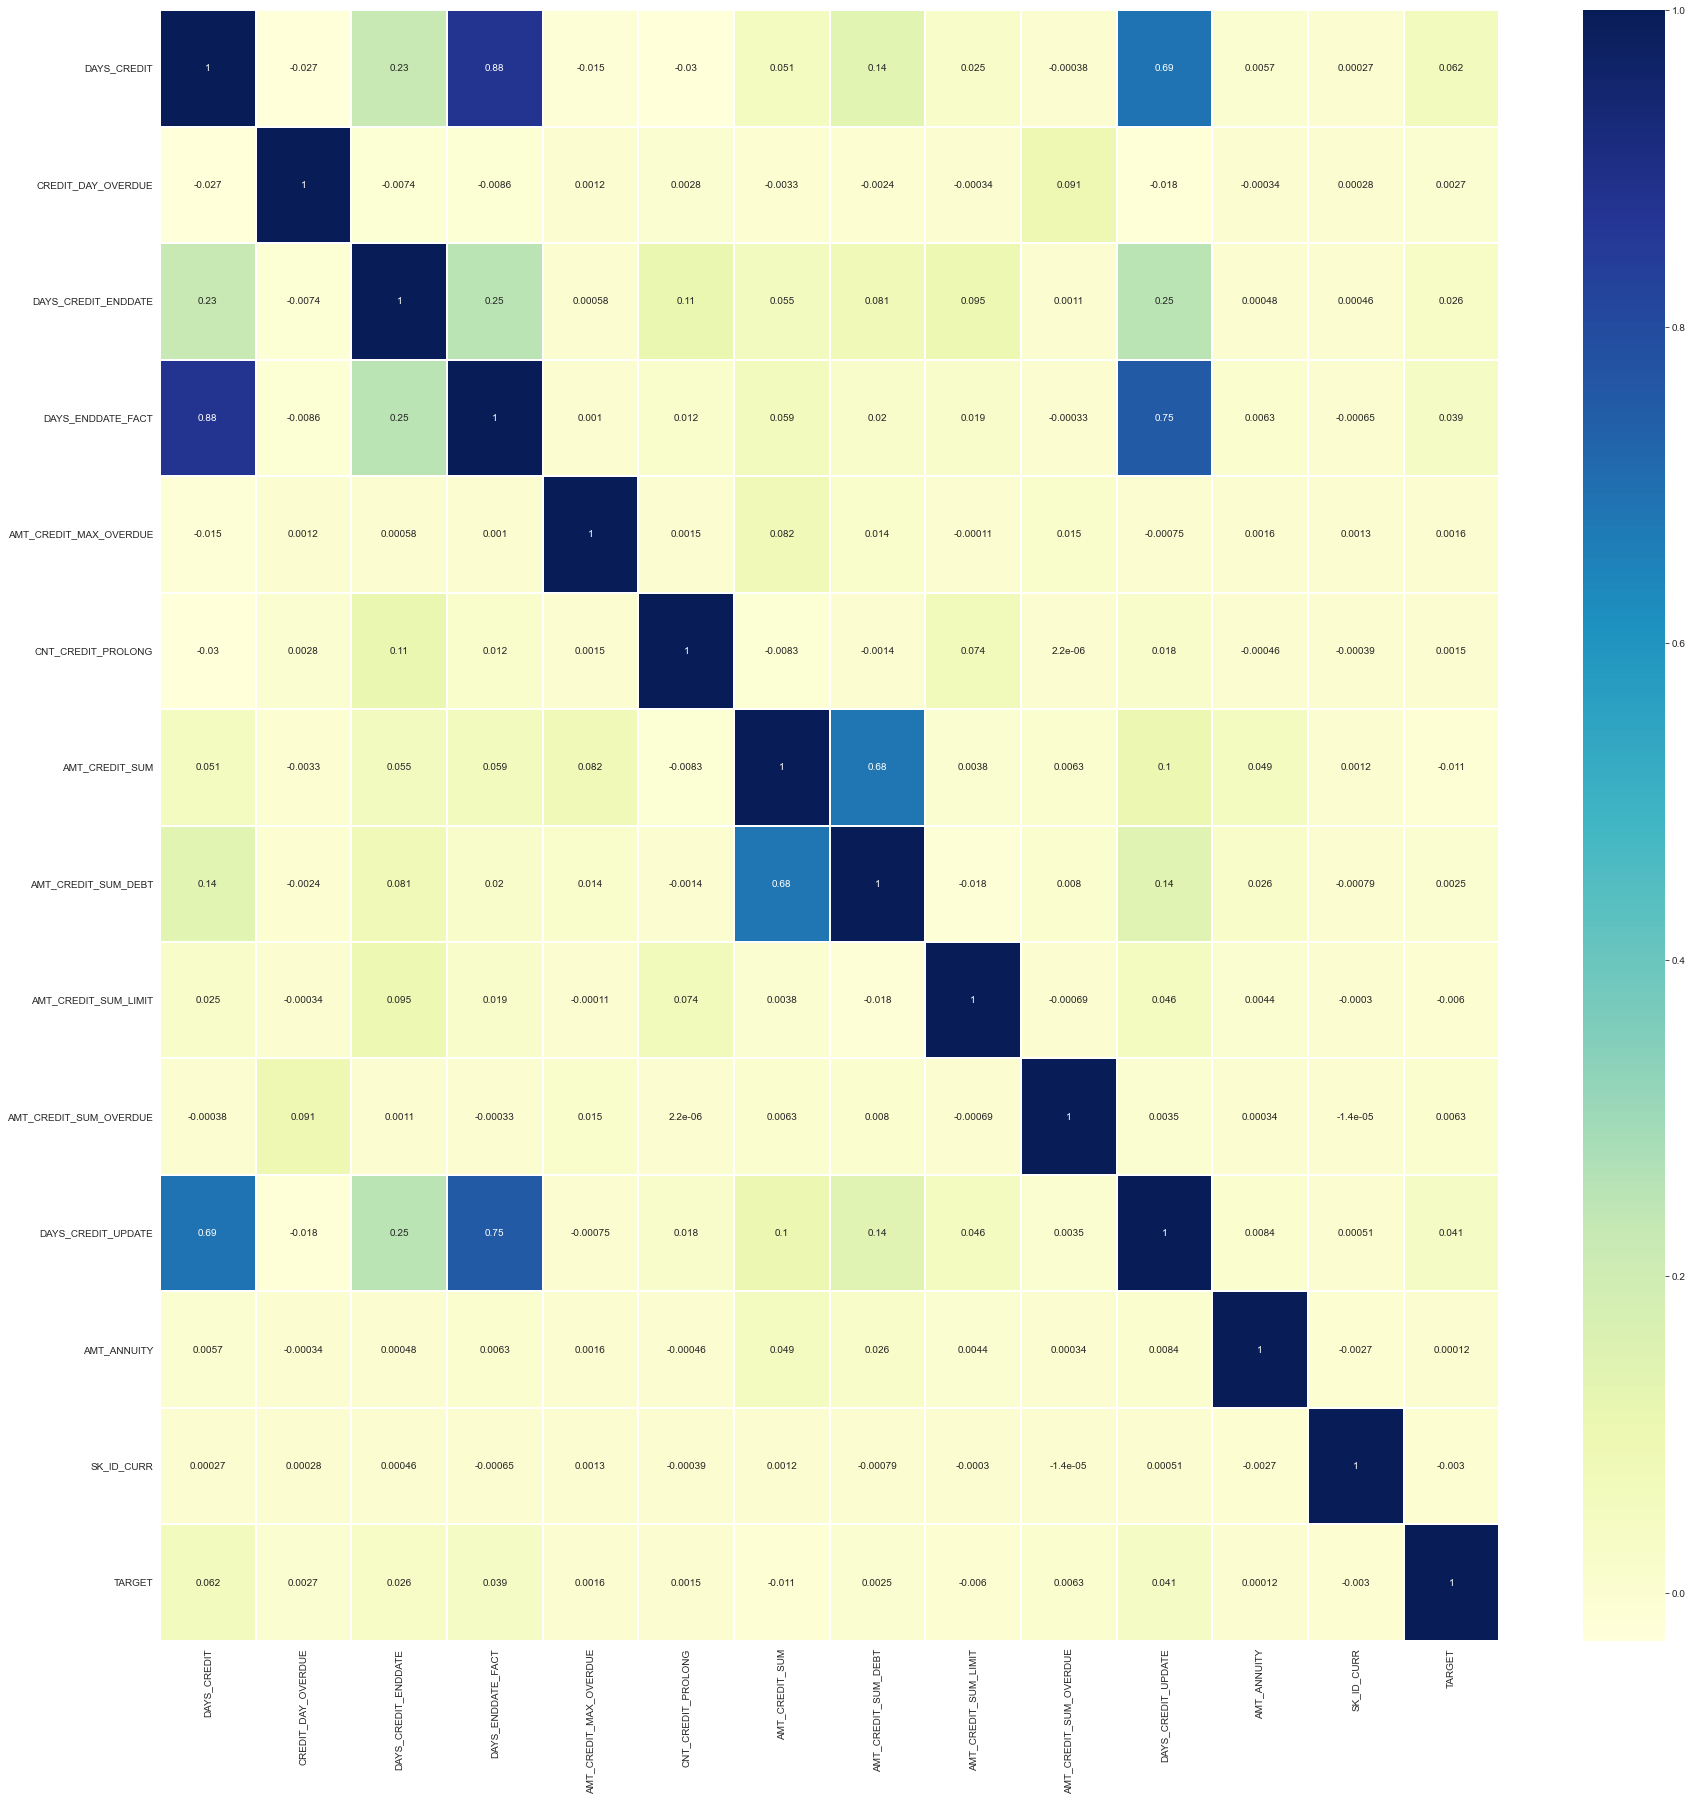

In [145]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

On va maintenant regarder la corrélation entre les données numériques du dataset data_credit_card_balance. Pour intégrer les défauts de paiment, on fait une fusion avec la variable Target de data_app_train en prenant la variable commune SK_ID_CURR

In [146]:
#Nous n'avons pas besoin de créer une liste pour ce dataset car nous ne sommes qu'en présence de valeurs numériques
#Création d'un dataset en sélectionnant seulement les variables de ce dataset ainsi que la variable Target
#de data_app_train
df = data_credit_card_balance
df = df.merge(data_app_train[['TARGET','SK_ID_CURR']], on = 'SK_ID_CURR', how = 'left')

In [147]:
#Afficher du tableau de corrélations
target_correlation (df).head(10)

TARGET                      1.000000
AMT_BALANCE                 0.050098
AMT_TOTAL_RECEIVABLE        0.049839
AMT_RECIVABLE               0.049803
AMT_RECEIVABLE_PRINCIPAL    0.049692
AMT_INST_MIN_REGULARITY     0.039798
CNT_DRAWINGS_ATM_CURRENT    0.038437
CNT_DRAWINGS_CURRENT        0.037793
MONTHS_BALANCE              0.035695
CNT_DRAWINGS_POS_CURRENT    0.029536
Name: TARGET, dtype: float64

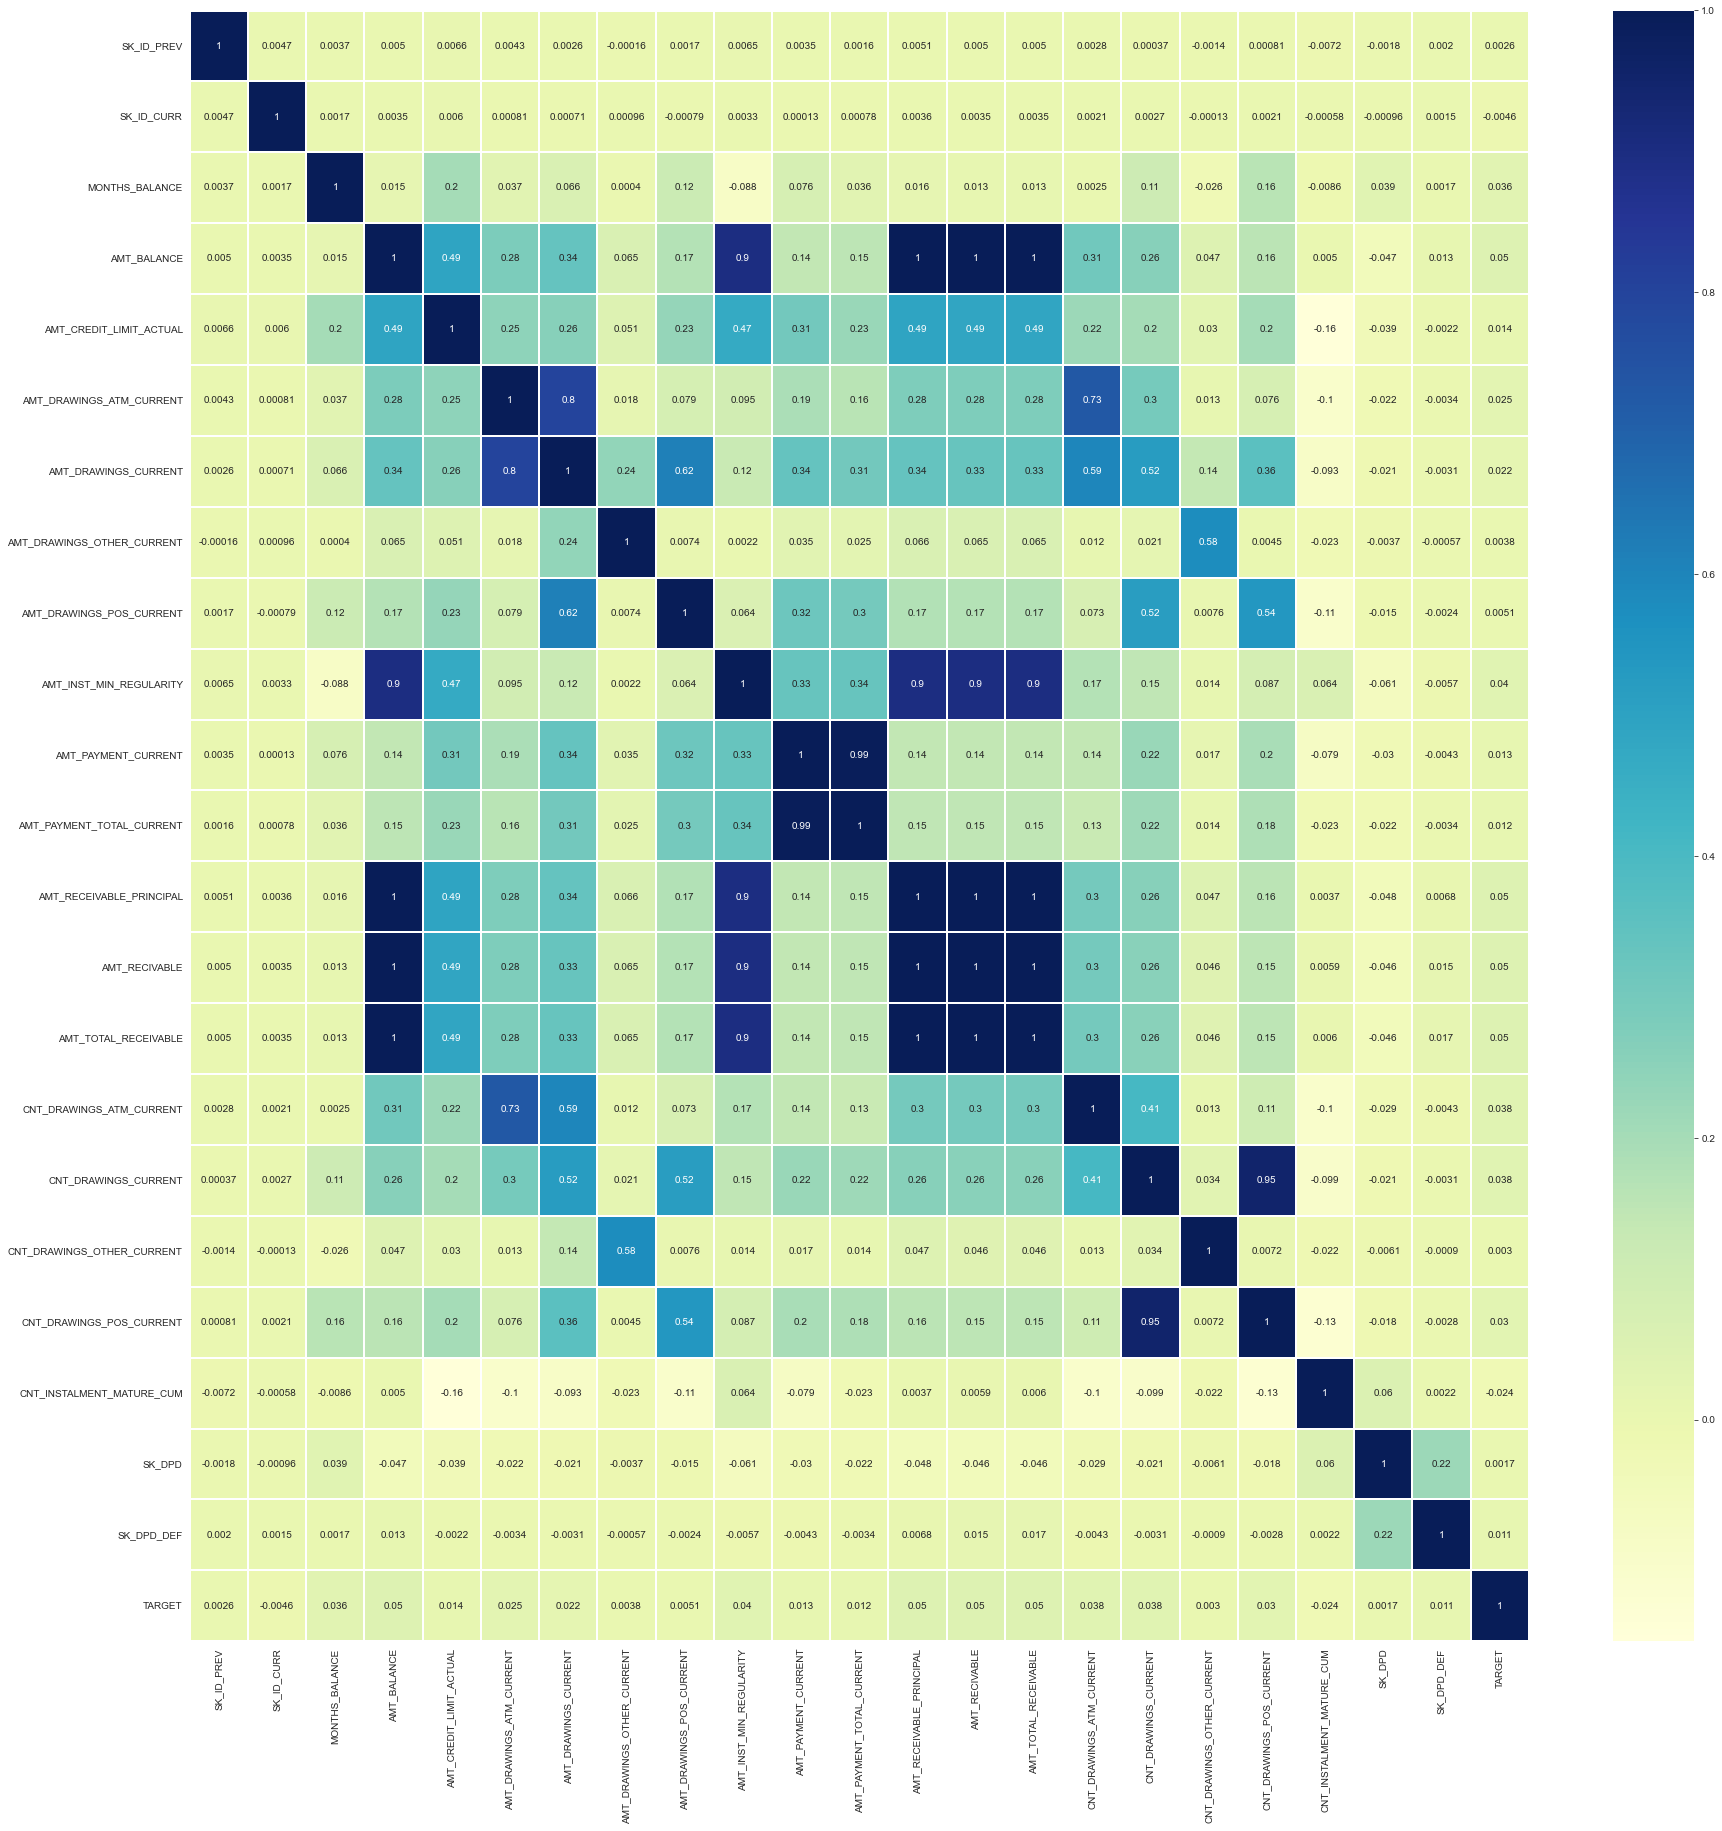

In [148]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

On va maintenant regarder la corrélation entre les données numériques du dataset data_installments_bureau. Pour intégrer les défauts de paiment, on fait une fusion avec la variable Target de data_app_train en prenant la variable commune SK_ID_CURR

In [149]:
#Nous n'avons pas besoin de créer une liste pour ce dataset car nous ne sommes qu'en présence de valeurs numériques
#Création d'un dataset en sélectionnant seulement les variables de ce dataset ainsi que la variable Target
#de data_app_train
df = data_installments_payments
df = df.merge(data_app_train[['TARGET','SK_ID_CURR']], on = 'SK_ID_CURR', how = 'left')

In [150]:
#Afficher du tableau de corrélations
target_correlation (df).head(10)

TARGET                    1.000000
DAYS_ENTRY_PAYMENT        0.035122
DAYS_INSTALMENT           0.034974
SK_ID_PREV               -0.000212
AMT_INSTALMENT           -0.001498
SK_ID_CURR               -0.002540
AMT_PAYMENT              -0.003623
NUM_INSTALMENT_VERSION   -0.009896
NUM_INSTALMENT_NUMBER    -0.016190
Name: TARGET, dtype: float64

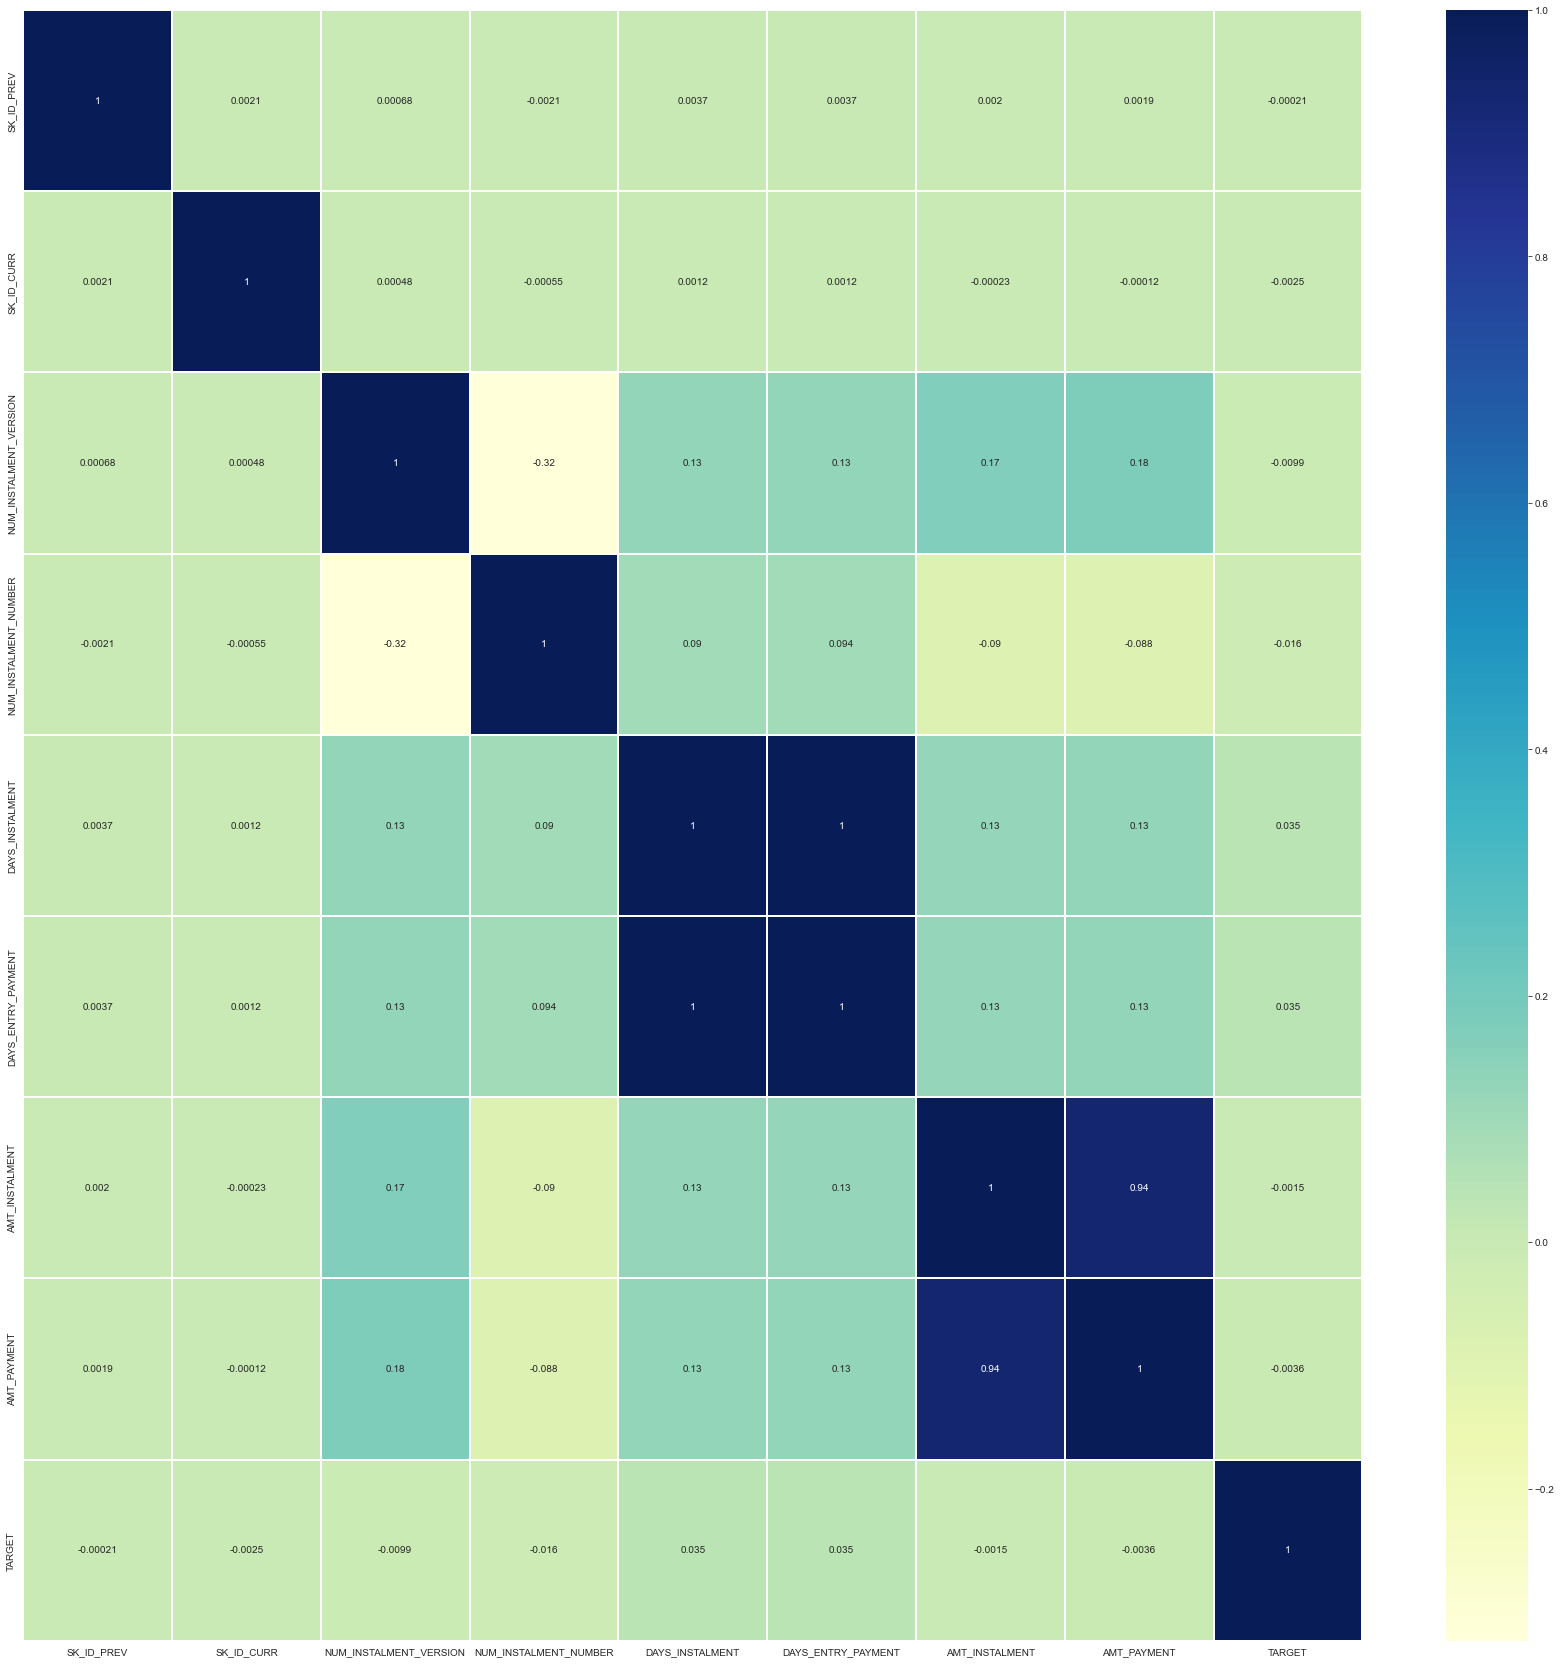

In [151]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

On va maintenant regarder la corrélation entre les données numériques du dataset data_previous_applications. Pour intégrer les défauts de paiment, on fait une fusion avec la variable Target de data_app_train en prenant la variable commune SK_ID_CURR

In [152]:
#Nous n'avons pas besoin de créer une liste pour ce dataset car nous ne sommes qu'en présence de valeurs numériques
#Création d'un dataset en sélectionnant seulement les variables de ce dataset ainsi que la variable Target
#de data_app_train
df = data_previous_application
df = df.merge(data_app_train[['TARGET','SK_ID_CURR']], on = 'SK_ID_CURR', how = 'left')

In [153]:
#Afficher du tableau de corrélations
target_correlation (df).head(10)

TARGET                       1.000000
DAYS_DECISION                0.039901
CNT_PAYMENT                  0.030480
RATE_INTEREST_PRIVILEGED     0.028640
DAYS_LAST_DUE_1ST_VERSION    0.018021
DAYS_LAST_DUE                0.017522
DAYS_TERMINATION             0.016981
SK_ID_PREV                   0.002009
NFLAG_INSURED_ON_APPROVAL    0.000653
AMT_GOODS_PRICE              0.000254
Name: TARGET, dtype: float64

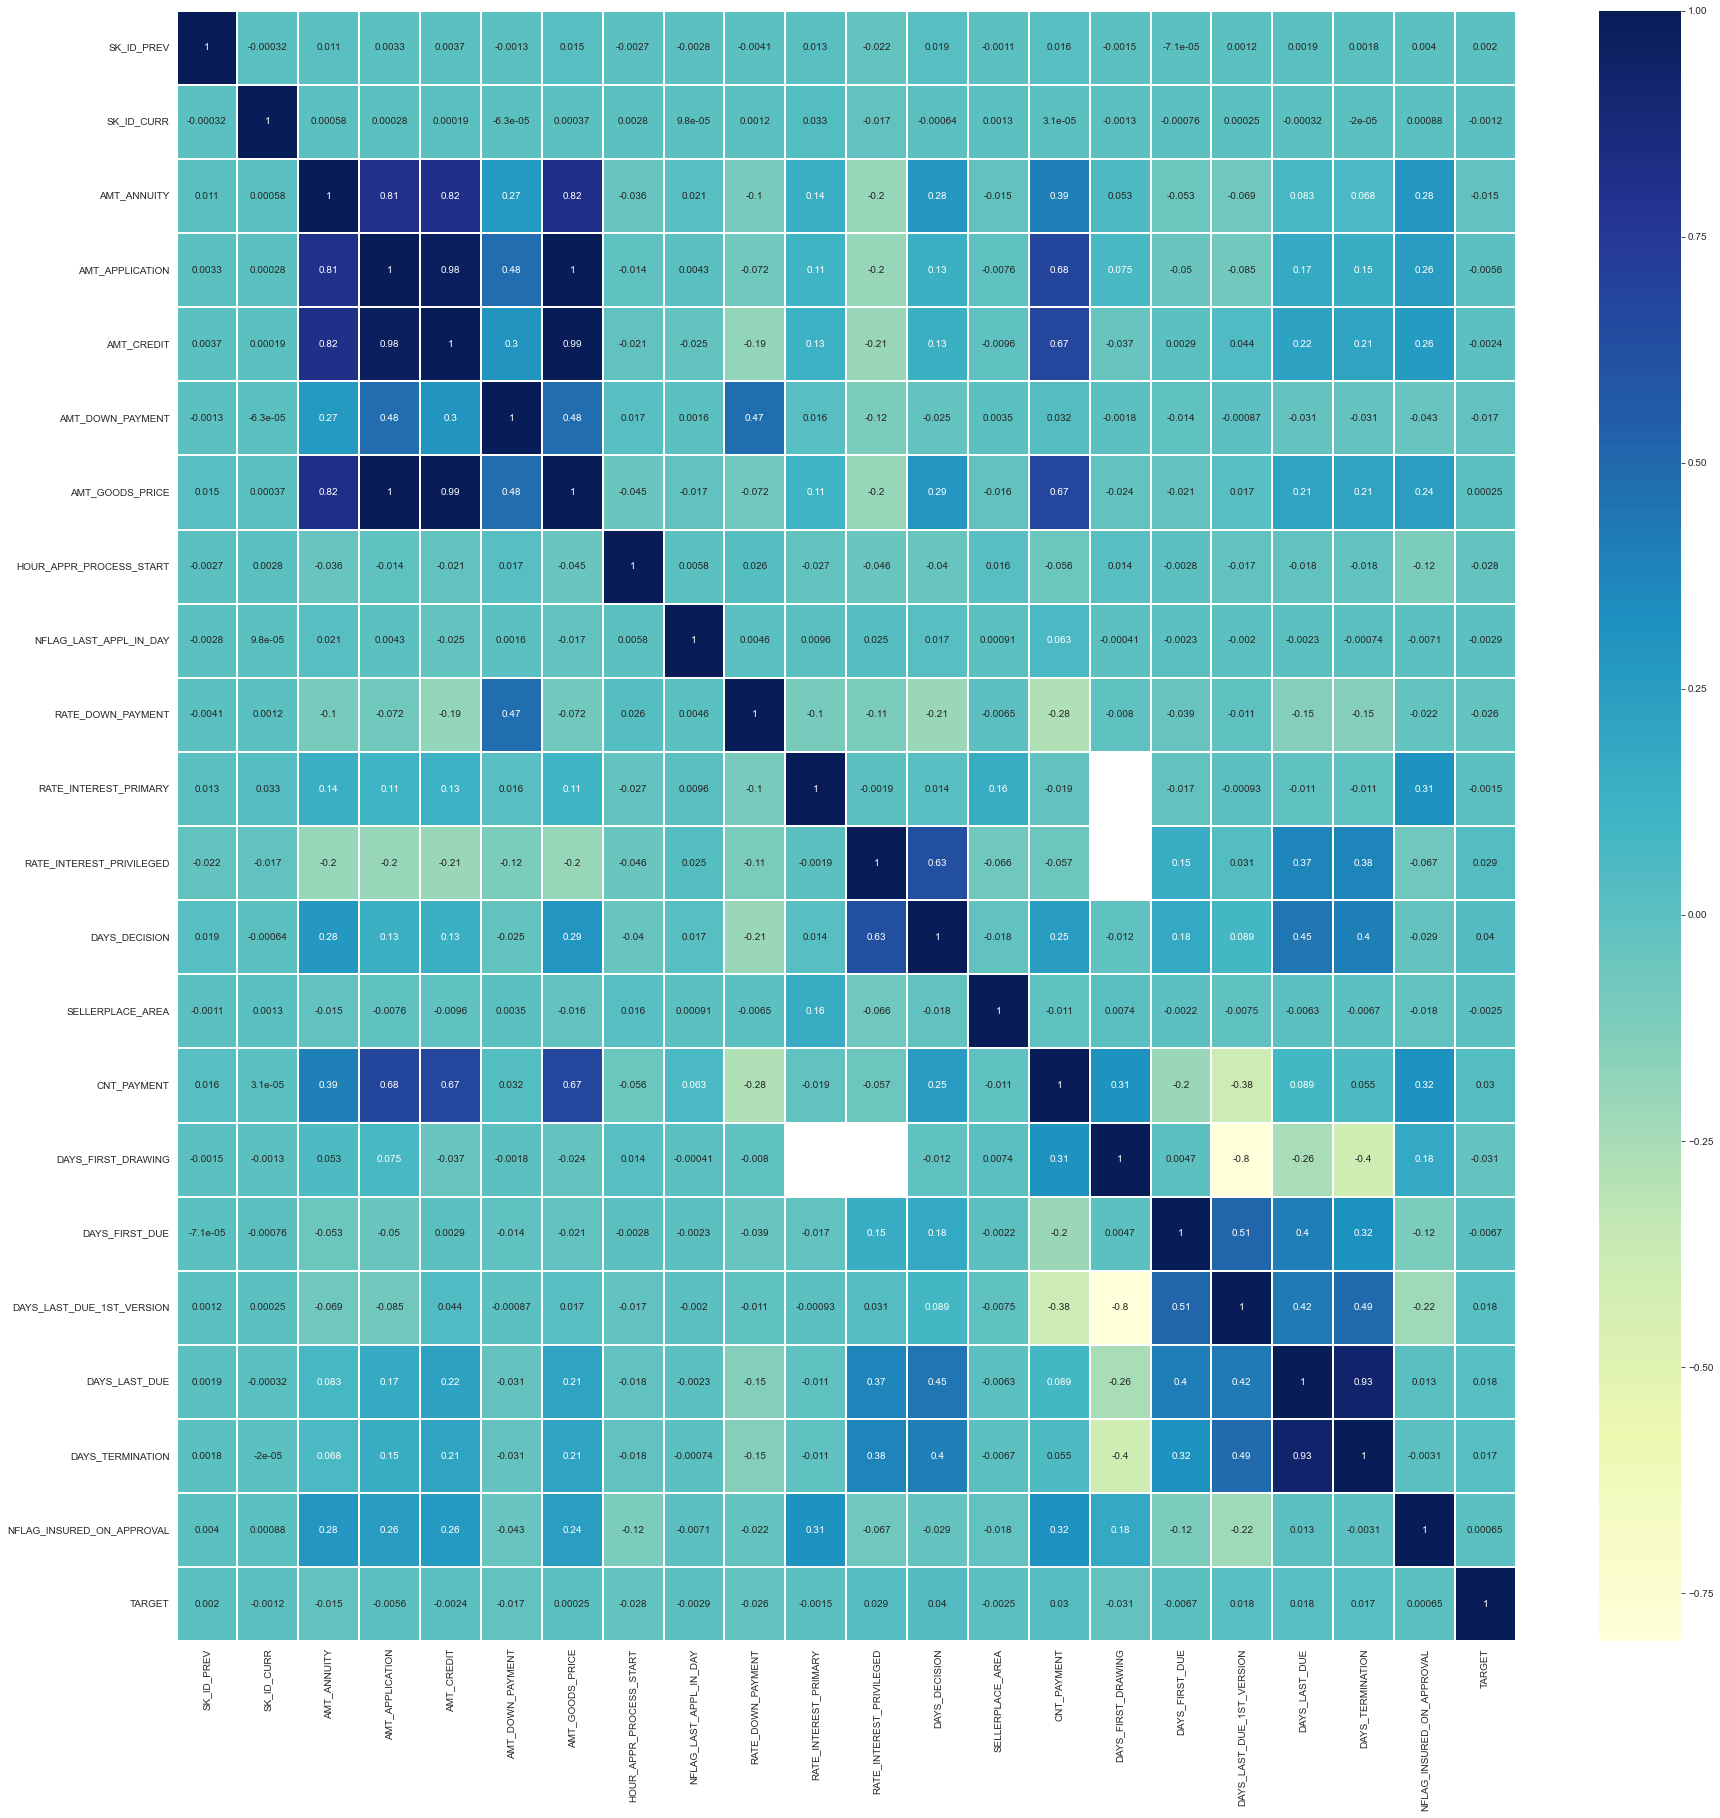

In [154]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

On va maintenant regarder la corrélation entre les données numériques du dataset data_POS_CASH_balance. Pour intégrer les défauts de paiment, on fait une fusion avec la variable Target de data_app_train en prenant la variable commune SK_ID_CURR

In [155]:
#Nous n'avons pas besoin de créer une liste pour ce dataset car nous ne sommes qu'en présence de valeurs numériques
#Création d'un dataset en sélectionnant seulement les variables de ce dataset ainsi que la variable Target
#de data_app_train
df = data_POS_CASH_balance
df = df.merge(data_app_train[['TARGET','SK_ID_CURR']], on = 'SK_ID_CURR', how = 'left')

In [156]:
#Afficher du tableau de corrélations
target_correlation (df).head(10)

TARGET                   1.000000
CNT_INSTALMENT_FUTURE    0.021972
MONTHS_BALANCE           0.020147
CNT_INSTALMENT           0.018506
SK_DPD                   0.009866
SK_DPD_DEF               0.008594
SK_ID_PREV              -0.000056
SK_ID_CURR              -0.002245
Name: TARGET, dtype: float64

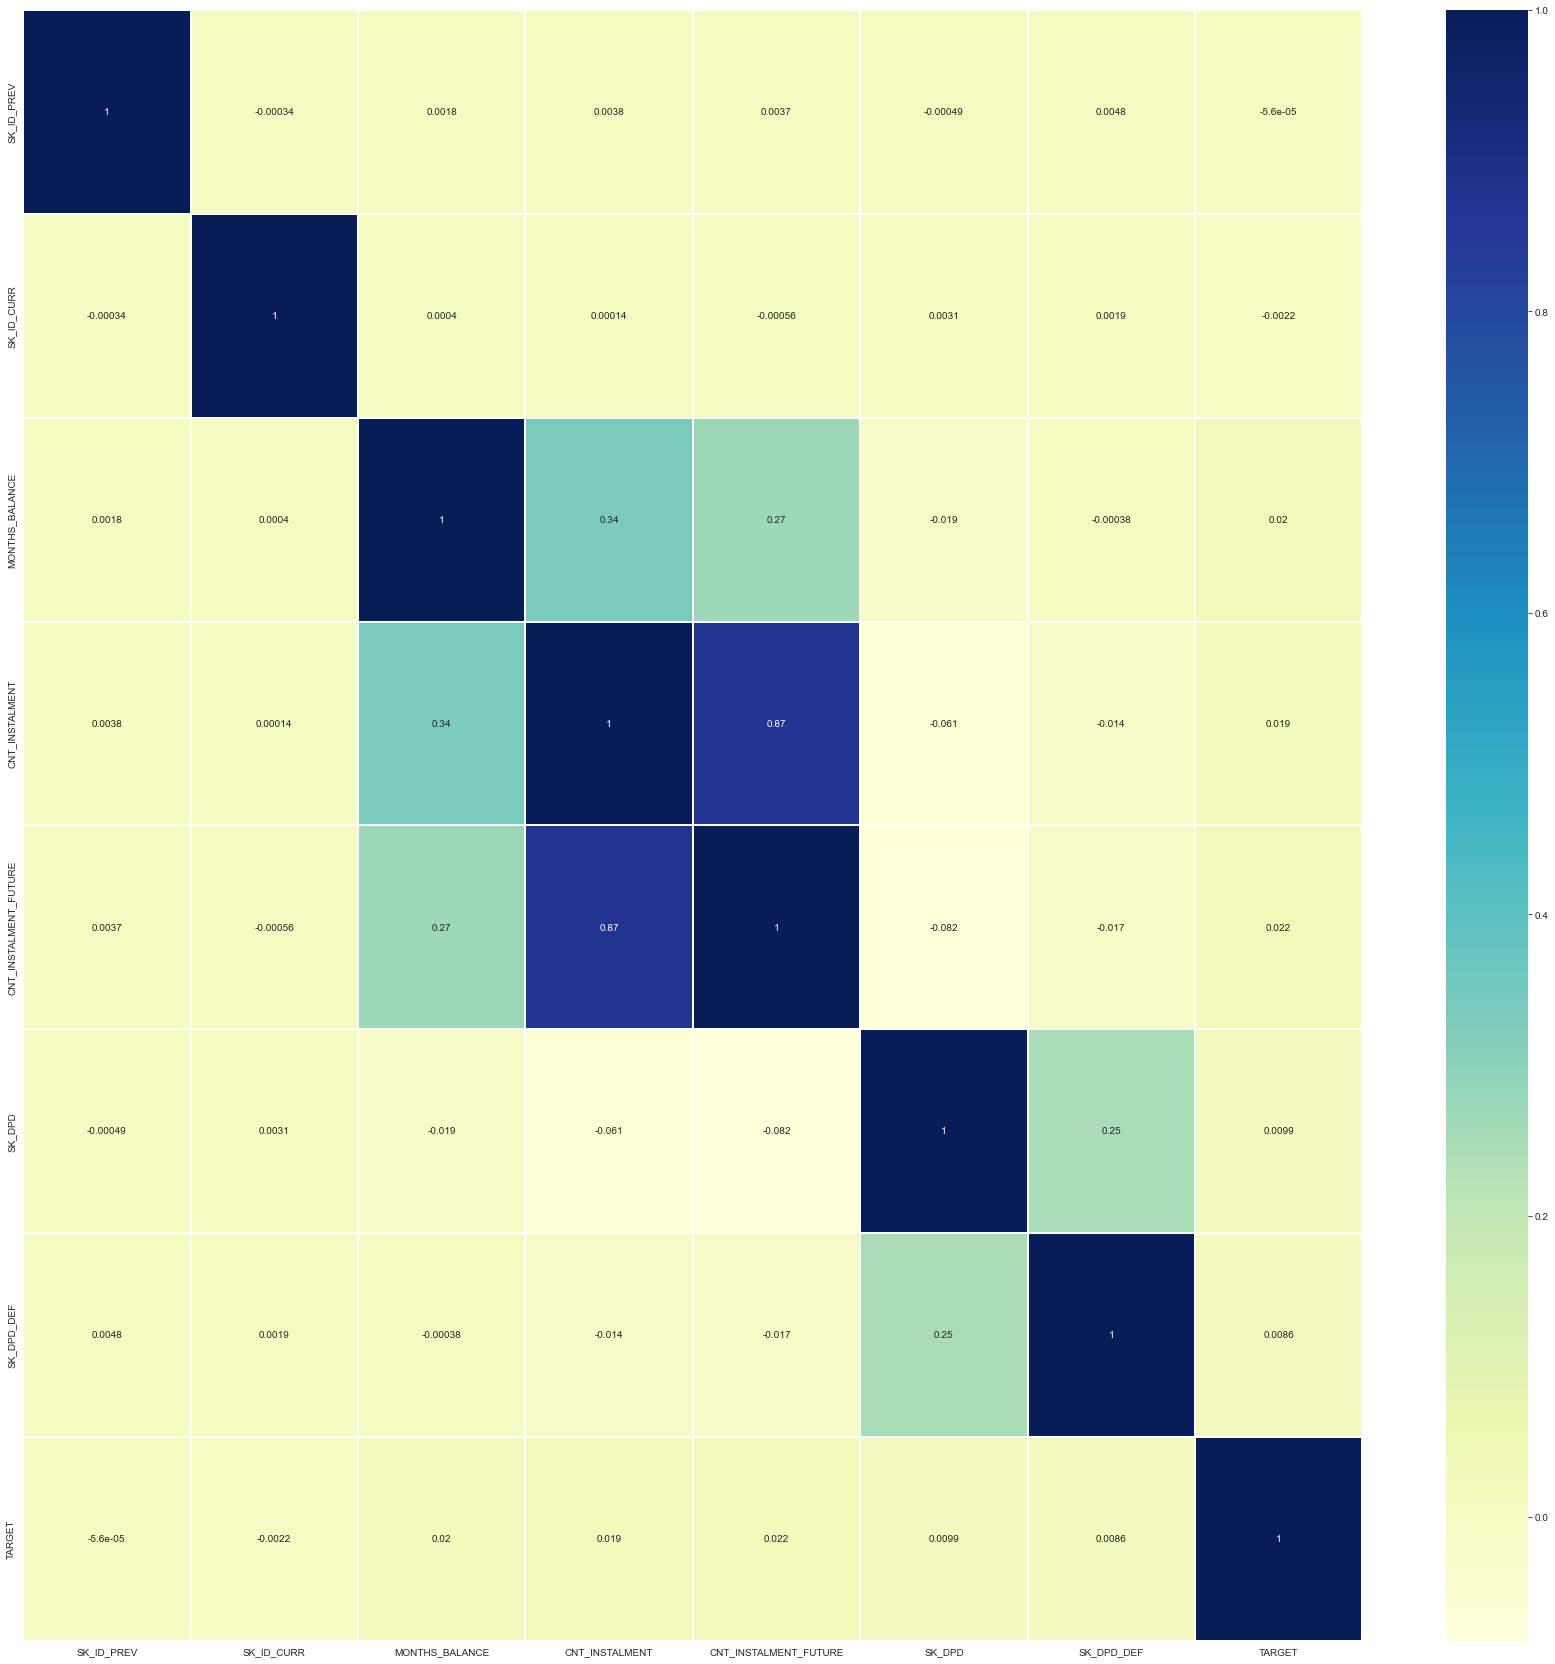

In [157]:
#Affichage de la matrice de corrélation
heatmap_correlation(df)

### Conclusion

Signification de chaque dataset :
* data_app_train et data_app_test : Informations sur des emprunts ainsi que les clients
* data bureau : Informations sur les emprunts dans les autres banques
* data_bureau_balance : Informations sur des soldes de crédits et leur statut
* data_previous_applications : Informations sur les anciens emprunts contractés auprès de Homecrédit par un client
* data_credit_card_balance : Informations concernant des soldes en lien avec des opérations de cartes bancaires
* data_installments_payments : Informations concernant les paiements échelonnés des emprunts
* data_POS_CASH_balance : Informations concernant les emprunts, leur statut, les échéances restants ou encore des montants d'encours
* data_HomeCredit_columns_description : Informations concernant la significations des variables de chaque dataset
    

On a donc une vision des datasets globale concernant la présence de données manquantes ou non, le traitement d'outliers.
Nous avons pu définir les liens entre les datasets pour effectuer des fusions.
Nous allons donc dans le notebook suivant définir les données à conserver dans un dataset pour notre étude et préparer les donénes afin de pouvoir appliquer différents entrainements de modèles.